# Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import luigi
import pickle
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb, catboost as catb, lightgbm as lgbm

from matplotlib import pyplot as plt
from datetime import datetime
from dask import dataframe as dd
from pathlib import Path

from tqdm import tqdm

from dask.distributed import Client, LocalCluster

from scipy.stats import mannwhitneyu

# Пути к директориям и файлам 

In [114]:
DATA_ROOT = Path('E:/2. УЧЕБА ЭНИ')
SAVED_DATA_ROOT = Path('C:/Users/Евгений/Desktop/')
FEATURES_PATH = DATA_ROOT / 'features.csv'
TRAIN_PATH = DATA_ROOT / 'data_train.csv'
TEST_PATH = DATA_ROOT / 'data_test.csv'
MERGE_TEST_PATH = SAVED_DATA_ROOT / 'test_merge.csv'
MERGE_TRAIN_PATH = SAVED_DATA_ROOT / 'train_merge.csv'

ROOT_TO_SAVE_MODEL = Path('./')
PATH_TO_SAVE_MODEL = ROOT_TO_SAVE_MODEL / 'model.pkl'

PATH_TO_SAVE_PREDICTION_ROOT = Path('./')
PATH_TO_SAVE_PREDICTION = PATH_TO_SAVE_PREDICTION_ROOT / 'prediction.csv'

# Постановка задачи

## Цель

Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

## Целевая переменная

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно

## Метрика качества

$$f_1=\frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} \cdot \text{recall}}$$

## Требования к решению

Метрика f1 должна быть больше 0.68 

## Описание датасета

Данные распределены между тремя файлами features.csv, data_train.csv, data_test.csv. features.csv - содержит значение фитчей в разные моменты времени. data_train содержит данные о факте отклика на предложение и время совершения транзакции

Колонки data_train.csv:
* **buy_time** - время покупки, представлено в формате timestamp
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга

Колонки features.csv:
* **buy_time** - время покупки, представлено в формате timestamp
* **id** - идентификатор абонента
* **0-252** - фитчи


# Загрузка данных 

In [3]:
train_df = pd.read_csv(TRAIN, index_col=0)
test_df = pd.read_csv(TEST, index_col=0)
features_ddf = dd.read_csv(FEATURES, sep='\t')
features_ddf = features_ddf.drop(columns=['Unnamed: 0'])

In [ ]:
train_df.head(2)

In [153]:
test_df.head(2)

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000


In [ ]:
features_ddf.head(2)

 # Преобразование данных, добавление фитчей

In [108]:
class TaskMergeData(luigi.Task):
    
    path_to_file = luigi.Parameter()
    path_to_save_file = luigi.Parameter()
    path_to_features_file = luigi.Parameter()
    
    def output(self):
        return luigi.LocalTarget(self.path_to_save_file)
    
    def reduce_mem_usage(df):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
        """
        start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df    
    
    def run(self):
        # read input data
        data = pd.read_csv(self.path_to_file, index_col=0)
        features = dd.read_csv(self.path_to_features_file, sep='\t')
        features = features.drop(columns=['Unnamed: 0'])
        
        # handle buy_time
        data.buy_time = data.buy_time.apply(lambda x: datetime.fromtimestamp(x))
        features.buy_time = features.buy_time.apply(lambda x: datetime.fromtimestamp(x), meta=('datetime64[ns]'))
        
        # merge input data
        merge_data = pd.merge_asof(
            left=data.sort_values(by='buy_time', ascending=True), 
            right=features.sort_values(
                by='buy_time', ascending=True).compute(),
            by=['id'],
            on=['buy_time'],
            direction='nearest'
        )
        
        columns_list = merge_data.columns.tolist()
        columns_list.remove('buy_time')
        merge_data[columns_list] = reduce_mem_usage(merge_data[columns_list])
        
        with self.output().open('w') as f:
            print(merge_data.to_csv(index=False), file=f)
            


In [ ]:
luigi.build([
    TaskMergeData(path_to_file=str(TRAIN_PATH), 
                  path_to_save_file=str(MERGE_TRAIN_PATH),
                  path_to_features_file=str(FEATURES_PATH)),
    TaskMergeData(path_to_file=str(TEST_PATH), 
                  path_to_save_file=str(MERGE_TEST_PATH),
                  path_to_features_file=str(FEATURES_PATH)),
])

# Обозначение констант

In [3]:
TARGET_COLUMN_NAME = 'target'
RANDOM_STATE = 42

# Определение типа признаков

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
data_train_merge = pd.read_csv(MERGE_TRAIN_PATH)
data_test_merge = pd.read_csv(MERGE_TEST_PATH)

In [70]:
data_train_merge.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,2018-07-09,0.0,314.560030,9.290888,342.989230,7.523202,337.571750,-13.58179,...,6488.62600,-574.77080,-24.99627,121.369550,142.25227,-16.832888,-0.694429,-11.175933,-0.45614,0.0
1,1292549,2.0,2018-07-09,0.0,93.880030,-217.499110,79.939220,-270.106800,74.521750,-291.21180,...,-977.37384,-613.77080,-25.99627,-37.630447,-306.74770,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2,4053116,1.0,2018-07-09,0.0,125.110030,152.190890,111.169210,107.213200,105.751755,86.10821,...,-956.37384,-613.77080,-18.99627,761.369570,-213.74773,26.167112,-0.694429,39.824066,-0.45614,1.0
3,4158361,2.0,2018-07-09,0.0,-7.829971,-266.839100,-20.500786,-304.196800,-25.918247,-325.30180,...,1257.62610,495.22922,-19.99627,-37.630447,-108.74773,-25.832888,-0.694429,-12.175933,-0.45614,1.0
4,3754468,4.0,2018-07-09,0.0,83.620026,535.610900,72.219215,503.343200,66.801750,502.66820,...,-977.37384,-613.77080,-25.99627,-37.630447,-306.74770,-25.832888,-0.694429,-12.175933,-0.45614,0.0


In [7]:
columns_list = data_train_merge.columns.tolist()
columns_list.remove('buy_time')
columns_list.remove(TARGET_COLUMN_NAME)
data_train_merge[columns_list] = reduce_mem_usage(data_train_merge[columns_list])
data_test_merge[columns_list] = reduce_mem_usage(data_test_merge[columns_list])

Memory usage of dataframe is 1617.98 MB


C:\Users\B7E3~1\AppData\Local\Temp/ipykernel_11192/3658391197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int32)
C:\Users\B7E3~1\AppData\Local\Temp/ipykernel_11192/3658391197.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)


Memory usage after optimization is: 808.99 MB
Decreased by 50.0%
Memory usage of dataframe is 138.58 MB
Memory usage after optimization is: 69.29 MB
Decreased by 50.0%


In [7]:
data_train_merge.buy_time = pd.to_datetime(data_train_merge.buy_time)
data_test_merge.buy_time = pd.to_datetime(data_test_merge.buy_time)
data_train_merge.dtypes

id                   int32
vas_id             float32
buy_time    datetime64[ns]
target             float64
0                  float32
                 ...      
248                float32
249                float32
250                float32
251                float32
252                float32
Length: 257, dtype: object

In [8]:
data_train_merge_nunique = pd.Series(dtype='float32')


for column in tqdm(data_train_merge.columns.to_list()):
#     data_train_merge_nunique[column] = data_train_merge[column].nunique().compute()
    data_train_merge_nunique[column] = data_train_merge[column].nunique()

100%|██████████| 257/257 [00:03<00:00, 77.87it/s]


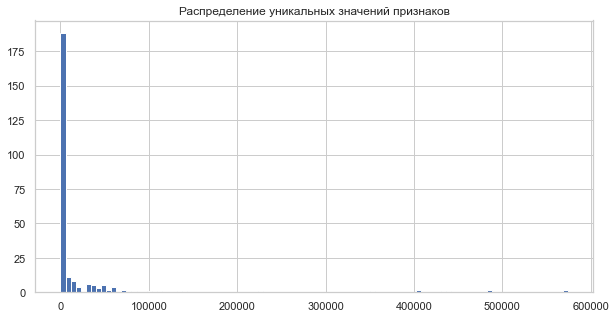

In [48]:
plt.title("Распределение уникальных значений признаков");
data_train_merge_nunique.hist(bins=100, figsize=(10, 5));

In [9]:
ALL_FEATURES = set(data_train_merge_nunique.index.tolist())
len(ALL_FEATURES)

257

## Константные признаки

In [10]:
CONST_FEATURES = set(data_train_merge_nunique[data_train_merge_nunique == 1].index.tolist())
len(CONST_FEATURES)

5

## Вещественные признаки

In [11]:
NUMERIC_FEATURES = (data_train_merge.drop('buy_time', axis=1).astype(int).sum() - data_train_merge.drop('buy_time', axis=1).sum()).abs()
NUMERIC_FEATURES = set(NUMERIC_FEATURES[NUMERIC_FEATURES > 0].index.tolist())
len(NUMERIC_FEATURES)

247

## Бинарные признаки

In [12]:
f_other = ALL_FEATURES - (NUMERIC_FEATURES | CONST_FEATURES)
len(f_other)

5

In [13]:
BINARY_FEATURES = set(data_train_merge.loc[:, f_other].columns[(
    (data_train_merge.loc[:, f_other].max() == 1) & \
    (data_train_merge.loc[:, f_other].min() == 0)
)])

len(BINARY_FEATURES), print(BINARY_FEATURES)

{'target'}


(1, None)

In [14]:
f_other = f_other - BINARY_FEATURES
len(f_other)

4

## Категориальные

In [15]:
CATEGORIES_FEATURES = set(data_train_merge_nunique.loc[f_other][data_train_merge_nunique.loc[f_other] <= 10].index.tolist())
print(CATEGORIES_FEATURES)

{'vas_id'}


In [16]:
f_other = f_other - CATEGORIES_FEATURES

## Признаки которые нас не интересуют 

In [17]:
DOESNT_INTERESTING_FEATURES = set(['buy_time', 'id'])

In [18]:
f_other = f_other - DOESNT_INTERESTING_FEATURES
f_other

{'252'}

In [18]:
data_train_merge['222'].unique()

array([ 9.7249728e+08,  9.6489408e+08,  9.6299328e+08,  9.6619008e+08,
        9.7344768e+08, -5.7266950e+08,  9.6031488e+08,  9.6135168e+08,
        9.5996928e+08,  9.7526208e+08,  9.6955968e+08,  9.6826368e+08,
        9.6800448e+08,  9.5893248e+08,  9.7085568e+08,  9.7059648e+08,
        9.6739968e+08,  9.7508928e+08,  9.7171968e+08,  9.6981888e+08,
        9.7353408e+08,  9.6264768e+08,  9.5953728e+08,  9.7042368e+08,
        9.7362048e+08,  9.6195648e+08,  9.7310208e+08,  9.7284288e+08,
        9.6973248e+08,  9.6921408e+08,  9.6126528e+08,  9.7206528e+08,
        9.6696768e+08,  9.7163328e+08,  9.6307968e+08,  9.6515328e+08,
        9.6878208e+08,  9.7137408e+08,  9.7465728e+08,  9.7405248e+08,
        9.6342528e+08,  9.6765888e+08,  9.5841408e+08,  9.6091968e+08,
        9.6014208e+08,  9.7267008e+08,  9.6437568e+08,  9.6333888e+08,
        9.6558528e+08,  9.7223808e+08,  9.6843648e+08,  9.6498048e+08,
        9.7327488e+08,  9.6368448e+08,  9.7586688e+08,  9.7215168e+08,
      

In [19]:
NUMERIC_FEATURES = NUMERIC_FEATURES | f_other

In [20]:
f_other = f_other - NUMERIC_FEATURES
len(f_other)

0

In [21]:
data_train_merge_nunique.shape[0] == len(CONST_FEATURES) + len(BINARY_FEATURES) + len(NUMERIC_FEATURES) + len(CATEGORIES_FEATURES) + len(DOESNT_INTERESTING_FEATURES)

True

# EDA

In [21]:
# пропусков нет
data_train_merge.isna().sum().sum()

0

## Распределение данныех на train и test

### Распределение числовых признаков

In [23]:
def compare_test_train_distribution(column_list: list, 
                                    train_df: pd.DataFrame, 
                                    test_df: pd.DataFrame,
                                    pvalue=0.05,
                                    show_only_different=True) -> None:
    """Function for calculate differense between distribution train and test data using criterion 
    Mann-Whitneyu 

    Input:
    ------
        column_list (list): numeric column list
        train_df (pd.DataFrame): train data frame
        test_df (pd.DataFrame): test data frame
        pvalue (float, optional): Pvalue to decide defferent destribution between train and test
        or not. Defaults to 0.05.
        show_only_different (bool, optional): If set True it will show only defferent plots. 
        Defaults to True.
    """
    
    def show_figures(col, pvalue):
        plt.figure(figsize=(10, 5))
        sns.set(font_scale=0.8)
        sns.kdeplot(train_df[col], shade=True, label='train', color='g')
        sns.kdeplot(test_df[col], shade=True, label='test', color='orange')
        plt.legend()
        plt.title(f'Column name is {col}. ' + f'Pvalues is {pvalue}')
        plt.show()
    

    for col in tqdm(column_list):
        
        calculated_pvalue = mannwhitneyu(train_df[col],test_df[col]).pvalue
        if show_only_different:
            if calculated_pvalue < pvalue: show_figures(col=col, pvalue=calculated_pvalue)
        else:
            show_figures(col=col, pvalue=pvalue)
            
        

  4%|▎         | 9/248 [00:03<01:41,  2.35it/s]

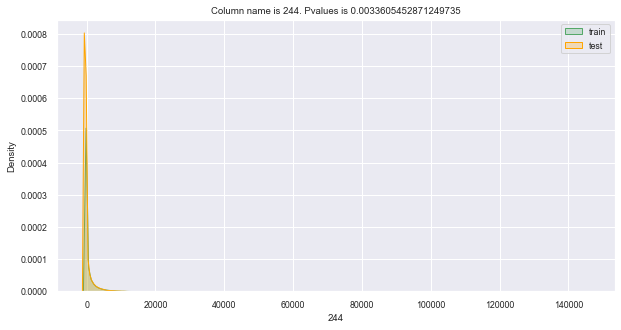

 12%|█▏        | 30/248 [00:26<01:40,  2.18it/s]

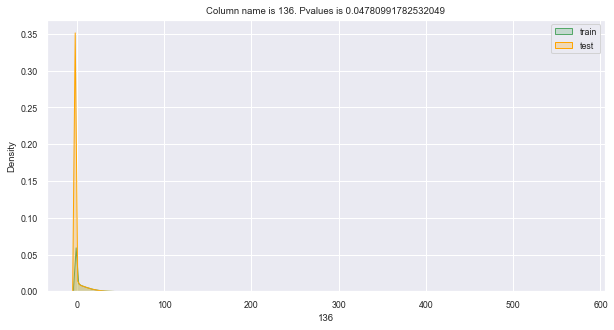

 15%|█▍        | 37/248 [00:42<03:10,  1.11it/s]

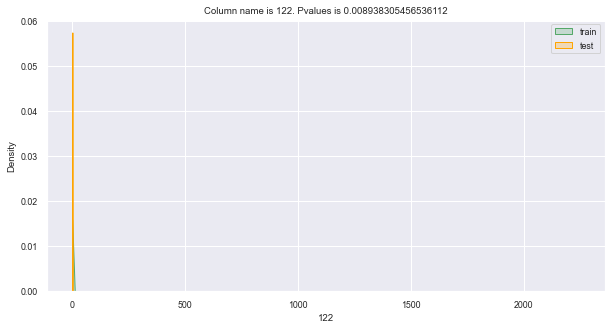

 15%|█▌        | 38/248 [00:56<17:00,  4.86s/it]

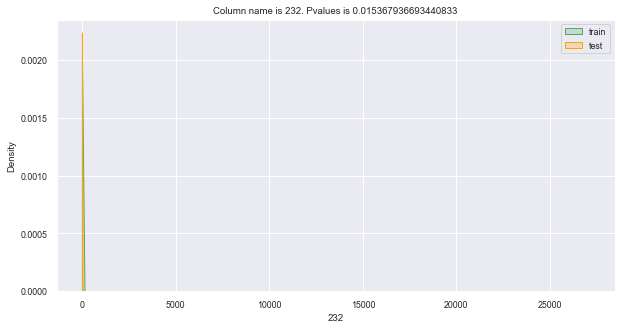

 17%|█▋        | 43/248 [01:12<07:21,  2.15s/it]

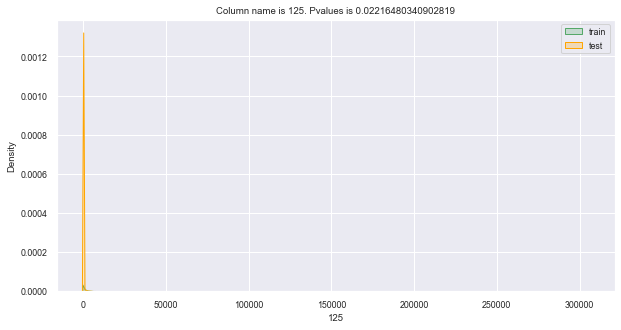

 18%|█▊        | 44/248 [01:26<19:10,  5.64s/it]

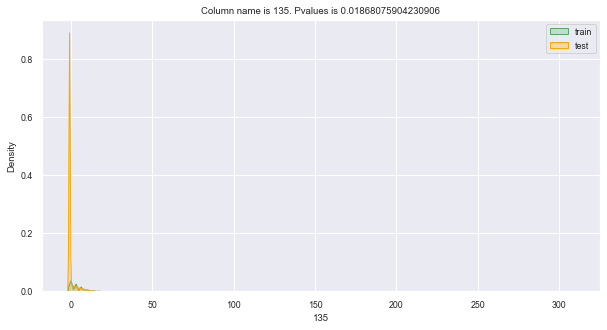

 30%|███       | 75/248 [01:53<01:19,  2.18it/s]

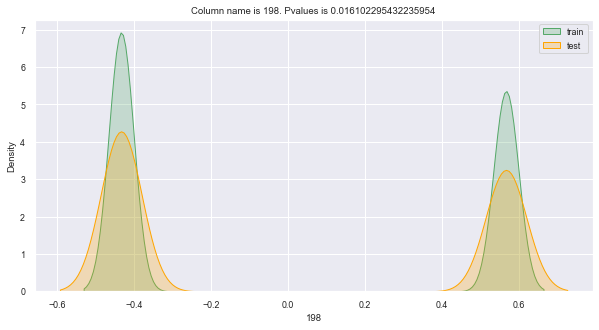

 40%|████      | 100/248 [02:07<01:07,  2.18it/s]

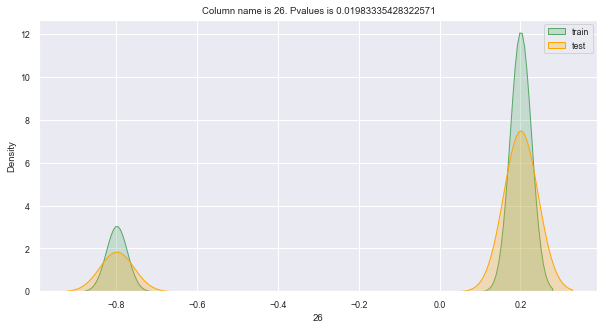

 41%|████      | 101/248 [02:11<03:37,  1.48s/it]

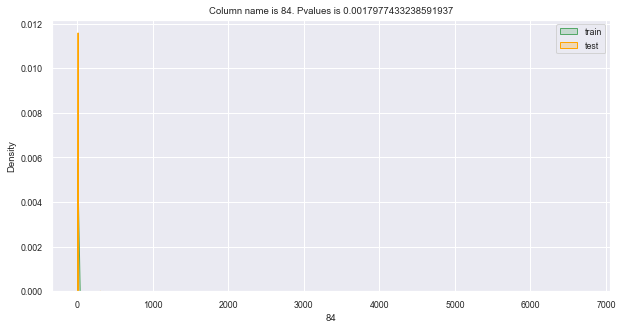

 48%|████▊     | 119/248 [02:33<00:59,  2.18it/s]

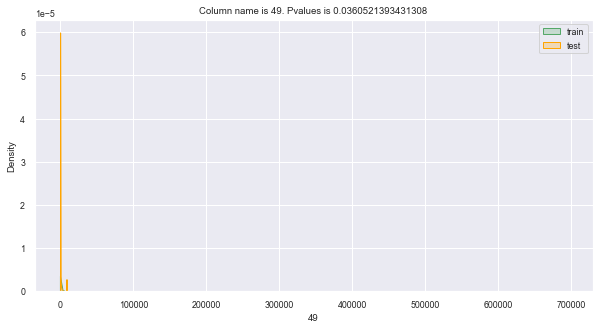

 53%|█████▎    | 131/248 [02:52<01:06,  1.76it/s]

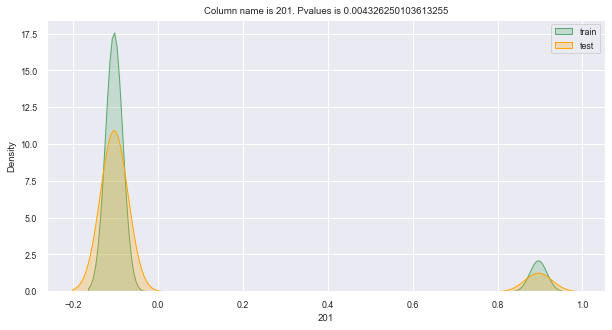

 66%|██████▌   | 163/248 [03:12<00:37,  2.28it/s]

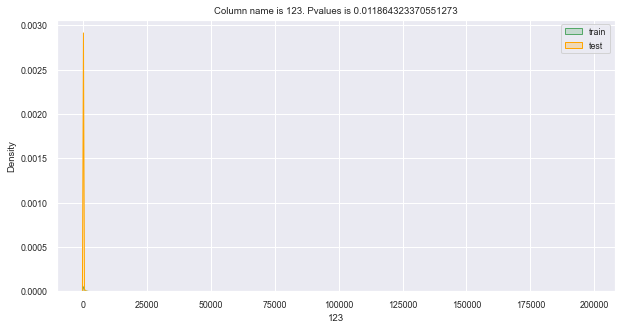

 68%|██████▊   | 168/248 [03:28<01:53,  1.42s/it]

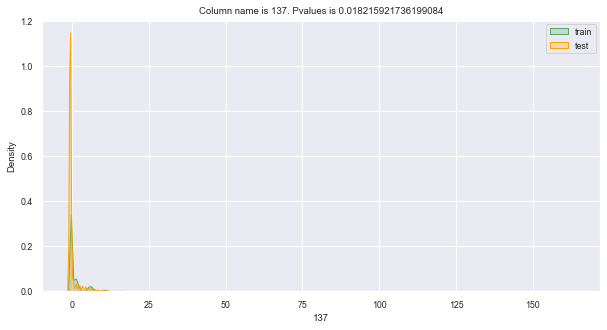

 73%|███████▎  | 181/248 [03:47<00:32,  2.04it/s]

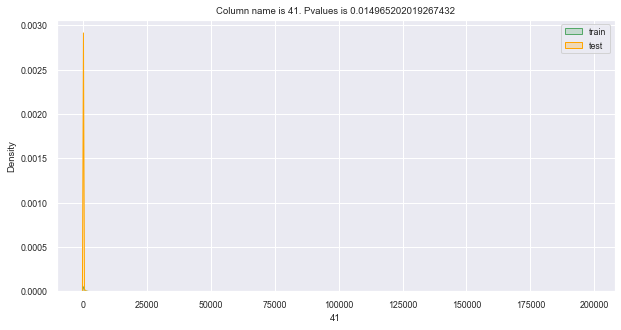

 76%|███████▌  | 189/248 [04:04<00:45,  1.29it/s]

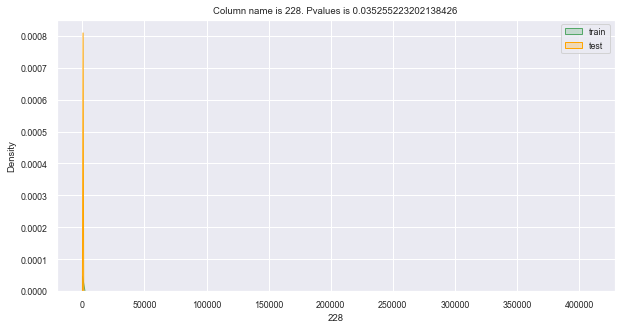

 91%|█████████ | 226/248 [04:34<00:09,  2.21it/s]

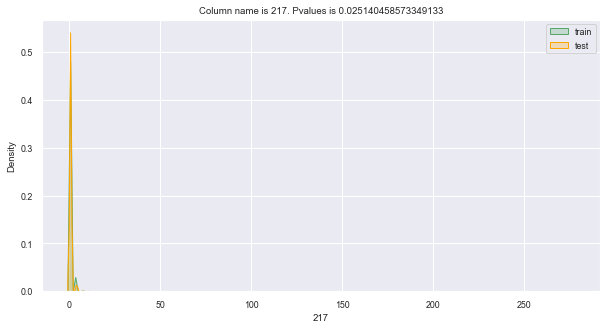

 97%|█████████▋| 241/248 [04:56<00:04,  1.73it/s]

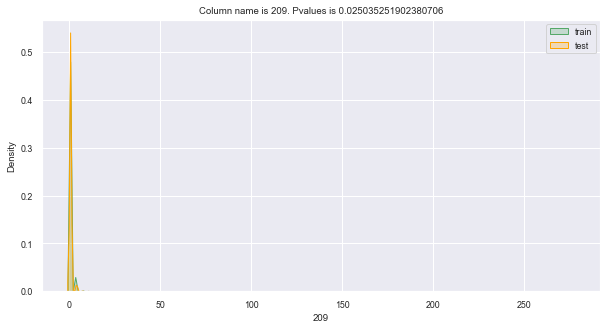

100%|█████████▉| 247/248 [05:12<00:01,  1.15s/it]

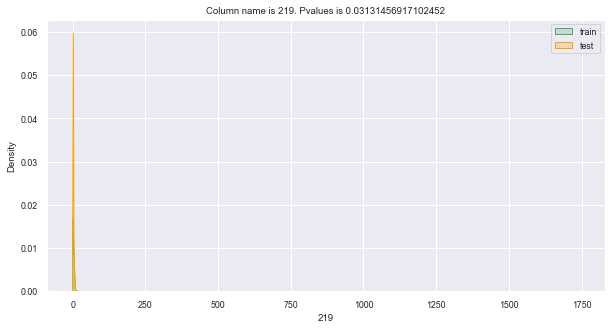

100%|██████████| 248/248 [05:27<00:00,  1.32s/it]


In [106]:
compare_test_train_distribution(
    column_list=list(NUMERIC_FEATURES), 
    train_df=data_train_merge, 
    test_df=data_test_merge)


Вывод: У фитчей № 244, 136, 122, 232, 125, 135, 198, 26, 84, 49, 201, 123, 137, 41, 228, 217, 209, 219 статистически значимые различия в распределении на train и test. Имеет смысл их удалить

## Корреляции признаков с целевой переменной

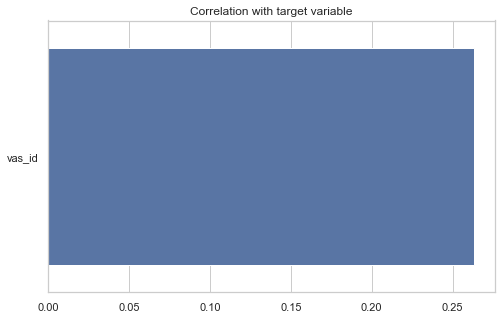

In [28]:
corr_with_target = data_train_merge[list(ALL_FEATURES - DOESNT_INTERESTING_FEATURES)].corr(
)[TARGET_COLUMN_NAME].drop(TARGET_COLUMN_NAME).sort_values(ascending=False)

plt.figure(figsize=(8, 5))

# выберим признаки со значительной линейной коррелицией
mask = (corr_with_target > 0.2) | (corr_with_target < -0.2)
sns.barplot(x=corr_with_target[mask].values,
            y=corr_with_target[mask].index)

plt.title('Correlation with target variable')
plt.show()

#### Вывод: Данные линейно практически не коллерируют с таргетом

## Целевая переменная 

Количество позитивных меток = 60186.0
Количество негативных меток = 771467.0
Коэффициент равномерности распределения данных = 0.07236912510385943


<AxesSubplot:>

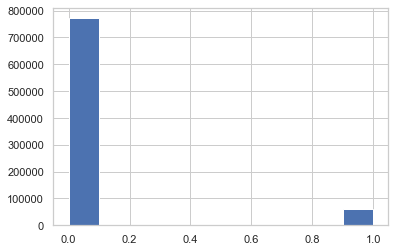

In [29]:
ones_count = data_train_merge[TARGET_COLUMN_NAME].sum()
total_count = data_train_merge[TARGET_COLUMN_NAME].shape[0]
zeros_count = total_count - ones_count

print('Количество позитивных меток = {}'.format(ones_count))
print('Количество негативных меток = {}'.format(zeros_count))
print('Коэффициент равномерности распределения данных = {}'.format(
    ones_count / total_count))

data_train_merge[TARGET_COLUMN_NAME].hist()

#### Вывод: Данные неравномерны 

## Количественные переменные

In [25]:
data_train_merge[list(NUMERIC_FEATURES)].describe()

,208,37,73,126,9,47,79,154,159,108,...,60,121,84,99,4,158,216,66,179,150
count,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,12.972519,0.343460,0.011801,0.000073,0.332336,-0.280706,0.173476,0.000016,0.000019,0.087092,...,-0.000519,-0.006783,-0.007923,-0.050720,0.262964,0.004070,0.000279,-0.000911,0.000294,0.000166
std,137097.750000,1590.553833,57.298271,0.139617,197.115601,259.924194,234.689133,0.031400,0.194779,47.396652,...,0.322516,24.279921,11.734588,993.139954,318.515625,5.452070,0.278560,0.421427,0.193391,0.259114
min,-45175.257812,-192.026962,-5.390212,-0.058077,-767.286560,-451.259430,-0.998268,-0.000044,-0.061481,-11.955315,...,-0.265234,-0.433135,-0.134088,-42.275913,-2657.258301,-0.536315,-0.000083,-0.044465,-0.001431,-0.143269
25%,-45175.257812,-192.026962,-5.390212,-0.058077,-30.006538,-7.997875,-0.998268,-0.000044,-0.061481,-11.955315,...,-0.265234,-0.433135,-0.134088,-42.275913,-116.158249,-0.536315,-0.000083,-0.044465,-0.001431,-0.143269
50%,-45175.257812,-192.026962,-5.390212,-0.058077,-30.006538,-7.997875,-0.998268,-0.000044,-0.061481,-11.955315,...,-0.185234,-0.433135,-0.134088,-42.275913,-87.608246,-0.536315,-0.000083,-0.044465,-0.001431,-0.143269
75%,-45175.257812,-22.026958,-5.390212,-0.018077,-30.006538,-7.300417,-0.998268,-0.000044,-0.061481,-8.955315,...,0.254766,-0.433135,-0.134088,-42.275913,29.161755,-0.536315,-0.000083,-0.044465,-0.001431,0.056731
max,818824.750000,776776.000000,28373.230469,0.941923,88505.125000,104989.898438,211826.515625,27.999956,0.938519,5440.724609,...,0.734766,6468.024902,6711.855957,214834.828125,212095.265625,943.463684,249.999924,51.255535,100.998566,0.856731


  0%|          | 0/248 [00:00<?, ?it/s]

--------------------------------------------------
                     208
--------------------------------------------------
99 quantile is 397423.5499999984


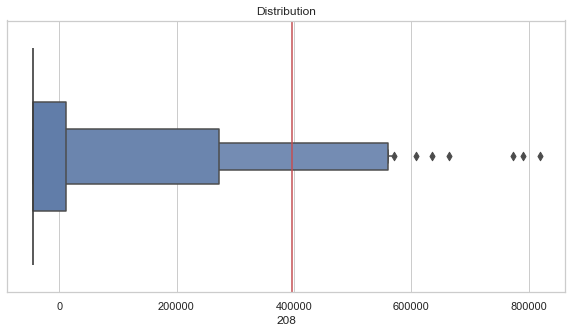

  0%|          | 1/248 [00:00<01:37,  2.53it/s]

--------------------------------------------------
                     37
--------------------------------------------------
99 quantile is 557.9730224609375


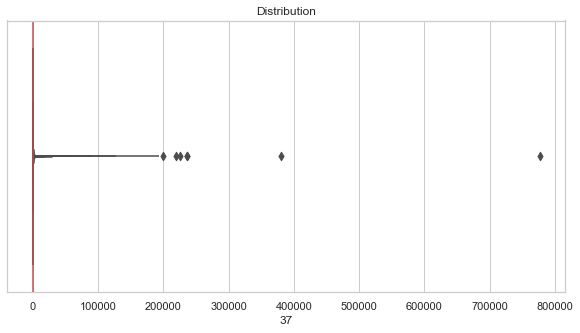

  1%|          | 2/248 [00:00<01:29,  2.75it/s]

--------------------------------------------------
                     73
--------------------------------------------------
99 quantile is -5.390211582183838


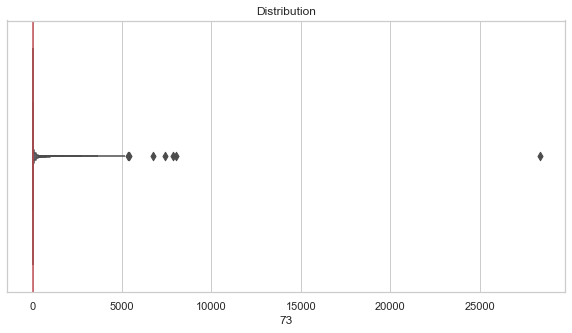

  1%|          | 3/248 [00:00<01:15,  3.22it/s]

--------------------------------------------------
                     126
--------------------------------------------------
99 quantile is 0.2919228971004486


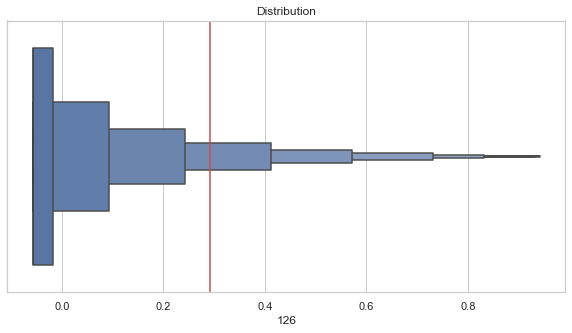

  2%|▏         | 4/248 [00:01<01:10,  3.44it/s]

--------------------------------------------------
                     9
--------------------------------------------------
99 quantile is 166.3217529296857


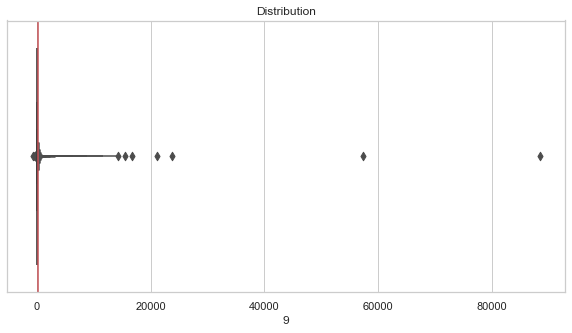

  2%|▏         | 5/248 [00:01<01:09,  3.50it/s]

--------------------------------------------------
                     47
--------------------------------------------------
99 quantile is -0.7240416288376499


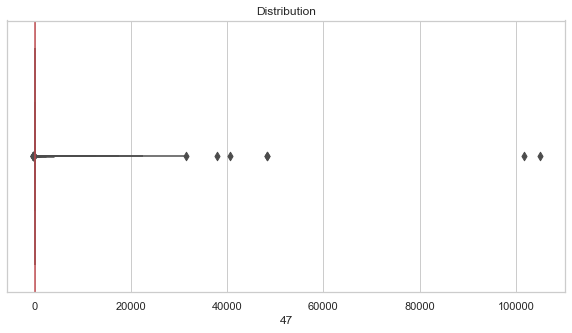

  2%|▏         | 6/248 [00:01<01:11,  3.40it/s]

--------------------------------------------------
                     79
--------------------------------------------------
99 quantile is -0.9982677102088928


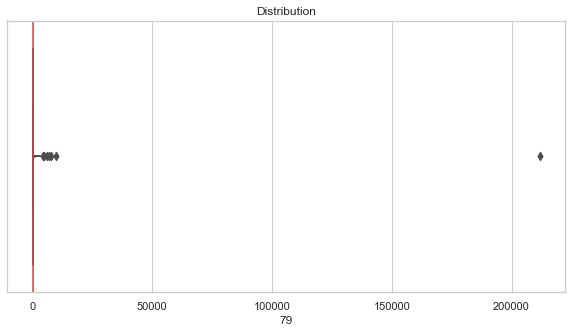

  3%|▎         | 7/248 [00:02<01:03,  3.82it/s]

--------------------------------------------------
                     154
--------------------------------------------------
99 quantile is -4.365624045021832e-05


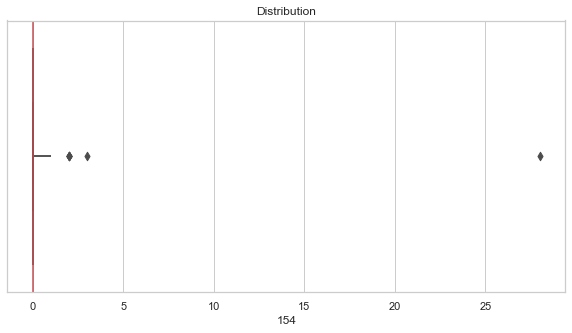

  3%|▎         | 8/248 [00:02<00:59,  4.02it/s]

--------------------------------------------------
                     159
--------------------------------------------------
99 quantile is 0.5085188150405884


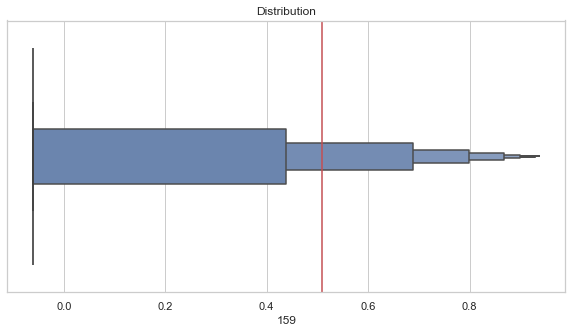

  4%|▎         | 9/248 [00:02<01:00,  3.97it/s]

--------------------------------------------------
                     108
--------------------------------------------------
99 quantile is 52.87468719482422


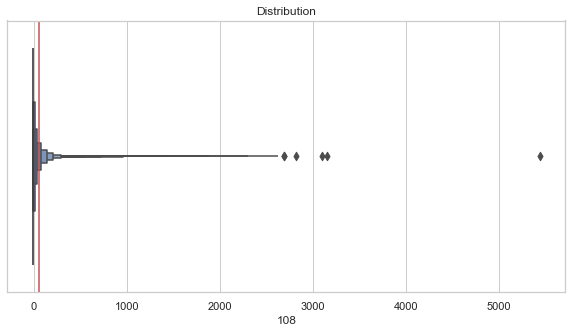

  4%|▍         | 10/248 [00:02<01:04,  3.72it/s]

--------------------------------------------------
                     131
--------------------------------------------------
99 quantile is 1.426716923713684


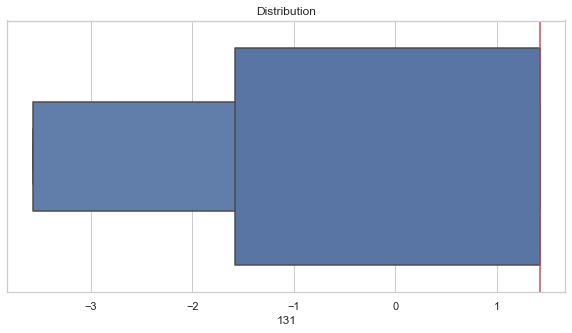

  4%|▍         | 11/248 [00:03<01:11,  3.32it/s]

--------------------------------------------------
                     127
--------------------------------------------------
99 quantile is 0.24954941868782043


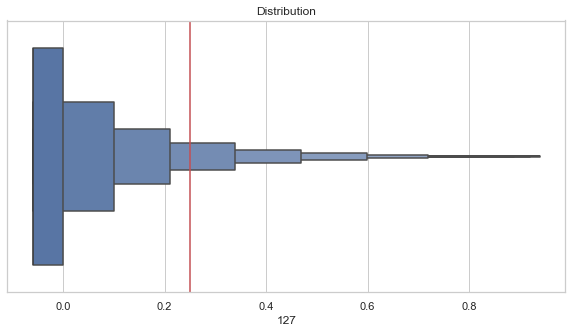

  5%|▍         | 12/248 [00:03<01:10,  3.36it/s]

--------------------------------------------------
                     234
--------------------------------------------------
99 quantile is 137.64349365234375


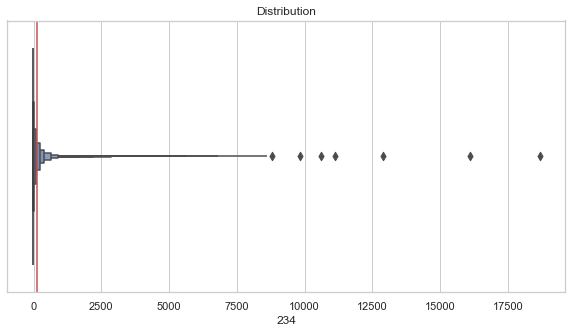

  5%|▌         | 13/248 [00:03<01:09,  3.37it/s]

--------------------------------------------------
                     177
--------------------------------------------------
99 quantile is -0.0031490109395235777


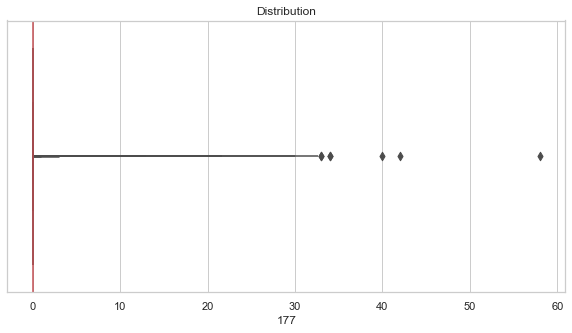

  6%|▌         | 14/248 [00:04<01:05,  3.55it/s]

--------------------------------------------------
                     161
--------------------------------------------------
99 quantile is -0.0025951284915208817


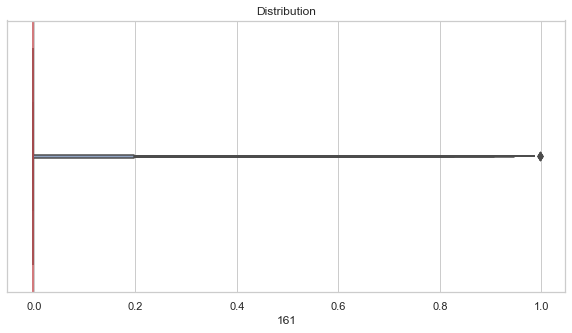

  6%|▌         | 15/248 [00:04<01:03,  3.67it/s]

--------------------------------------------------
                     173
--------------------------------------------------
99 quantile is -0.028856772929430008


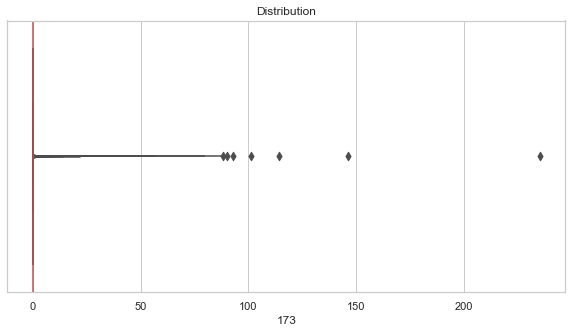

  6%|▋         | 16/248 [00:04<01:00,  3.84it/s]

--------------------------------------------------
                     199
--------------------------------------------------
Unique values is  [-7.0758566e-04  9.9929243e-01]
99 quantile is -0.000707585655618459


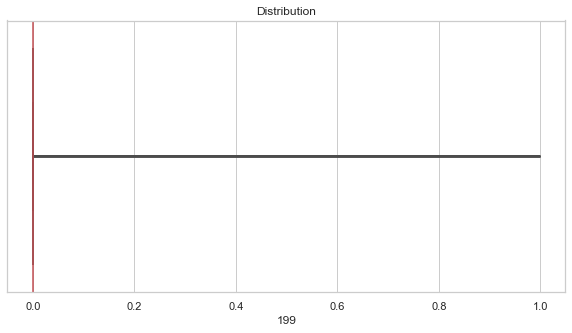

  7%|▋         | 17/248 [00:04<01:03,  3.63it/s]

--------------------------------------------------
                     133
--------------------------------------------------
99 quantile is 0.5827168226242065


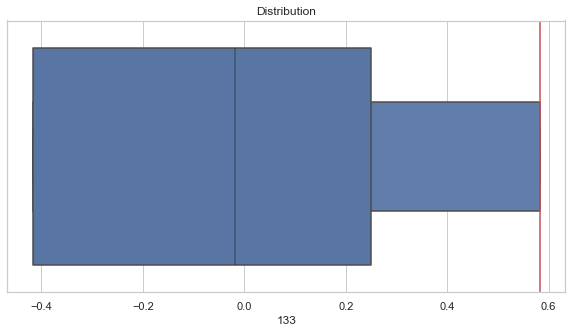

  7%|▋         | 18/248 [00:05<01:08,  3.37it/s]

--------------------------------------------------
                     2
--------------------------------------------------
99 quantile is 381.0692138671875


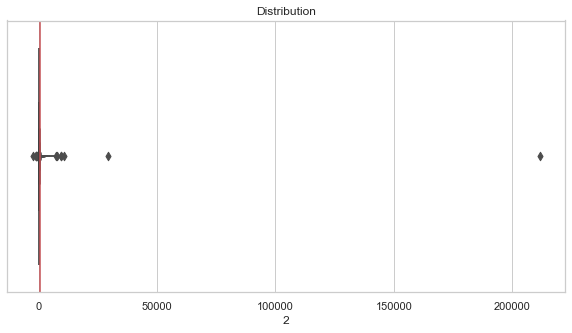

  8%|▊         | 19/248 [00:05<01:09,  3.30it/s]

--------------------------------------------------
                     195
--------------------------------------------------
Unique values is  [-0.22810584  0.77189416]
99 quantile is 0.7718941569328308


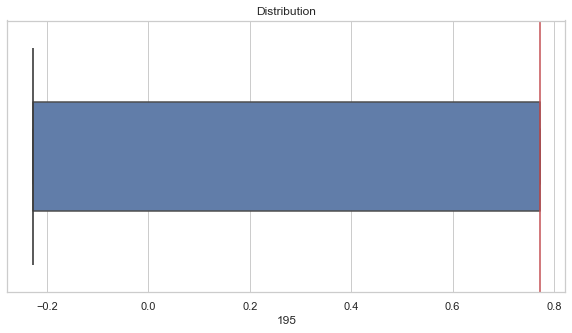

  8%|▊         | 20/248 [00:05<01:08,  3.31it/s]

--------------------------------------------------
                     61
--------------------------------------------------
99 quantile is 0.4418378174304962


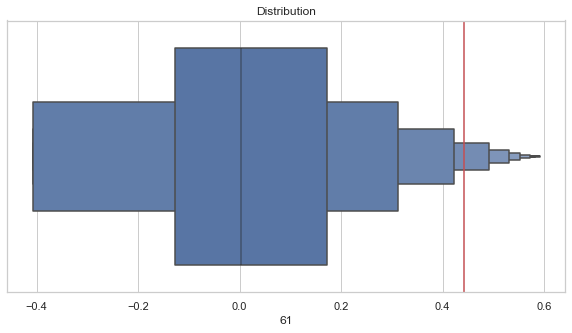

  8%|▊         | 21/248 [00:06<01:12,  3.12it/s]

--------------------------------------------------
                     51
--------------------------------------------------
99 quantile is 91.9110107421875


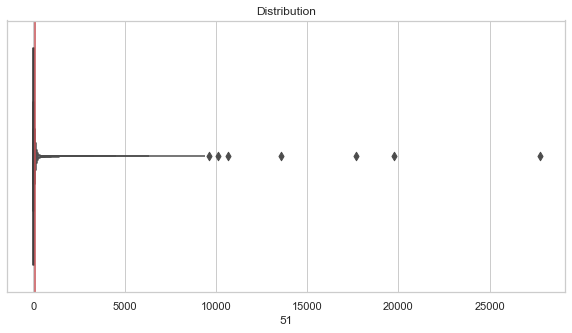

  9%|▉         | 22/248 [00:06<01:13,  3.06it/s]

--------------------------------------------------
                     229
--------------------------------------------------
99 quantile is 904.8710327148438


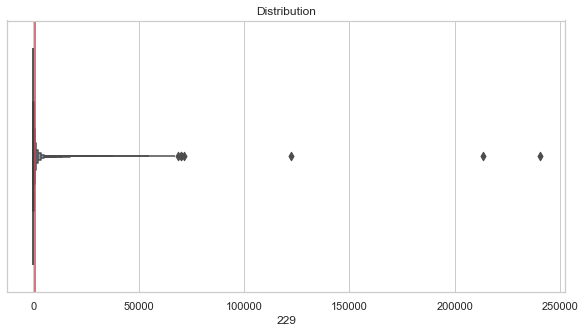

  9%|▉         | 23/248 [00:06<01:12,  3.09it/s]

--------------------------------------------------
                     101
--------------------------------------------------
99 quantile is -0.25303715467453003


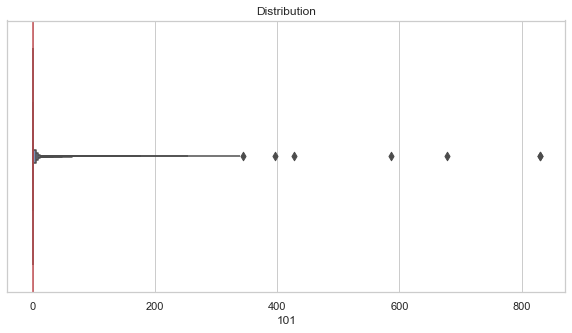

 10%|▉         | 24/248 [00:07<01:06,  3.38it/s]

--------------------------------------------------
                     148
--------------------------------------------------
99 quantile is 0.5128359794616699


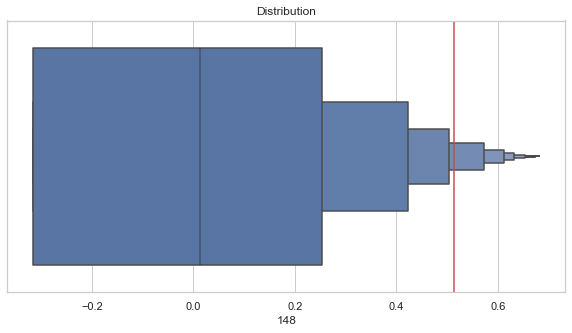

 10%|█         | 25/248 [00:07<01:08,  3.23it/s]

--------------------------------------------------
                     175
--------------------------------------------------
99 quantile is -0.019197886809706688


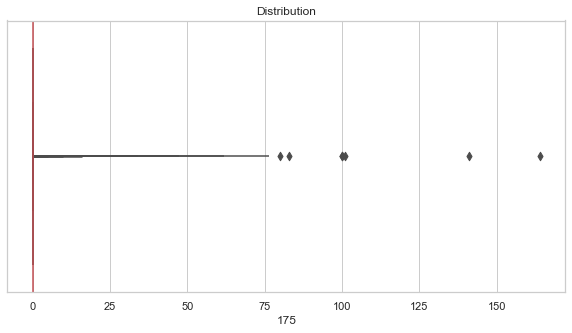

 10%|█         | 26/248 [00:07<01:04,  3.45it/s]

--------------------------------------------------
                     100
--------------------------------------------------
99 quantile is -3.950157403945923


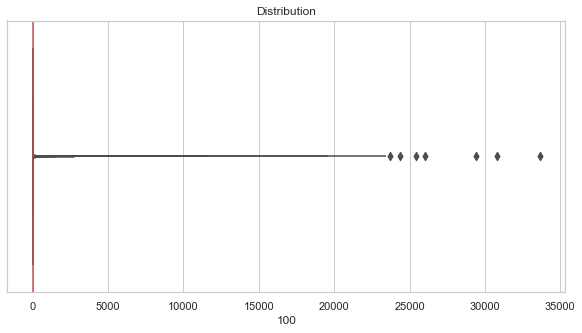

 11%|█         | 27/248 [00:07<01:00,  3.67it/s]

--------------------------------------------------
                     27
--------------------------------------------------
Unique values is  [-0.00909047  0.9909095 ]
99 quantile is -0.009090470150113106


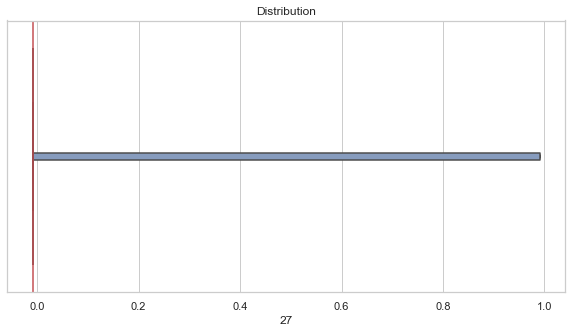

 11%|█▏        | 28/248 [00:08<00:59,  3.69it/s]

--------------------------------------------------
                     185
--------------------------------------------------
99 quantile is 72.02188110351562


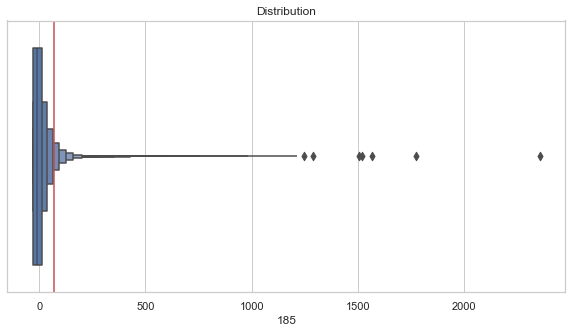

 12%|█▏        | 29/248 [00:08<01:02,  3.50it/s]

--------------------------------------------------
                     232
--------------------------------------------------
99 quantile is -0.1337713599205017


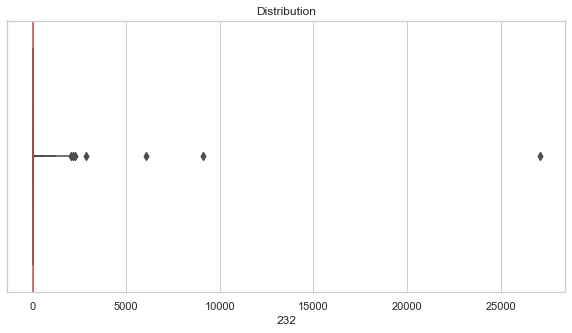

 12%|█▏        | 30/248 [00:08<01:06,  3.27it/s]

--------------------------------------------------
                     151
--------------------------------------------------
99 quantile is 79.58232879638672


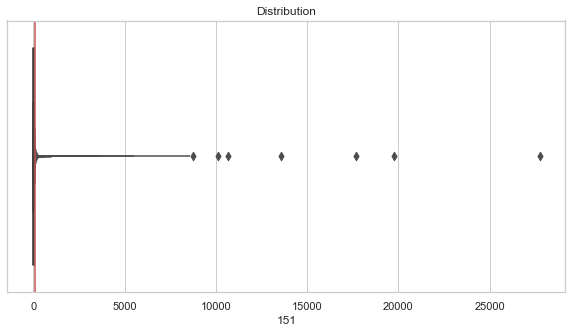

 12%|█▎        | 31/248 [00:09<01:11,  3.05it/s]

--------------------------------------------------
                     190
--------------------------------------------------
99 quantile is -0.1631840318441391


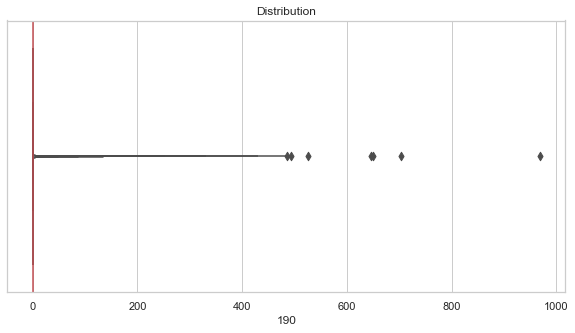

 13%|█▎        | 32/248 [00:09<01:03,  3.39it/s]

--------------------------------------------------
                     113
--------------------------------------------------
99 quantile is 7109.959179687492


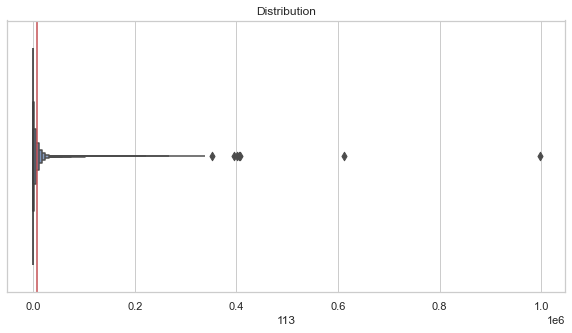

 13%|█▎        | 33/248 [00:09<01:05,  3.27it/s]

--------------------------------------------------
                     132
--------------------------------------------------
Unique values is  [ 0.5315575  -0.46844253]
99 quantile is 0.5315575003623962


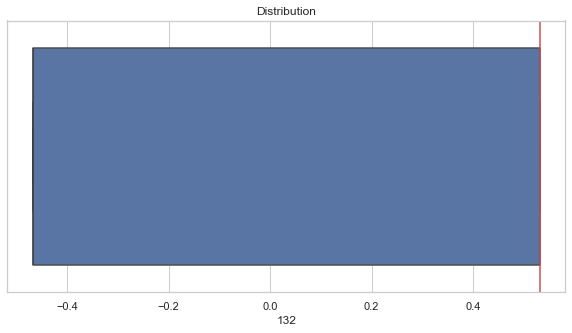

 14%|█▎        | 34/248 [00:09<01:03,  3.35it/s]

--------------------------------------------------
                     201
--------------------------------------------------
Unique values is  [-0.10466528  0.8953347 ]
99 quantile is 0.8953347206115723


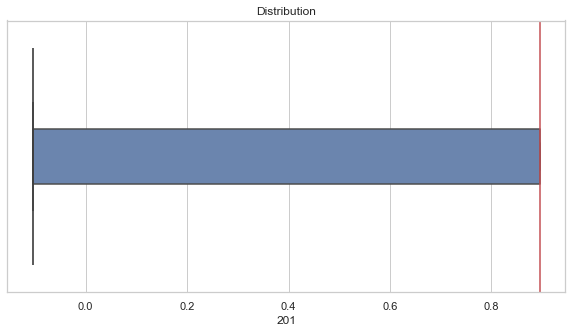

 14%|█▍        | 35/248 [00:10<01:03,  3.37it/s]

--------------------------------------------------
                     74
--------------------------------------------------
99 quantile is -4.022547245025635


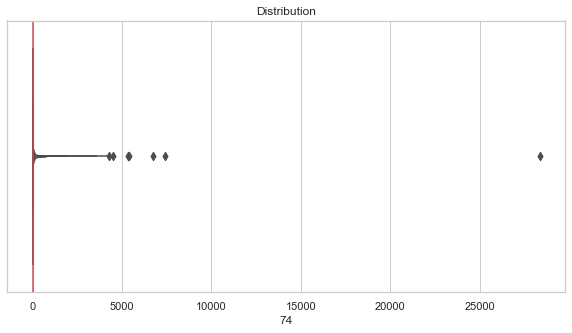

 15%|█▍        | 36/248 [00:10<00:59,  3.55it/s]

--------------------------------------------------
                     119
--------------------------------------------------
99 quantile is -0.08972006291151047


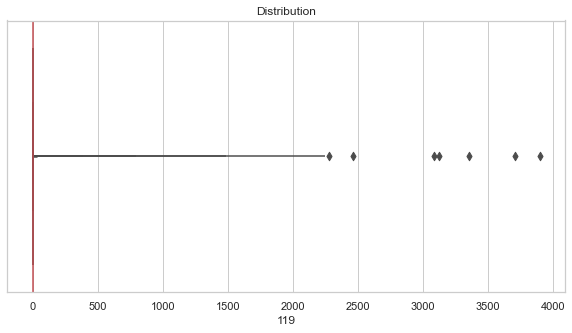

 15%|█▍        | 37/248 [00:10<00:56,  3.72it/s]

--------------------------------------------------
                     112
--------------------------------------------------
99 quantile is 4634.406249999982


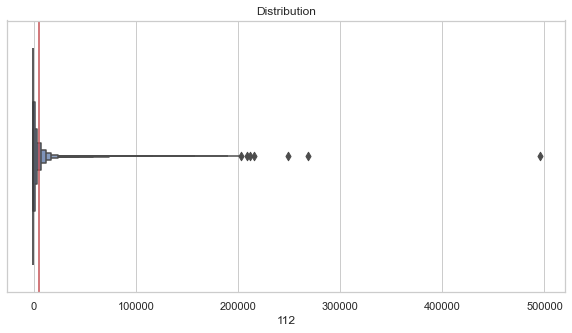

 15%|█▌        | 38/248 [00:11<01:03,  3.33it/s]

--------------------------------------------------
                     138
--------------------------------------------------
99 quantile is 11.06401252746582


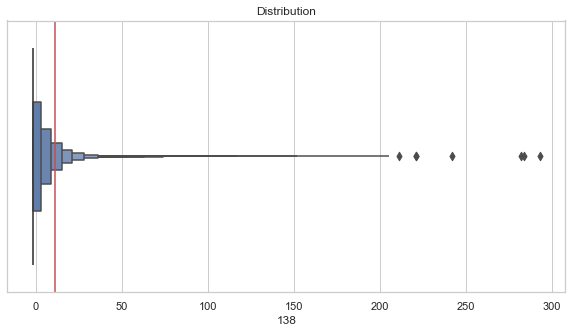

 16%|█▌        | 39/248 [00:11<01:00,  3.48it/s]

--------------------------------------------------
                     250
--------------------------------------------------
99 quantile is 34.824066162109375


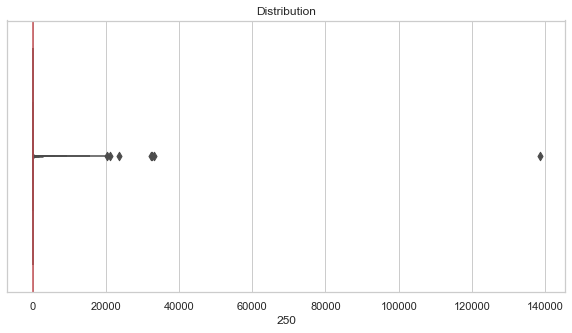

 16%|█▌        | 40/248 [00:11<01:01,  3.40it/s]

--------------------------------------------------
                     30
--------------------------------------------------
99 quantile is 0.7883917689323425


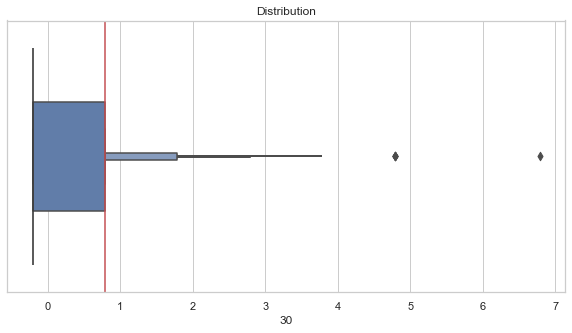

 17%|█▋        | 41/248 [00:12<01:01,  3.39it/s]

--------------------------------------------------
                     233
--------------------------------------------------
99 quantile is 0.7905318140983582


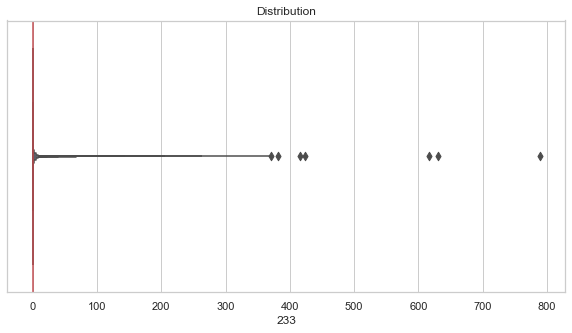

 17%|█▋        | 42/248 [00:12<00:58,  3.49it/s]

--------------------------------------------------
                     69
--------------------------------------------------
99 quantile is -0.036834120750427246


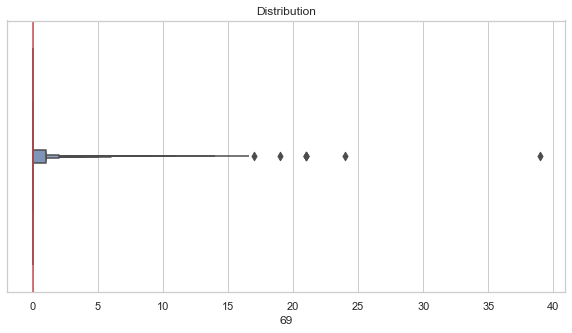

 17%|█▋        | 43/248 [00:12<00:58,  3.49it/s]

--------------------------------------------------
                     239
--------------------------------------------------
99 quantile is 380.59027099609375


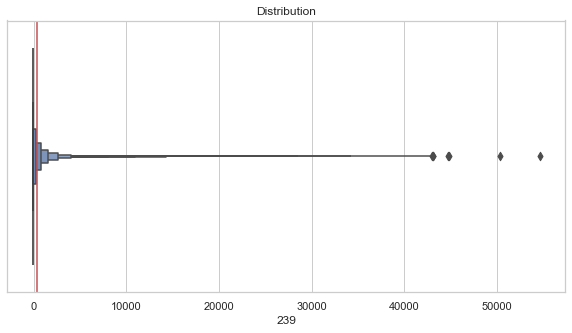

 18%|█▊        | 44/248 [00:12<00:58,  3.50it/s]

--------------------------------------------------
                     241
--------------------------------------------------
99 quantile is 393.38201904296875


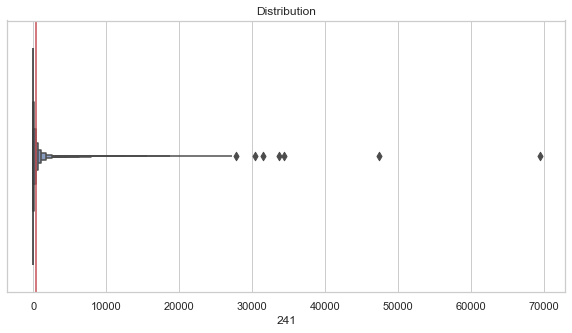

 18%|█▊        | 45/248 [00:13<01:02,  3.23it/s]

--------------------------------------------------
                     80
--------------------------------------------------
99 quantile is -0.20323233306407928


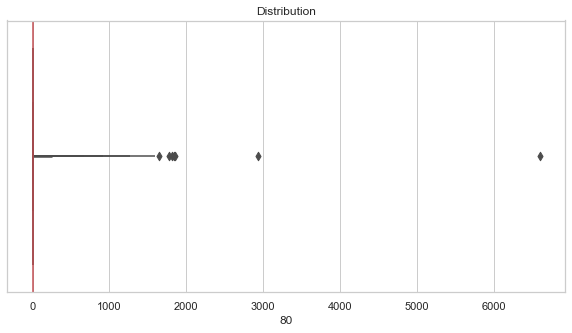

 19%|█▊        | 46/248 [00:13<00:58,  3.46it/s]

--------------------------------------------------
                     194
--------------------------------------------------
Unique values is  [-0.6237371   0.37626293]
99 quantile is 0.37626293301582336


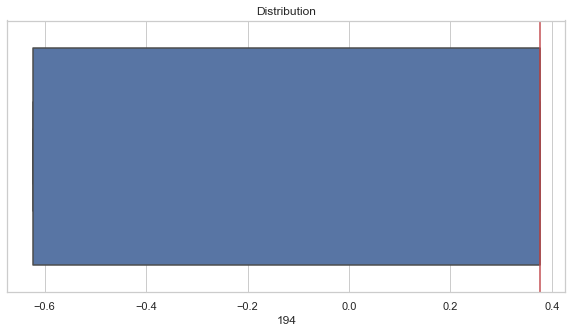

 19%|█▉        | 47/248 [00:13<00:58,  3.43it/s]

--------------------------------------------------
                     221
--------------------------------------------------
99 quantile is -0.10787767171859741


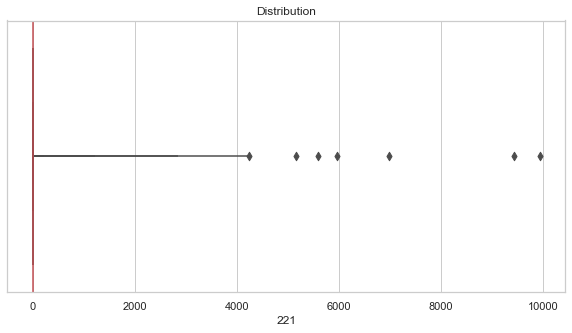

 19%|█▉        | 48/248 [00:14<01:01,  3.24it/s]

--------------------------------------------------
                     184
--------------------------------------------------
99 quantile is 6.675237083435059


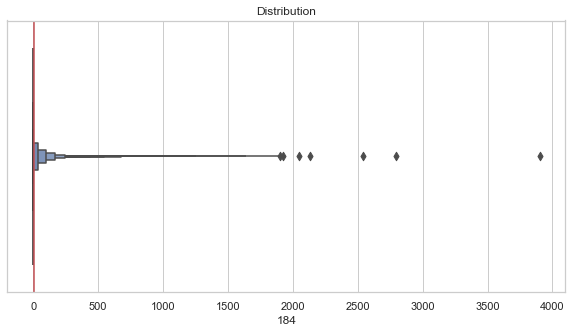

 20%|█▉        | 49/248 [00:14<00:58,  3.39it/s]

--------------------------------------------------
                     214
--------------------------------------------------
99 quantile is -9239.70703125


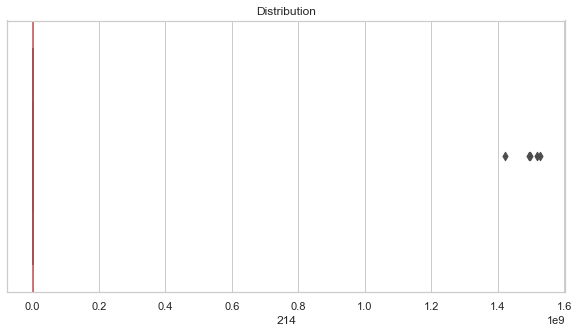

 20%|██        | 50/248 [00:14<00:57,  3.44it/s]

--------------------------------------------------
                     196
--------------------------------------------------
Unique values is  [-0.25195876  0.7480412 ]
99 quantile is 0.7480412125587463


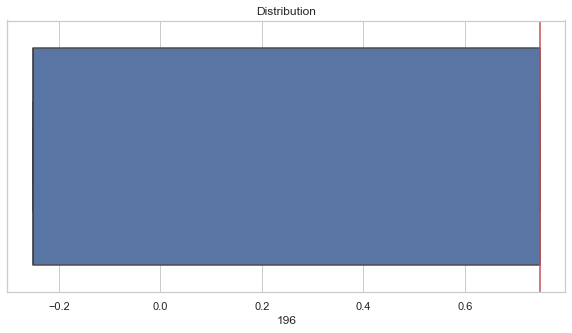

 21%|██        | 51/248 [00:14<00:57,  3.44it/s]

--------------------------------------------------
                     50
--------------------------------------------------
99 quantile is 80.86971282958984


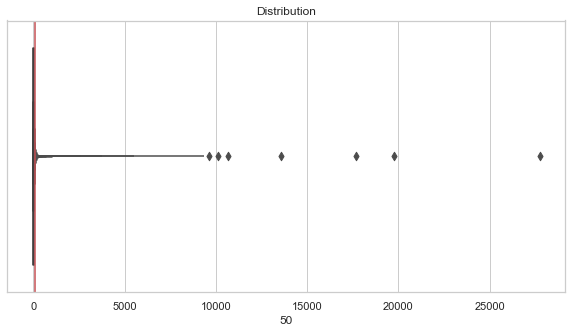

 21%|██        | 52/248 [00:15<01:00,  3.25it/s]

--------------------------------------------------
                     211
--------------------------------------------------
99 quantile is -61736.325


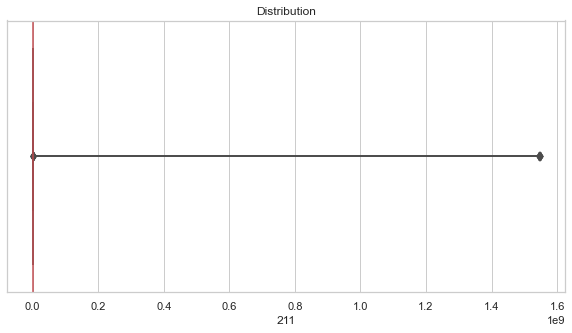

 21%|██▏       | 53/248 [00:15<01:00,  3.22it/s]

--------------------------------------------------
                     71
--------------------------------------------------
99 quantile is -2.7835915088653564


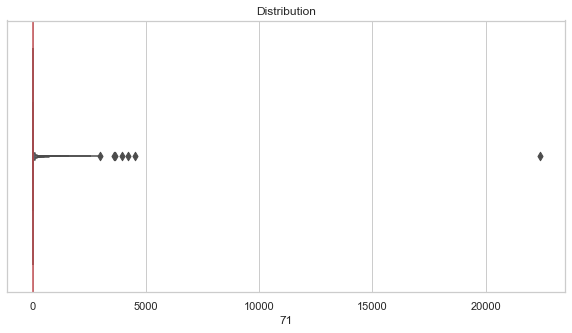

 22%|██▏       | 54/248 [00:15<00:54,  3.53it/s]

--------------------------------------------------
                     156
--------------------------------------------------
99 quantile is 9.451144218444824


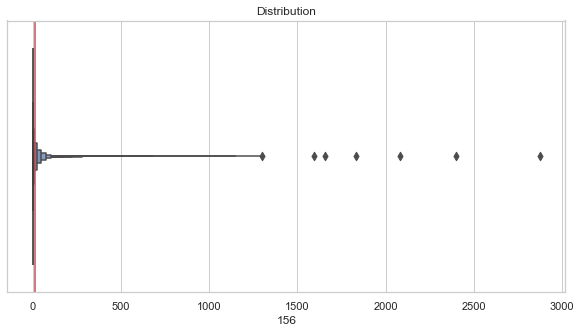

 22%|██▏       | 55/248 [00:16<00:53,  3.59it/s]

--------------------------------------------------
                     188
--------------------------------------------------
99 quantile is 114.9796371459961


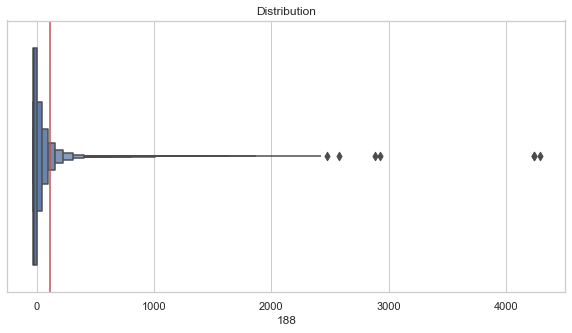

 23%|██▎       | 56/248 [00:16<00:58,  3.29it/s]

--------------------------------------------------
                     29
--------------------------------------------------
99 quantile is 0.7856336832046509


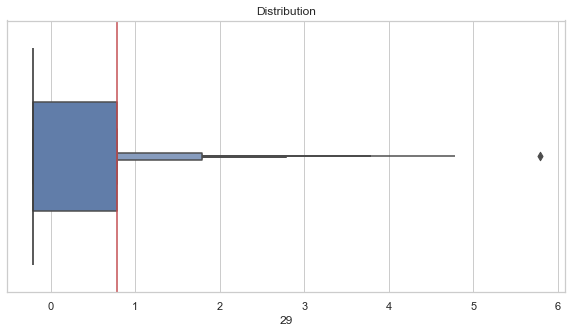

 23%|██▎       | 57/248 [00:16<00:55,  3.44it/s]

--------------------------------------------------
                     251
--------------------------------------------------
99 quantile is 0.543860137462616


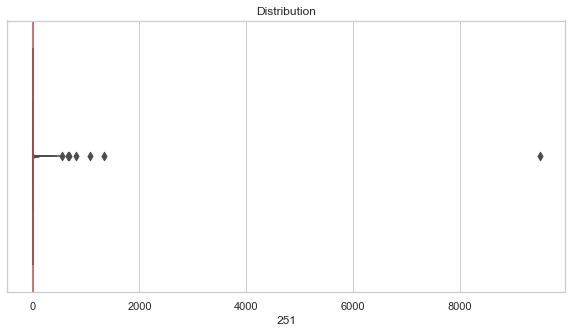

 23%|██▎       | 58/248 [00:16<00:51,  3.69it/s]

--------------------------------------------------
                     89
--------------------------------------------------
99 quantile is -0.6797739863395691


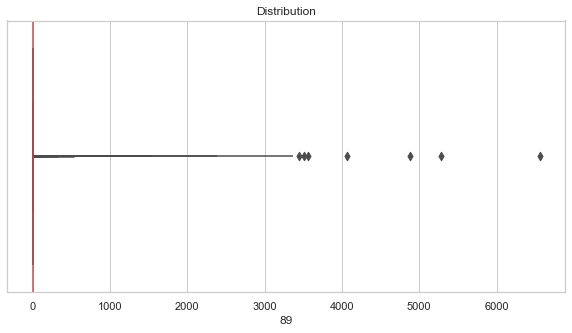

 24%|██▍       | 59/248 [00:17<00:51,  3.69it/s]

--------------------------------------------------
                     160
--------------------------------------------------
99 quantile is 0.6478431820869446


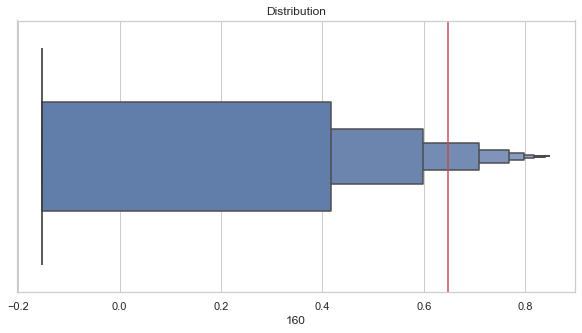

 24%|██▍       | 60/248 [00:17<00:49,  3.80it/s]

--------------------------------------------------
                     120
--------------------------------------------------
99 quantile is -0.27887824177742004


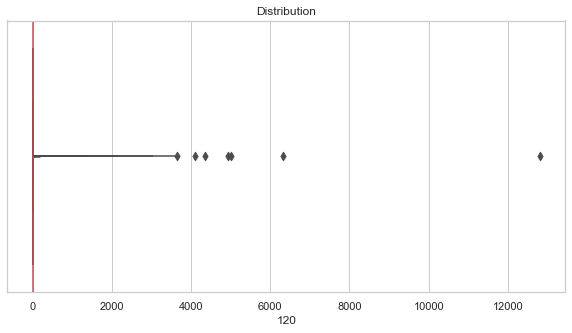

 25%|██▍       | 61/248 [00:17<00:49,  3.76it/s]

--------------------------------------------------
                     22
--------------------------------------------------
99 quantile is -0.0942513719201088


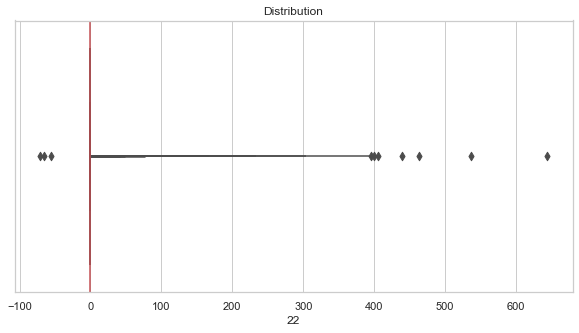

 25%|██▌       | 62/248 [00:17<00:47,  3.88it/s]

--------------------------------------------------
                     91
--------------------------------------------------
99 quantile is -0.6919123530387878


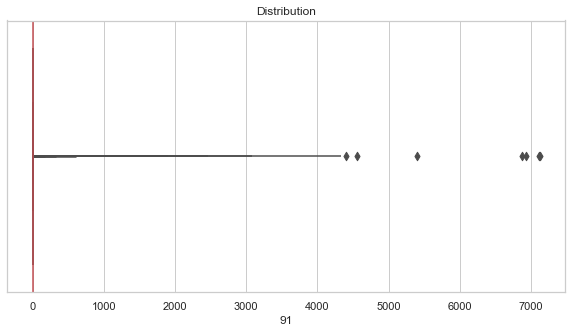

 25%|██▌       | 63/248 [00:18<00:47,  3.91it/s]

--------------------------------------------------
                     94
--------------------------------------------------
99 quantile is -0.5987155437469482


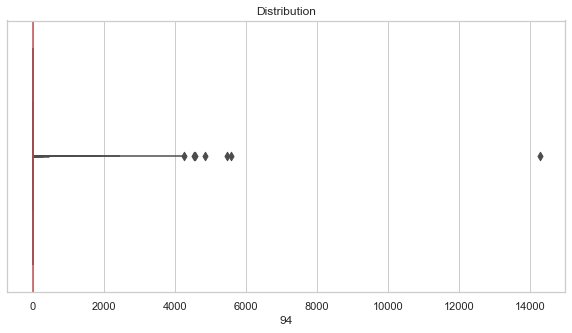

 26%|██▌       | 64/248 [00:18<00:45,  4.02it/s]

--------------------------------------------------
                     95
--------------------------------------------------
Unique values is  [-1.1458987e-04  6.1459885e+01  6.3598852e+00  1.2709886e+01]
99 quantile is -0.00011458987137302756


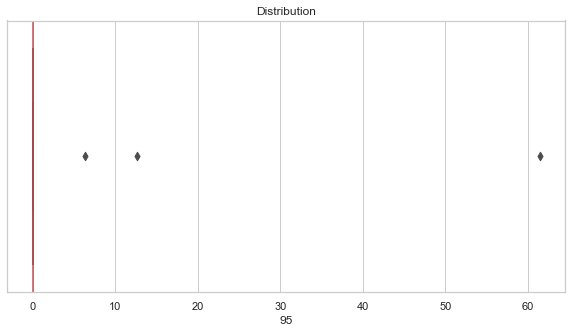

 26%|██▌       | 65/248 [00:18<00:44,  4.09it/s]

--------------------------------------------------
                     104
--------------------------------------------------
99 quantile is 13.51241683959961


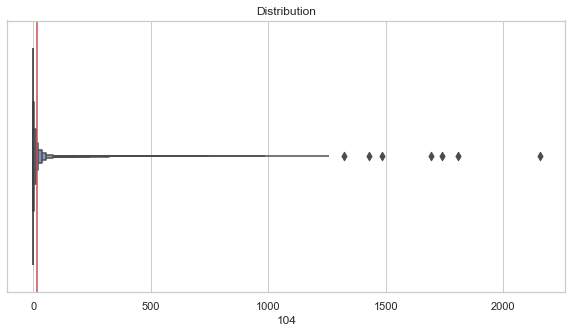

 27%|██▋       | 66/248 [00:19<00:56,  3.23it/s]

--------------------------------------------------
                     168
--------------------------------------------------
99 quantile is 159.51516723632812


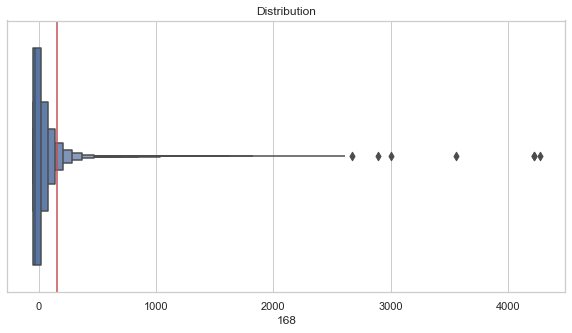

 27%|██▋       | 67/248 [00:19<00:59,  3.05it/s]

--------------------------------------------------
                     170
--------------------------------------------------
99 quantile is 139.82110595703125


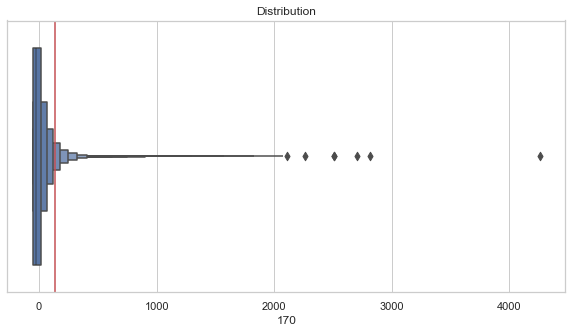

 27%|██▋       | 68/248 [00:19<01:00,  2.96it/s]

--------------------------------------------------
                     189
--------------------------------------------------
99 quantile is -0.03456931561231613


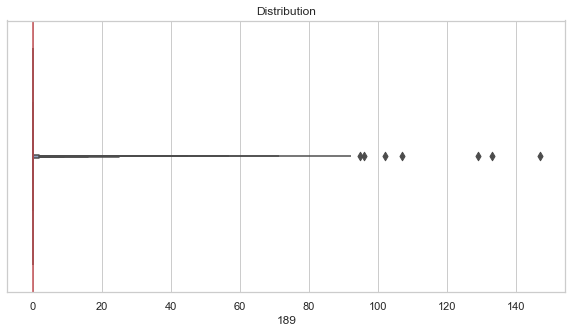

 28%|██▊       | 69/248 [00:20<00:54,  3.26it/s]

--------------------------------------------------
                     105
--------------------------------------------------
99 quantile is -0.0400429293513298


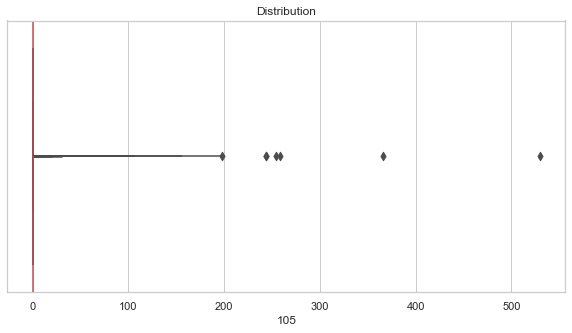

 28%|██▊       | 70/248 [00:20<00:50,  3.50it/s]

--------------------------------------------------
                     77
--------------------------------------------------
99 quantile is 40.79356384277344


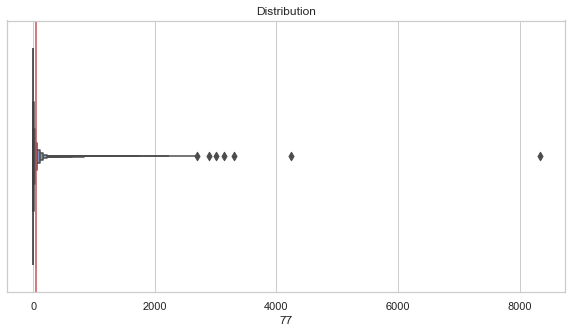

 29%|██▊       | 71/248 [00:20<00:55,  3.21it/s]

--------------------------------------------------
                     225
--------------------------------------------------
99 quantile is 1349415577.6


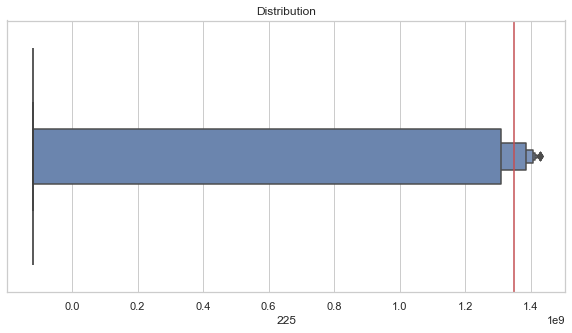

 29%|██▉       | 72/248 [00:20<00:52,  3.36it/s]

--------------------------------------------------
                     1
--------------------------------------------------
99 quantile is 584.2808837890625


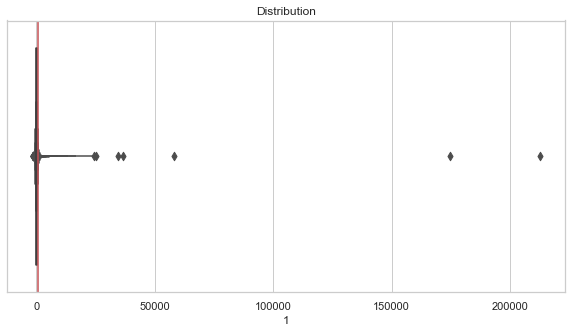

 29%|██▉       | 73/248 [00:21<00:56,  3.09it/s]

--------------------------------------------------
                     236
--------------------------------------------------
99 quantile is 3491.30908203125


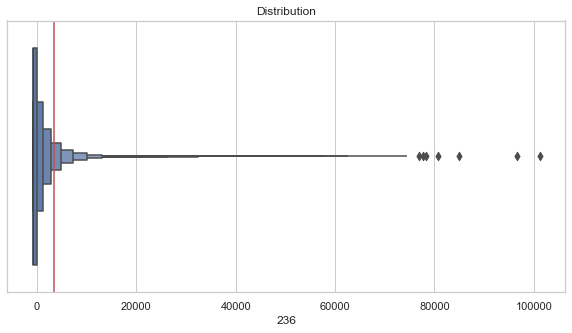

 30%|██▉       | 74/248 [00:21<00:58,  2.99it/s]

--------------------------------------------------
                     192
--------------------------------------------------
Unique values is  [-0.46668276  0.53331727]
99 quantile is 0.5333172678947449


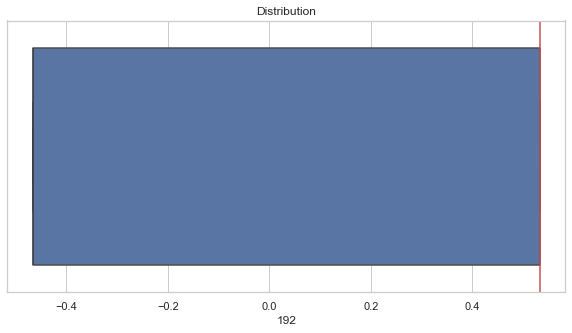

 30%|███       | 75/248 [00:22<00:56,  3.04it/s]

--------------------------------------------------
                     117
--------------------------------------------------
99 quantile is 8642.134374999985


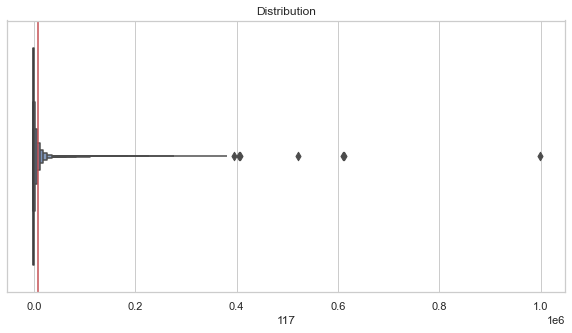

 31%|███       | 76/248 [00:22<00:58,  2.94it/s]

--------------------------------------------------
                     86
--------------------------------------------------
99 quantile is -0.030537161976099014


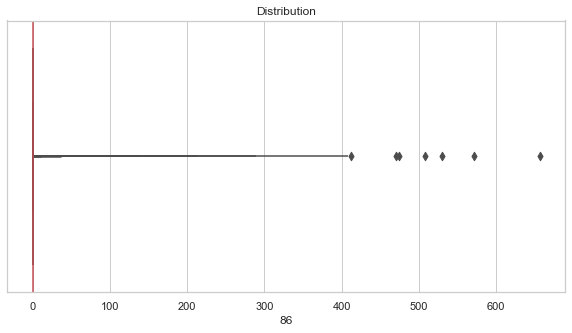

 31%|███       | 77/248 [00:22<00:52,  3.25it/s]

--------------------------------------------------
                     222
--------------------------------------------------
99 quantile is 973447680.0


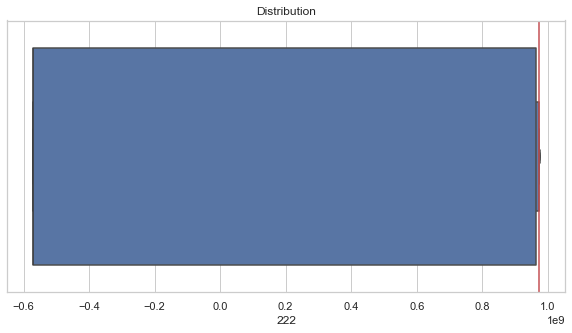

 31%|███▏      | 78/248 [00:22<00:51,  3.32it/s]

--------------------------------------------------
                     147
--------------------------------------------------
99 quantile is 12.13853931427002


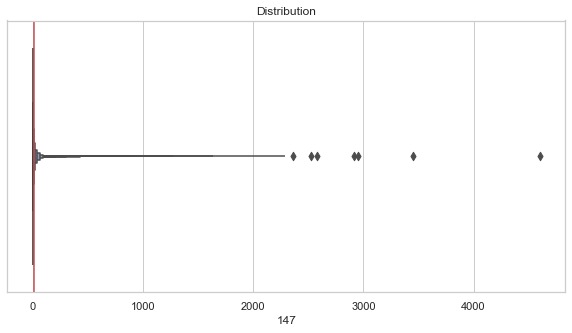

 32%|███▏      | 79/248 [00:23<00:51,  3.30it/s]

--------------------------------------------------
                     178
--------------------------------------------------
99 quantile is -0.005184134002774954


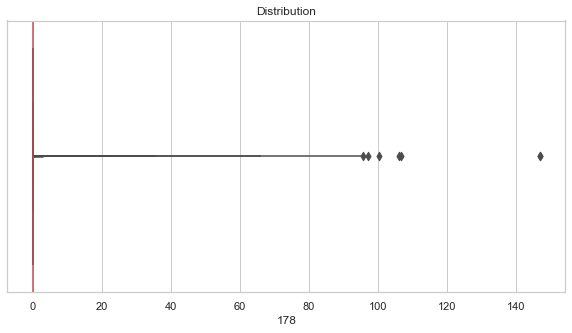

 32%|███▏      | 80/248 [00:23<00:47,  3.57it/s]

--------------------------------------------------
                     90
--------------------------------------------------
99 quantile is -0.6269847750663757


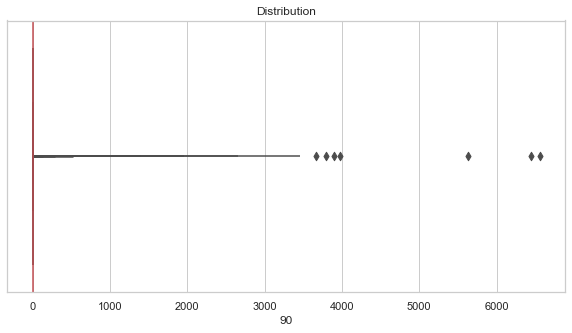

 33%|███▎      | 81/248 [00:23<00:44,  3.78it/s]

--------------------------------------------------
                     227
--------------------------------------------------
99 quantile is 2.534809112548828


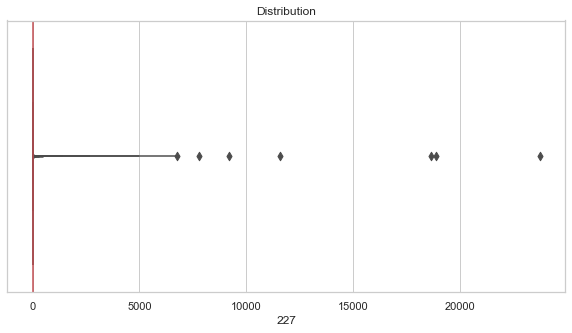

 33%|███▎      | 82/248 [00:23<00:43,  3.86it/s]

--------------------------------------------------
                     35
--------------------------------------------------
99 quantile is -0.06558294594287872


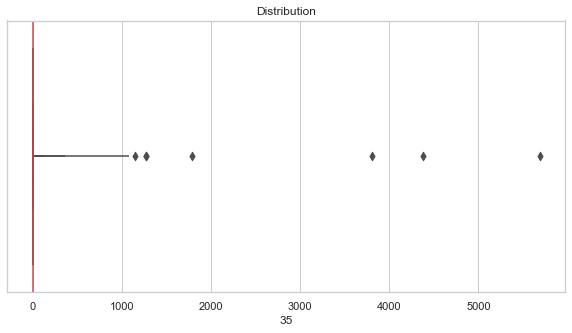

 33%|███▎      | 83/248 [00:24<00:43,  3.82it/s]

--------------------------------------------------
                     125
--------------------------------------------------
99 quantile is -100.3004150390625


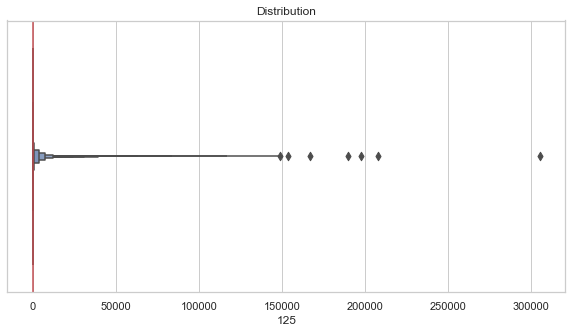

 34%|███▍      | 84/248 [00:24<00:43,  3.76it/s]

--------------------------------------------------
                     212
--------------------------------------------------
99 quantile is 0.7568636536598206


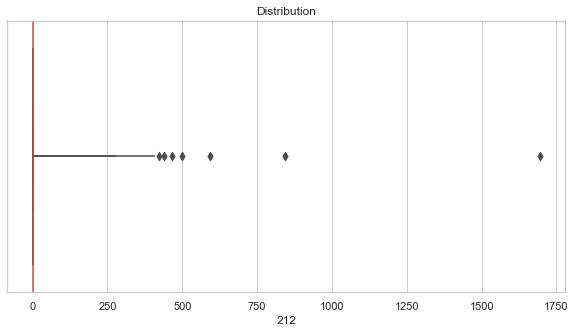

 34%|███▍      | 85/248 [00:24<00:50,  3.24it/s]

--------------------------------------------------
                     118
--------------------------------------------------
99 quantile is -0.34341511130332947


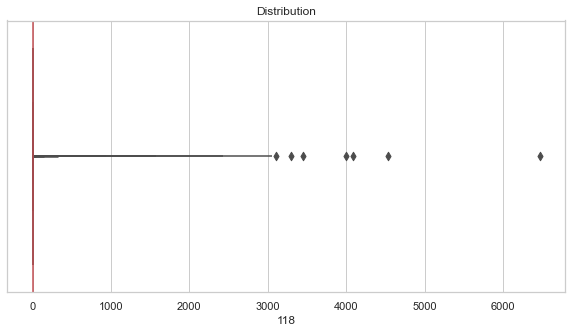

 35%|███▍      | 86/248 [00:25<00:45,  3.52it/s]

--------------------------------------------------
                     67
--------------------------------------------------
99 quantile is 0.6988723278045654


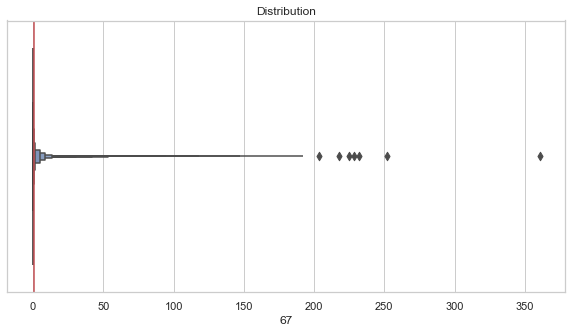

 35%|███▌      | 87/248 [00:25<00:47,  3.42it/s]

--------------------------------------------------
                     249
--------------------------------------------------
99 quantile is 1.3055715560913086


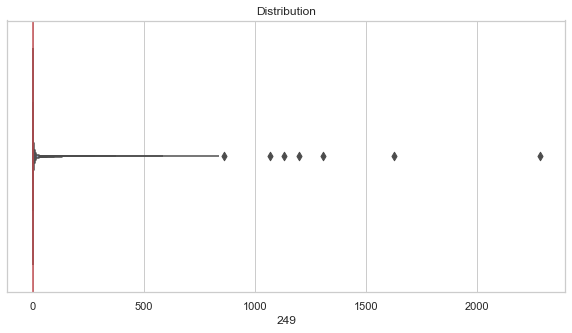

 35%|███▌      | 88/248 [00:25<00:43,  3.66it/s]

--------------------------------------------------
                     62
--------------------------------------------------
99 quantile is 0.11835561692714691


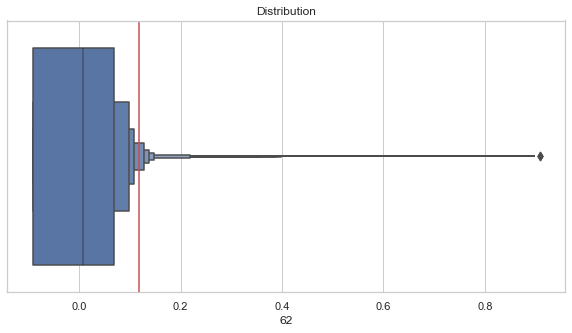

 36%|███▌      | 89/248 [00:26<00:47,  3.38it/s]

--------------------------------------------------
                     169
--------------------------------------------------
99 quantile is 57.03877258300781


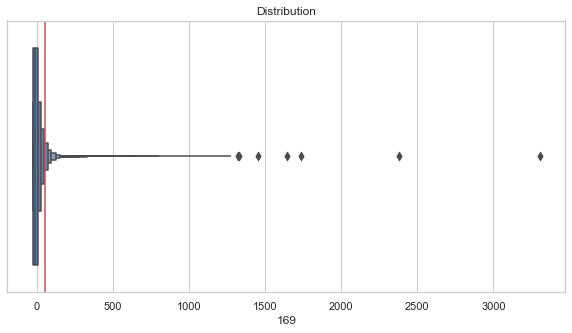

 36%|███▋      | 90/248 [00:26<00:50,  3.15it/s]

--------------------------------------------------
                     65
--------------------------------------------------
99 quantile is -0.028453895822167397


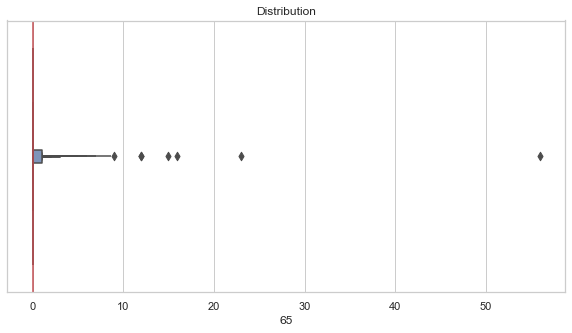

 37%|███▋      | 91/248 [00:26<00:47,  3.33it/s]

--------------------------------------------------
                     21
--------------------------------------------------
99 quantile is 30.765836715698242


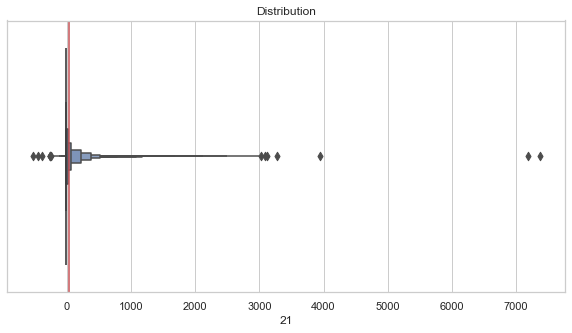

 37%|███▋      | 92/248 [00:26<00:46,  3.39it/s]

--------------------------------------------------
                     228
--------------------------------------------------
99 quantile is -27.30238151550293


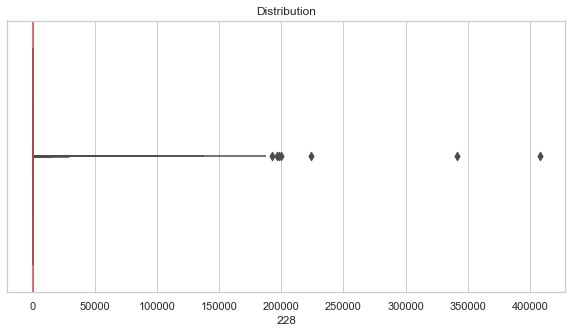

 38%|███▊      | 93/248 [00:27<00:46,  3.37it/s]

--------------------------------------------------
                     43
--------------------------------------------------
99 quantile is 286.25465087890626


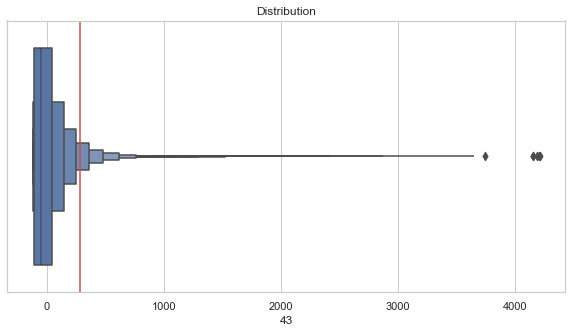

 38%|███▊      | 94/248 [00:27<00:49,  3.11it/s]

--------------------------------------------------
                     230
--------------------------------------------------
99 quantile is 151.22750854492188


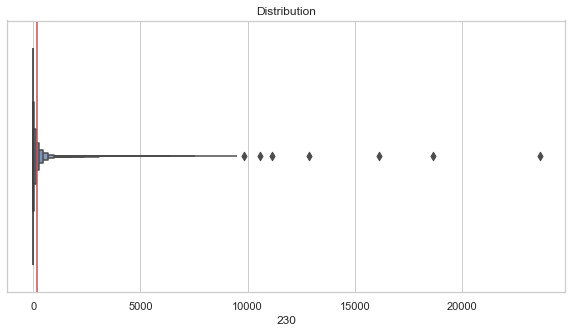

 38%|███▊      | 95/248 [00:27<00:50,  3.02it/s]

--------------------------------------------------
                     19
--------------------------------------------------
99 quantile is 12.0814790725708


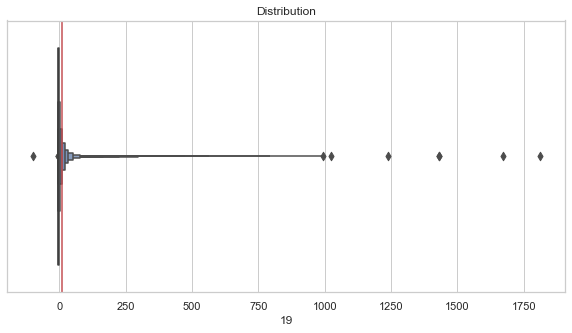

 39%|███▊      | 96/248 [00:28<00:49,  3.09it/s]

--------------------------------------------------
                     6
--------------------------------------------------
99 quantile is 55.10382080078125


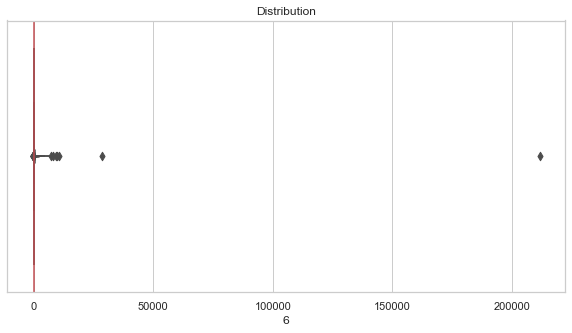

 39%|███▉      | 97/248 [00:28<00:45,  3.33it/s]

--------------------------------------------------
                     191
--------------------------------------------------
99 quantile is 621.8090942382811


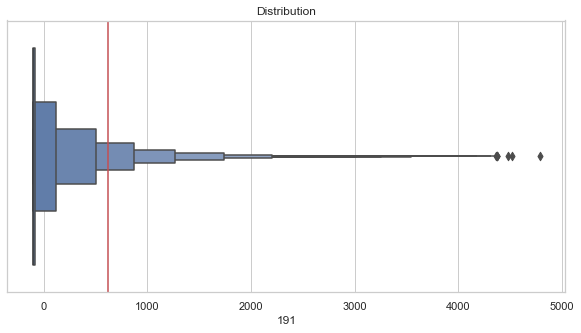

 40%|███▉      | 98/248 [00:28<00:44,  3.38it/s]

--------------------------------------------------
                     200
--------------------------------------------------
Unique values is  [-0.02921001  0.97078997]
99 quantile is -0.029210012406110764


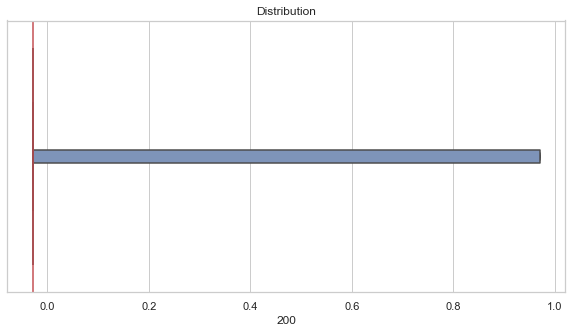

 40%|███▉      | 99/248 [00:29<00:44,  3.35it/s]

--------------------------------------------------
                     153
--------------------------------------------------
99 quantile is -0.01956198364496231


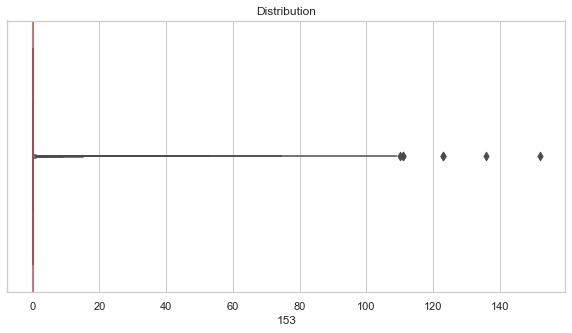

 40%|████      | 100/248 [00:29<00:41,  3.60it/s]

--------------------------------------------------
                     142
--------------------------------------------------
99 quantile is -0.0426359698176384


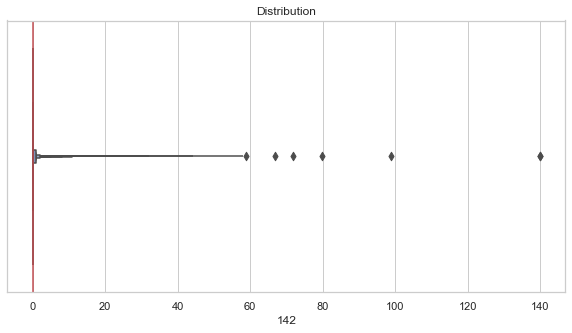

 41%|████      | 101/248 [00:29<00:39,  3.71it/s]

--------------------------------------------------
                     186
--------------------------------------------------
99 quantile is 172.6726196289047


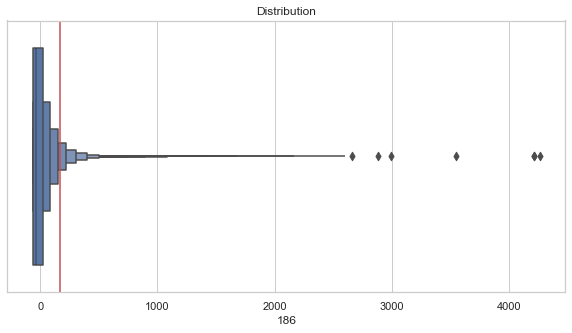

 41%|████      | 102/248 [00:30<00:47,  3.08it/s]

--------------------------------------------------
                     109
--------------------------------------------------
99 quantile is -1.0192927122116089


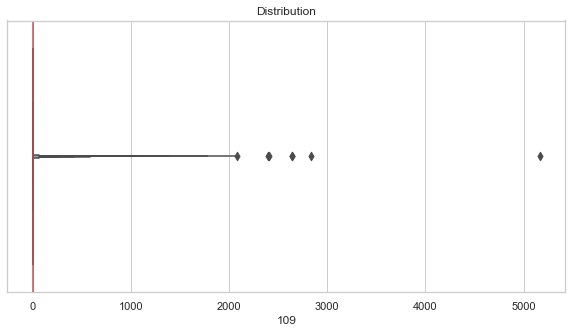

 42%|████▏     | 103/248 [00:30<00:48,  2.98it/s]

--------------------------------------------------
                     171
--------------------------------------------------
99 quantile is 36.385501861572266


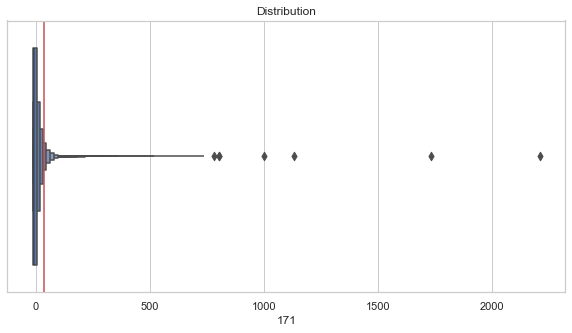

 42%|████▏     | 104/248 [00:30<00:48,  2.98it/s]

--------------------------------------------------
                     209
--------------------------------------------------
99 quantile is 1.3770992755889893


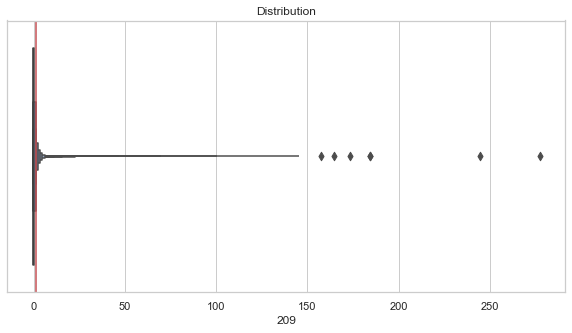

 42%|████▏     | 105/248 [00:30<00:45,  3.14it/s]

--------------------------------------------------
                     245
--------------------------------------------------
99 quantile is -9.996268272399902


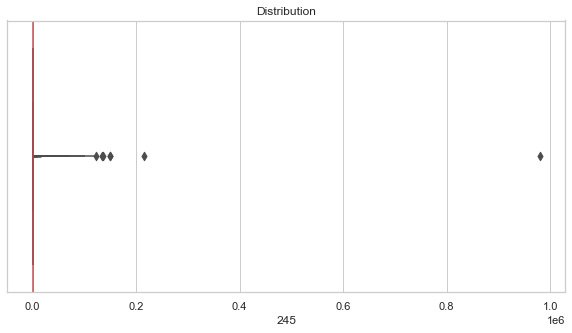

 43%|████▎     | 106/248 [00:31<00:47,  3.00it/s]

--------------------------------------------------
                     70
--------------------------------------------------
99 quantile is 0.8699686527252197


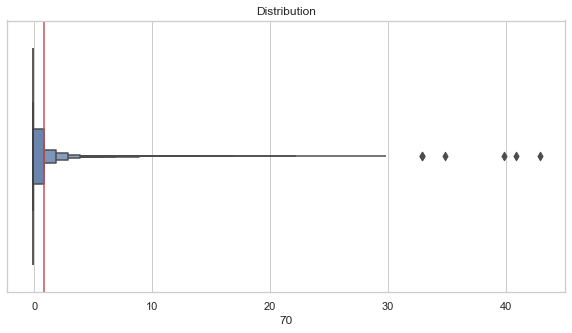

 43%|████▎     | 107/248 [00:31<00:43,  3.27it/s]

--------------------------------------------------
                     32
--------------------------------------------------
Unique values is  [-2.3046949e-05  9.9997693e-01]
99 quantile is -2.304694862687029e-05


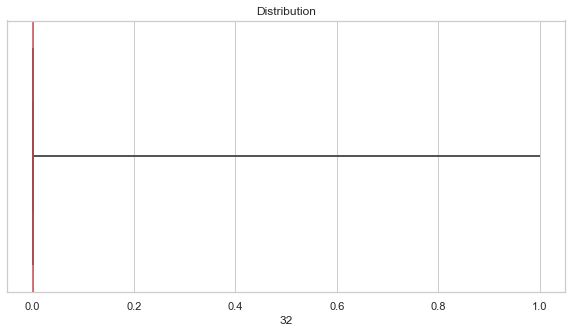

 44%|████▎     | 108/248 [00:31<00:40,  3.50it/s]

--------------------------------------------------
                     56
--------------------------------------------------
99 quantile is 5.328676223754883


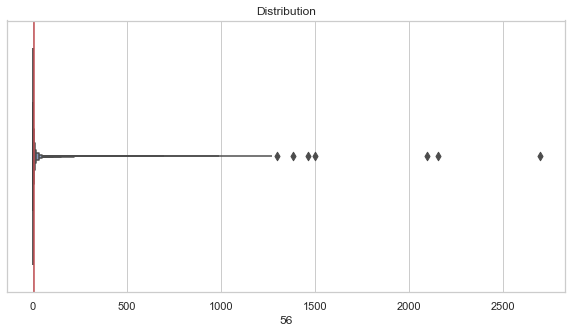

 44%|████▍     | 109/248 [00:32<00:41,  3.36it/s]

--------------------------------------------------
                     103
--------------------------------------------------
99 quantile is 9.563360595702193


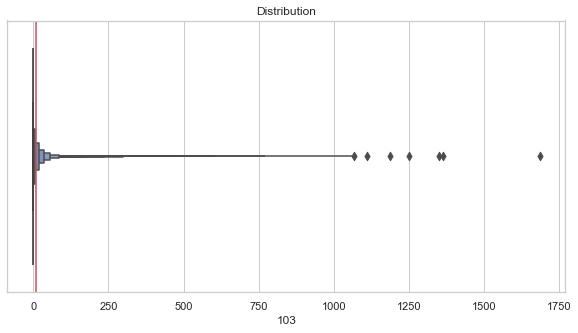

 44%|████▍     | 110/248 [00:32<00:41,  3.32it/s]

--------------------------------------------------
                     115
--------------------------------------------------
99 quantile is 0.5161429047584534


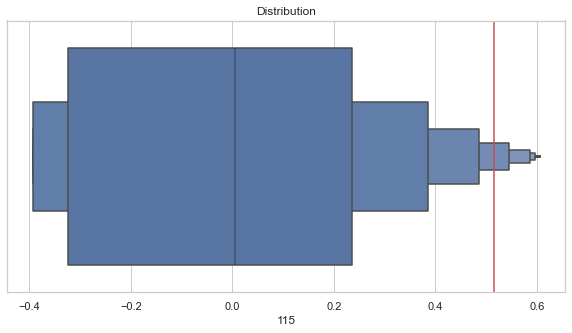

 45%|████▍     | 111/248 [00:32<00:44,  3.11it/s]

--------------------------------------------------
                     237
--------------------------------------------------
99 quantile is 15.631718635559082


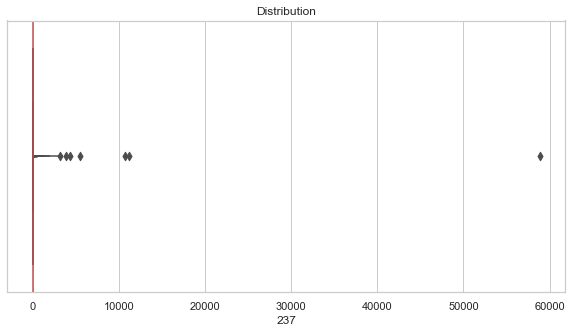

 45%|████▌     | 112/248 [00:33<00:45,  2.96it/s]

--------------------------------------------------
                     59
--------------------------------------------------
99 quantile is 12.117334365844727


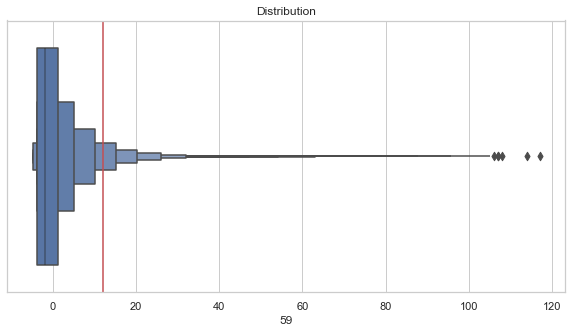

 46%|████▌     | 113/248 [00:33<00:46,  2.89it/s]

--------------------------------------------------
                     83
--------------------------------------------------
99 quantile is -0.2228522002696991


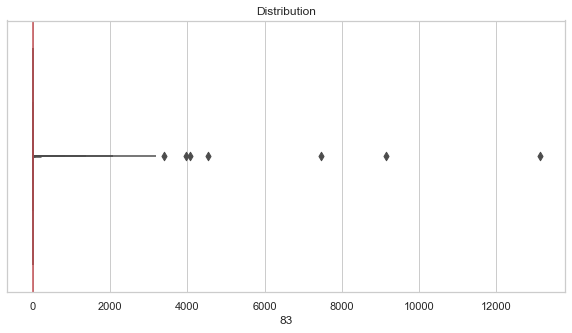

 46%|████▌     | 114/248 [00:33<00:41,  3.22it/s]

--------------------------------------------------
                     72
--------------------------------------------------
99 quantile is -2.6066200733184814


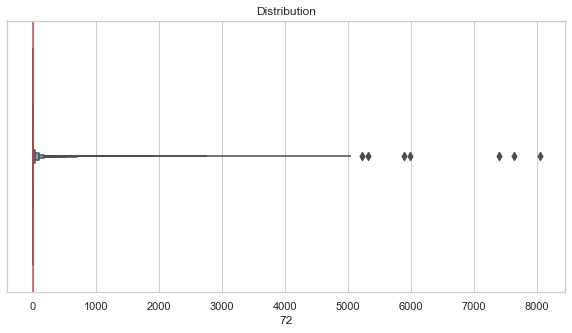

 46%|████▋     | 115/248 [00:34<00:39,  3.37it/s]

--------------------------------------------------
                     155
--------------------------------------------------
99 quantile is -0.0003793882206082344


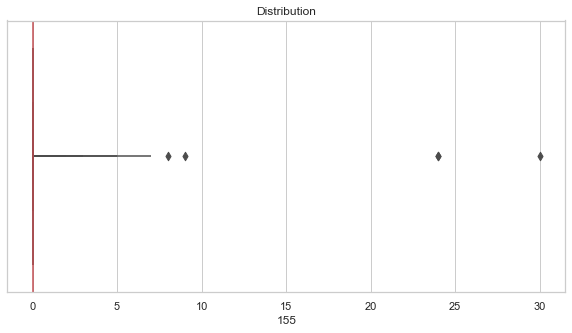

 47%|████▋     | 116/248 [00:34<00:38,  3.44it/s]

--------------------------------------------------
                     210
--------------------------------------------------
99 quantile is 46.7839469909668


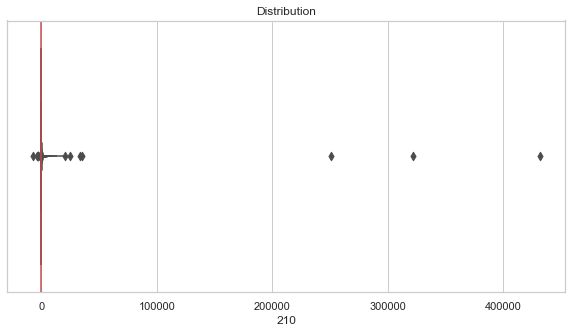

 47%|████▋     | 117/248 [00:34<00:38,  3.42it/s]

--------------------------------------------------
                     57
--------------------------------------------------
Unique values is  [-0.00165561  0.99834436]
99 quantile is -0.001655612955801189


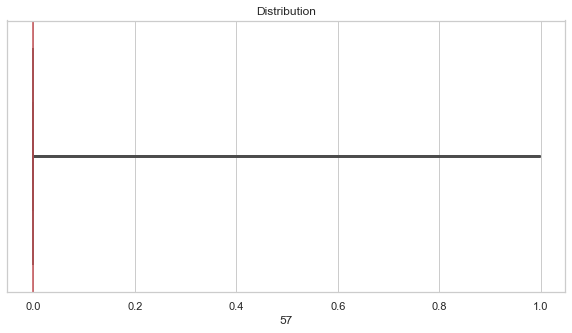

 48%|████▊     | 118/248 [00:34<00:35,  3.63it/s]

--------------------------------------------------
                     137
--------------------------------------------------
99 quantile is 5.1740264892578125


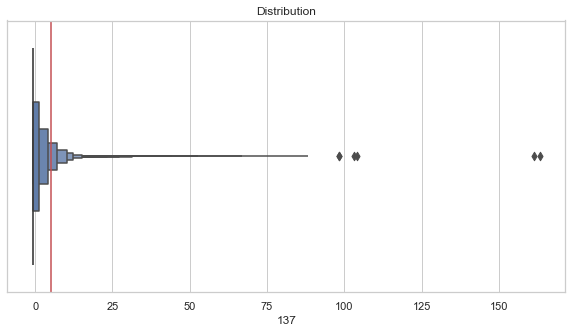

 48%|████▊     | 119/248 [00:35<00:36,  3.53it/s]

--------------------------------------------------
                     124
--------------------------------------------------
99 quantile is -119.67440795898438


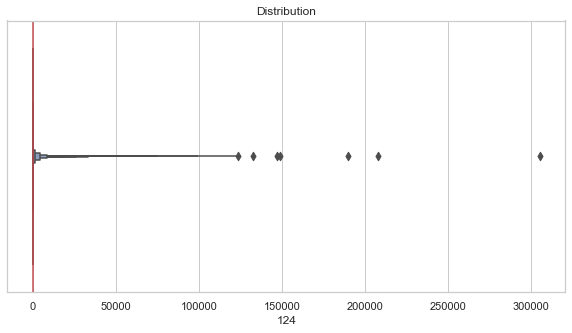

 48%|████▊     | 120/248 [00:35<00:35,  3.61it/s]

--------------------------------------------------
                     157
--------------------------------------------------
99 quantile is -0.2613089680671692


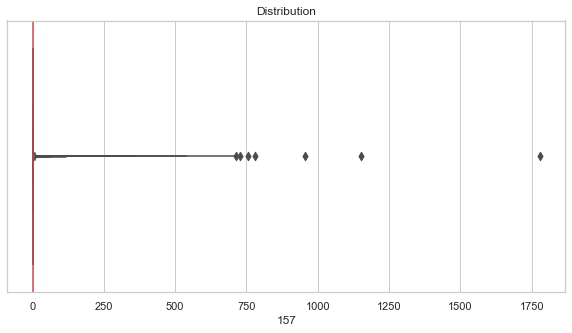

 49%|████▉     | 121/248 [00:35<00:34,  3.68it/s]

--------------------------------------------------
                     110
--------------------------------------------------
99 quantile is 5.526553630828857


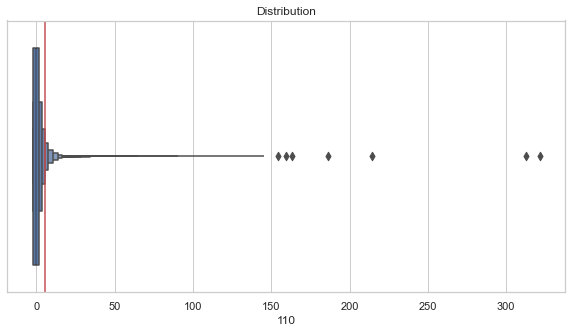

 49%|████▉     | 122/248 [00:36<00:43,  2.90it/s]

--------------------------------------------------
                     134
--------------------------------------------------
99 quantile is 1668.32958984375


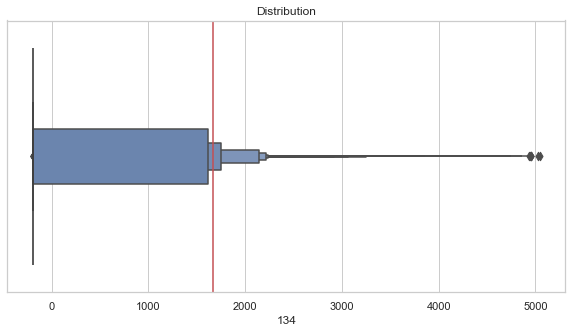

 50%|████▉     | 123/248 [00:36<00:40,  3.10it/s]

--------------------------------------------------
                     143
--------------------------------------------------
99 quantile is 98.73631286621094


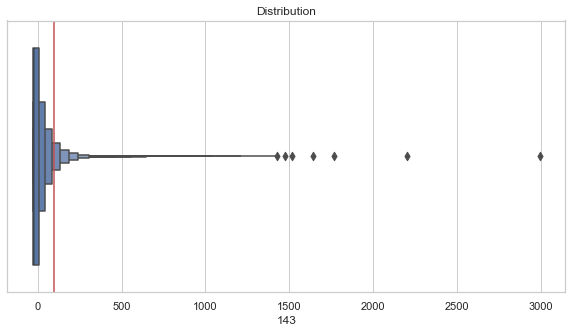

 50%|█████     | 124/248 [00:36<00:41,  2.97it/s]

--------------------------------------------------
                     197
--------------------------------------------------
Unique values is  [-5.673095e-04  9.994327e-01]
99 quantile is -0.0005673095001839101


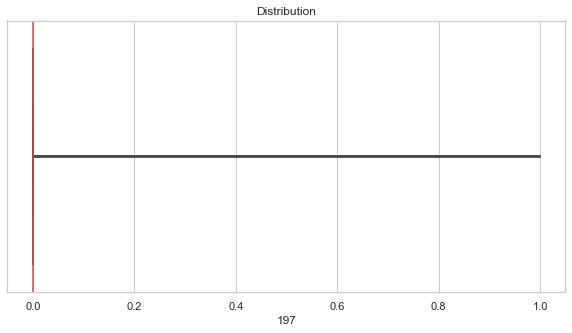

 50%|█████     | 125/248 [00:37<00:37,  3.25it/s]

--------------------------------------------------
                     38
--------------------------------------------------
99 quantile is 10024.749804687483


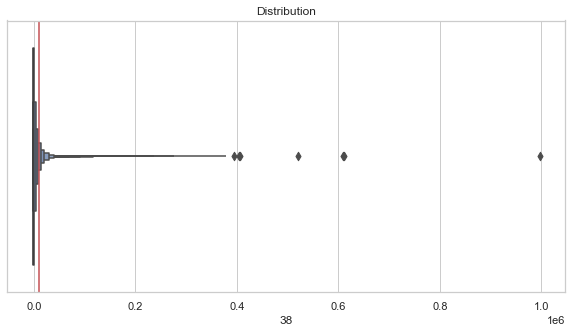

 51%|█████     | 126/248 [00:37<00:41,  2.92it/s]

--------------------------------------------------
                     12
--------------------------------------------------
99 quantile is -2.5589120388031006


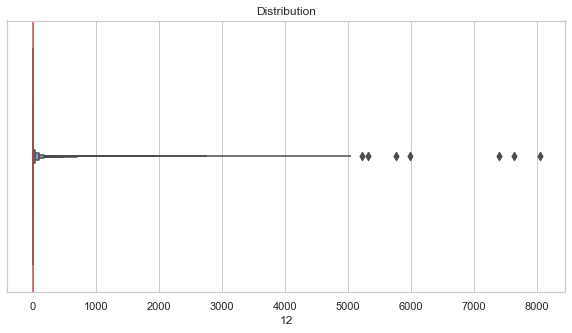

 51%|█████     | 127/248 [00:37<00:38,  3.17it/s]

--------------------------------------------------
                     242
--------------------------------------------------
99 quantile is 28.704593658447266


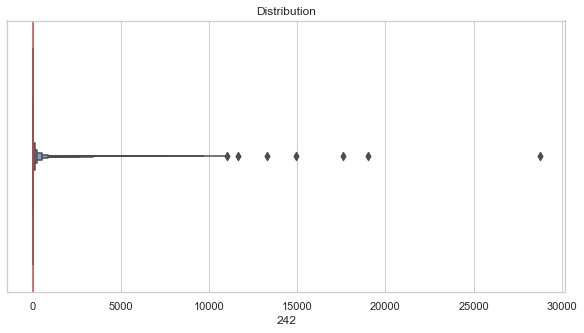

 52%|█████▏    | 128/248 [00:38<00:35,  3.35it/s]

--------------------------------------------------
                     202
--------------------------------------------------
Unique values is  [-0.00135755  0.99864244]
99 quantile is -0.0013575538760051131


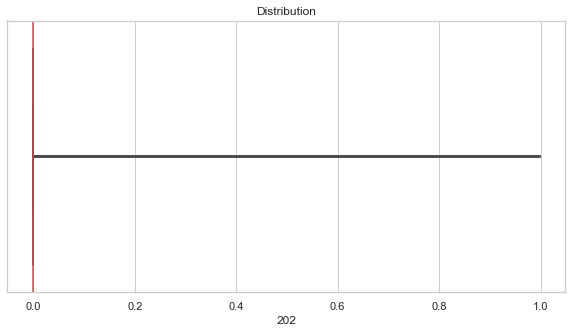

 52%|█████▏    | 129/248 [00:38<00:34,  3.42it/s]

--------------------------------------------------
                     49
--------------------------------------------------
99 quantile is -28.461404800415043


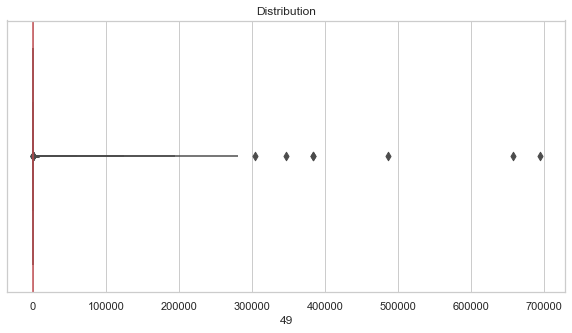

 52%|█████▏    | 130/248 [00:38<00:36,  3.20it/s]

--------------------------------------------------
                     93
--------------------------------------------------
99 quantile is -0.18529905378818512


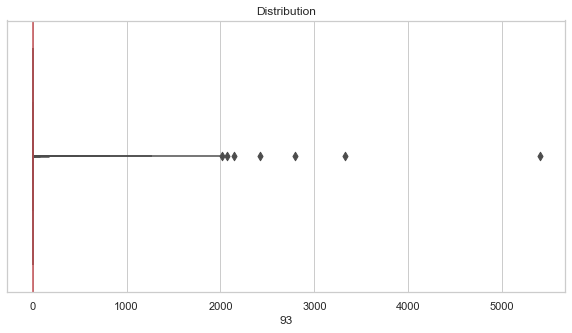

 53%|█████▎    | 131/248 [00:38<00:33,  3.48it/s]

--------------------------------------------------
                     46
--------------------------------------------------
99 quantile is 17.403718948364258


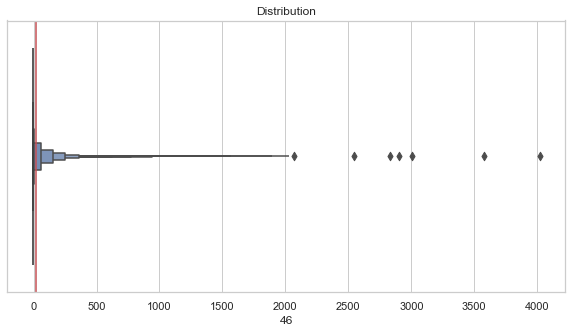

 53%|█████▎    | 132/248 [00:39<00:33,  3.46it/s]

--------------------------------------------------
                     26
--------------------------------------------------
Unique values is  [ 0.20013838 -0.7998616 ]
99 quantile is 0.2001383751630783


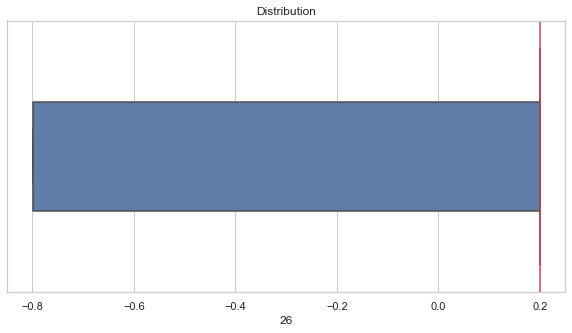

 54%|█████▎    | 133/248 [00:39<00:34,  3.36it/s]

--------------------------------------------------
                     76
--------------------------------------------------
99 quantile is 12.005977630615234


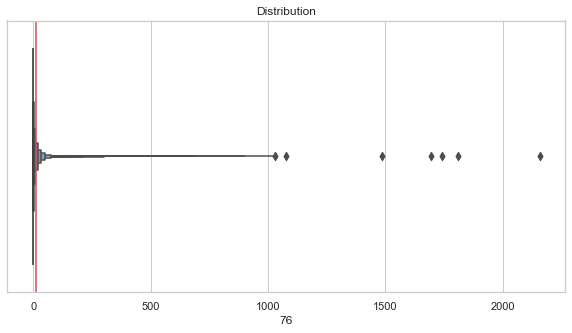

 54%|█████▍    | 134/248 [00:39<00:33,  3.45it/s]

--------------------------------------------------
                     92
--------------------------------------------------
99 quantile is -0.5066133141517639


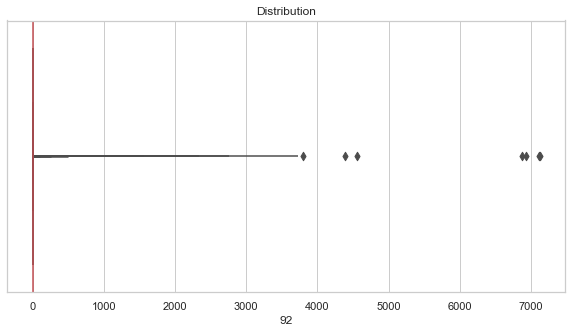

 54%|█████▍    | 135/248 [00:40<00:31,  3.58it/s]

--------------------------------------------------
                     182
--------------------------------------------------
99 quantile is 3.656362533569336


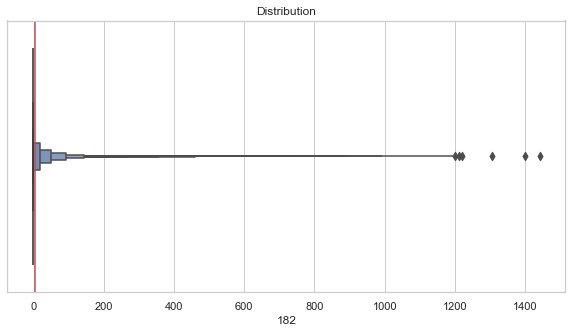

 55%|█████▍    | 136/248 [00:40<00:32,  3.45it/s]

--------------------------------------------------
                     252
--------------------------------------------------
99 quantile is 1.0


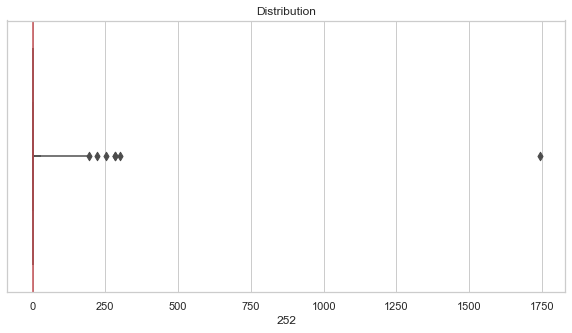

 55%|█████▌    | 137/248 [00:40<00:32,  3.43it/s]

--------------------------------------------------
                     180
--------------------------------------------------
99 quantile is -0.0018902744632214308


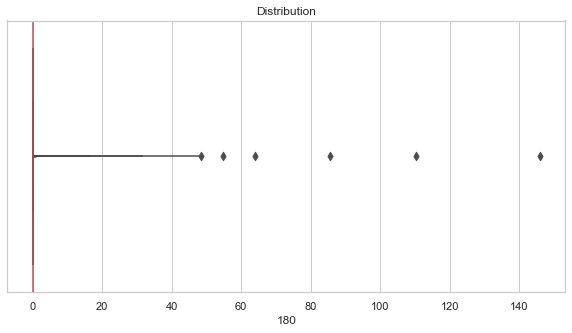

 56%|█████▌    | 138/248 [00:40<00:29,  3.67it/s]

--------------------------------------------------
                     140
--------------------------------------------------
99 quantile is -1.2761870622634888


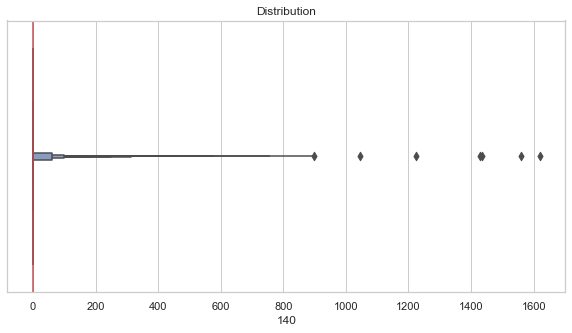

 56%|█████▌    | 139/248 [00:41<00:29,  3.68it/s]

--------------------------------------------------
                     176
--------------------------------------------------
99 quantile is -0.03377800062298775


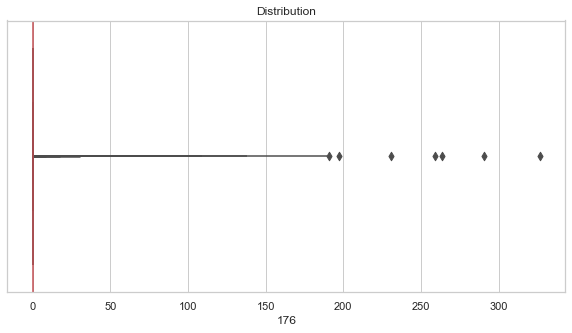

 56%|█████▋    | 140/248 [00:41<00:33,  3.18it/s]

--------------------------------------------------
                     144
--------------------------------------------------
99 quantile is 347.97918701171875


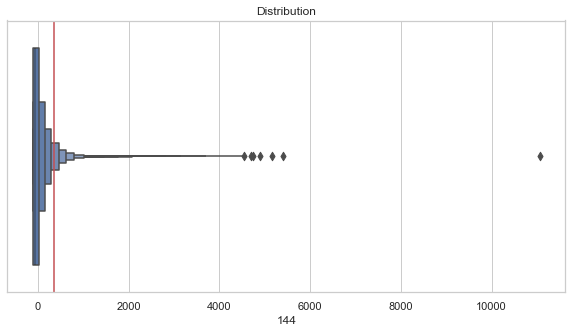

 57%|█████▋    | 141/248 [00:41<00:36,  2.90it/s]

--------------------------------------------------
                     130
--------------------------------------------------
99 quantile is 30.318359375


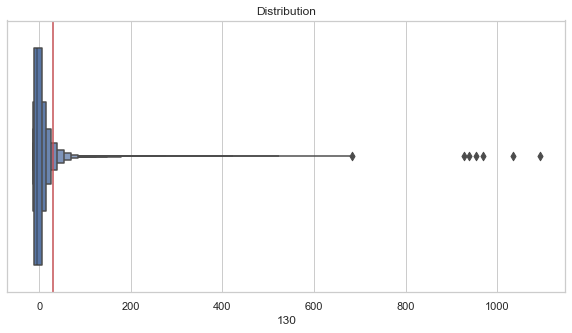

 57%|█████▋    | 142/248 [00:42<00:36,  2.92it/s]

--------------------------------------------------
                     63
--------------------------------------------------
99 quantile is 0.5624241828918457


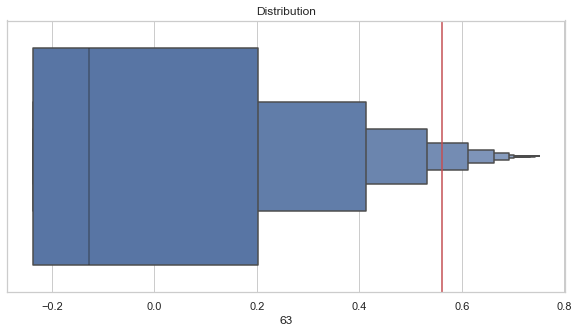

 58%|█████▊    | 143/248 [00:42<00:36,  2.87it/s]

--------------------------------------------------
                     246
--------------------------------------------------
99 quantile is 81.36955261230469


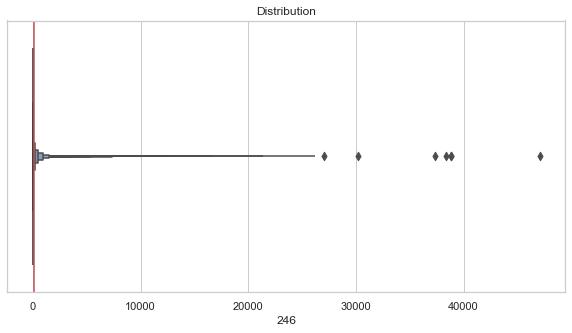

 58%|█████▊    | 144/248 [00:43<00:35,  2.96it/s]

--------------------------------------------------
                     193
--------------------------------------------------
99 quantile is 6.07095193862915


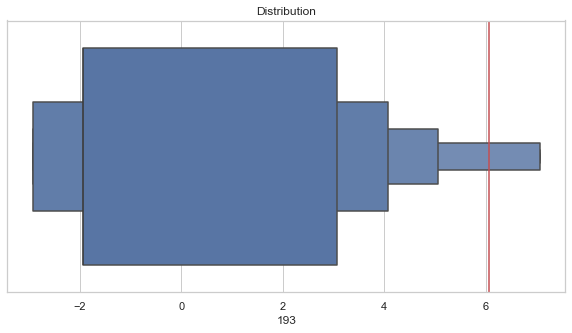

 58%|█████▊    | 145/248 [00:43<00:35,  2.89it/s]

--------------------------------------------------
                     163
--------------------------------------------------
99 quantile is -0.014541516080498695


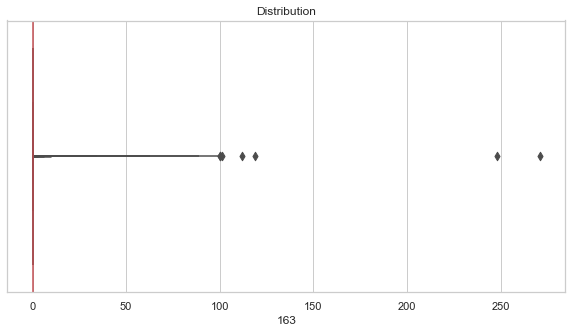

 59%|█████▉    | 146/248 [00:43<00:31,  3.21it/s]

--------------------------------------------------
                     24
--------------------------------------------------
99 quantile is -0.009327257052063942


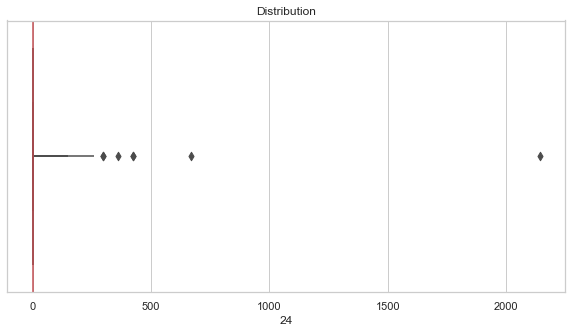

 59%|█████▉    | 147/248 [00:43<00:28,  3.53it/s]

--------------------------------------------------
                     40
--------------------------------------------------
99 quantile is 7100.6156249999985


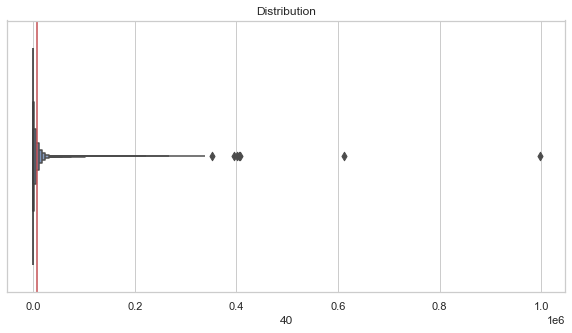

 60%|█████▉    | 148/248 [00:44<00:31,  3.16it/s]

--------------------------------------------------
                     167
--------------------------------------------------
99 quantile is 68.67991638183594


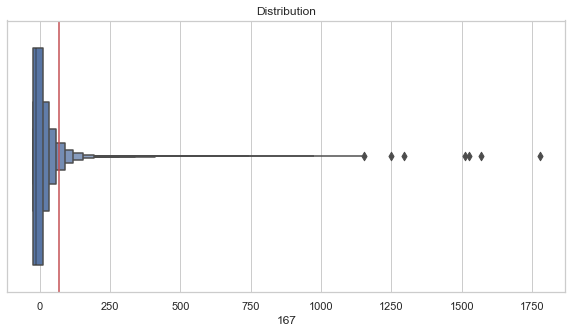

 60%|██████    | 149/248 [00:44<00:33,  3.00it/s]

--------------------------------------------------
                     136
--------------------------------------------------
99 quantile is 15.277409553527832


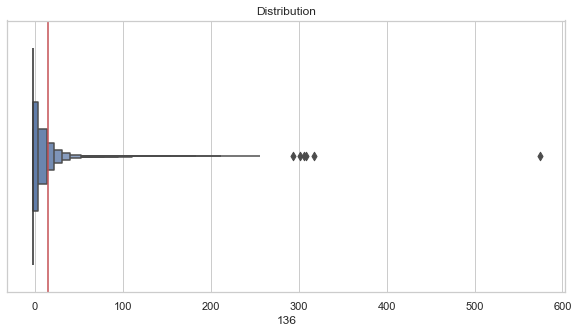

 60%|██████    | 150/248 [00:44<00:30,  3.21it/s]

--------------------------------------------------
                     244
--------------------------------------------------
99 quantile is 2682.229248046875


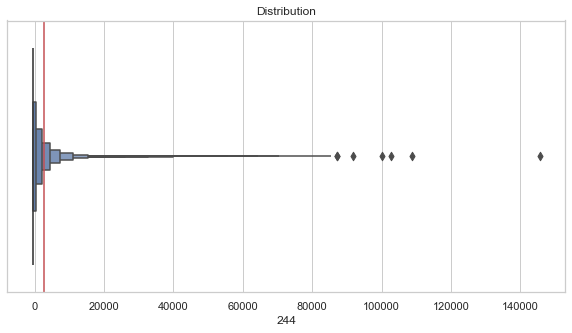

 61%|██████    | 151/248 [00:45<00:33,  2.90it/s]

--------------------------------------------------
                     14
--------------------------------------------------
99 quantile is 345.2278930663979


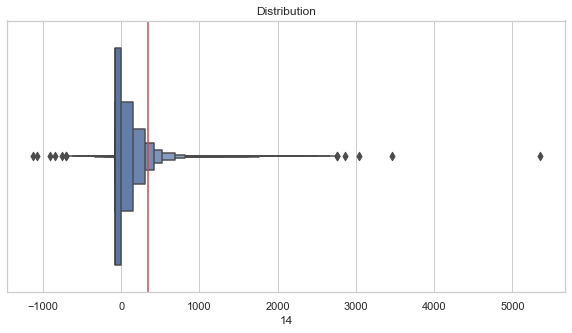

 61%|██████▏   | 152/248 [00:45<00:32,  2.93it/s]

--------------------------------------------------
                     39
--------------------------------------------------
99 quantile is 4630.526269531247


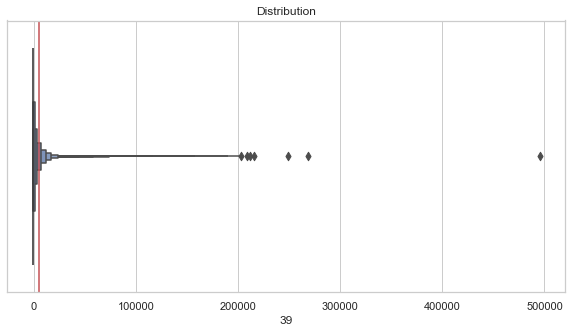

 62%|██████▏   | 153/248 [00:46<00:34,  2.76it/s]

--------------------------------------------------
                     48
--------------------------------------------------
99 quantile is -10.65296688079834


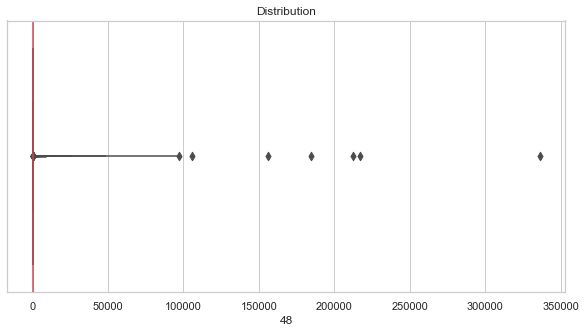

 62%|██████▏   | 154/248 [00:46<00:32,  2.86it/s]

--------------------------------------------------
                     15
--------------------------------------------------
99 quantile is -0.0007252542418427765


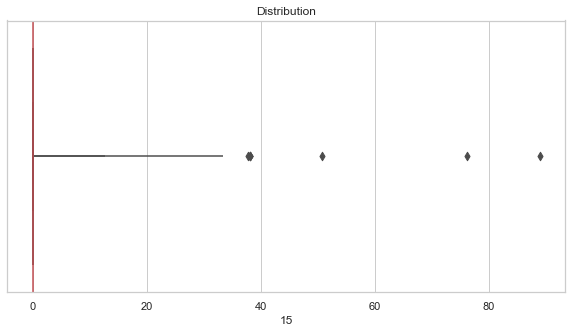

 62%|██████▎   | 155/248 [00:46<00:28,  3.23it/s]

--------------------------------------------------
                     31
--------------------------------------------------
Unique values is  [-0.00188409  0.9981159 ]
99 quantile is -0.0018840880366042256


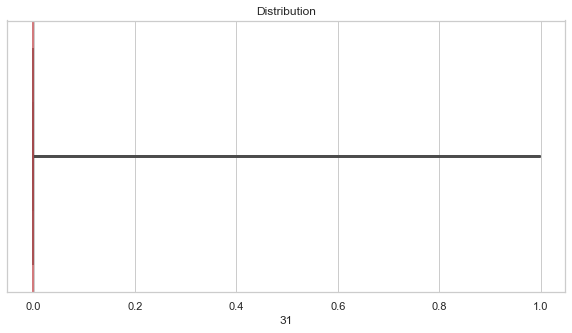

 63%|██████▎   | 156/248 [00:46<00:26,  3.48it/s]

--------------------------------------------------
                     53
--------------------------------------------------
99 quantile is 57.668704986572266


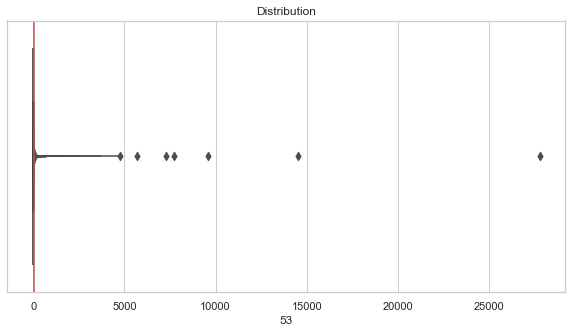

 63%|██████▎   | 157/248 [00:47<00:30,  3.02it/s]

--------------------------------------------------
                     174
--------------------------------------------------
99 quantile is -0.06321372091770172


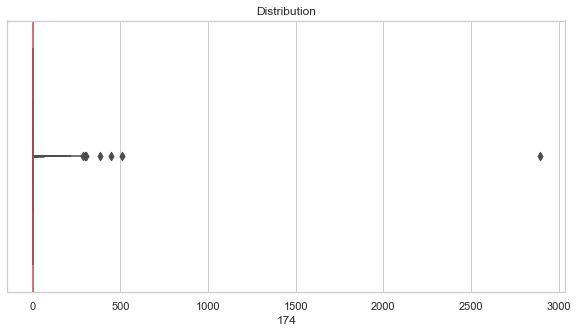

 64%|██████▎   | 158/248 [00:47<00:27,  3.29it/s]

--------------------------------------------------
                     198
--------------------------------------------------
Unique values is  [-0.43373582  0.5662642 ]
99 quantile is 0.5662642121315002


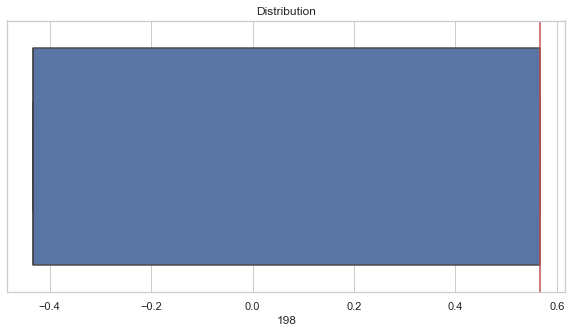

 64%|██████▍   | 159/248 [00:47<00:31,  2.85it/s]

--------------------------------------------------
                     243
--------------------------------------------------
99 quantile is 4181.6259765625


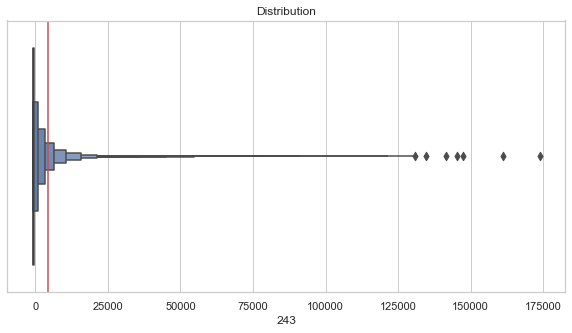

 65%|██████▍   | 160/248 [00:48<00:30,  2.87it/s]

--------------------------------------------------
                     187
--------------------------------------------------
99 quantile is 44.64519119262695


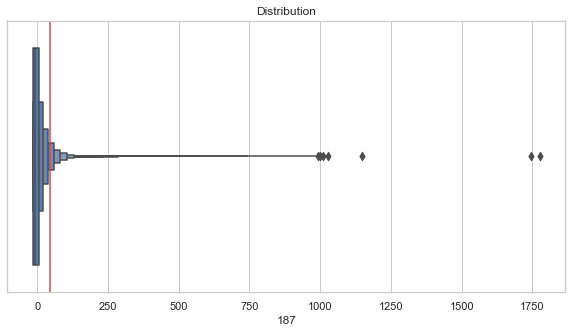

 65%|██████▍   | 161/248 [00:48<00:31,  2.77it/s]

--------------------------------------------------
                     16
--------------------------------------------------
99 quantile is -0.01643478125333786


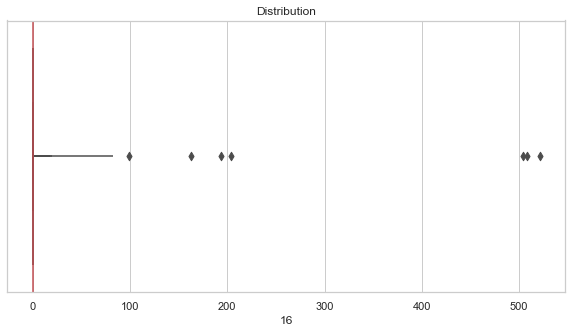

 65%|██████▌   | 162/248 [00:48<00:27,  3.10it/s]

--------------------------------------------------
                     64
--------------------------------------------------
99 quantile is 0.4143379032611847


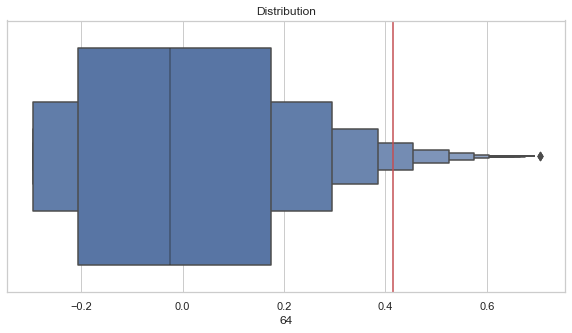

 66%|██████▌   | 163/248 [00:49<00:29,  2.89it/s]

--------------------------------------------------
                     98
--------------------------------------------------
99 quantile is -0.8283818960189819


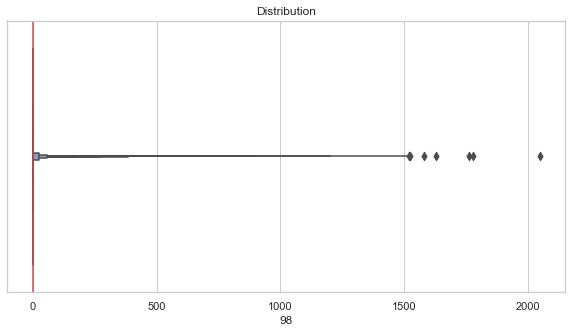

 66%|██████▌   | 164/248 [00:49<00:26,  3.17it/s]

--------------------------------------------------
                     42
--------------------------------------------------
99 quantile is -119.72435760498047


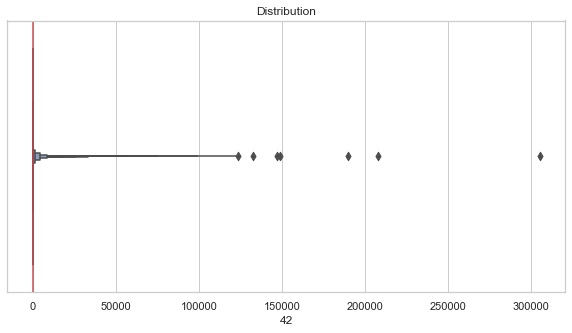

 67%|██████▋   | 165/248 [00:49<00:24,  3.35it/s]

--------------------------------------------------
                     45
--------------------------------------------------
99 quantile is 172.5238494873047


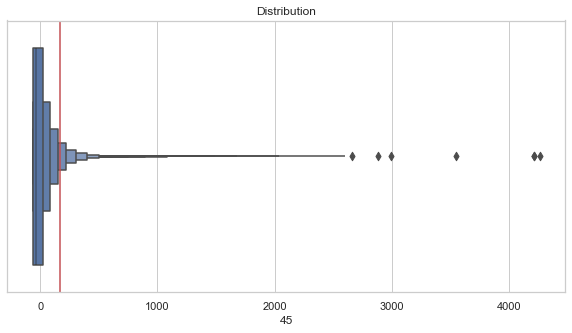

 67%|██████▋   | 166/248 [00:50<00:27,  3.01it/s]

--------------------------------------------------
                     106
--------------------------------------------------
99 quantile is 41.46153259277344


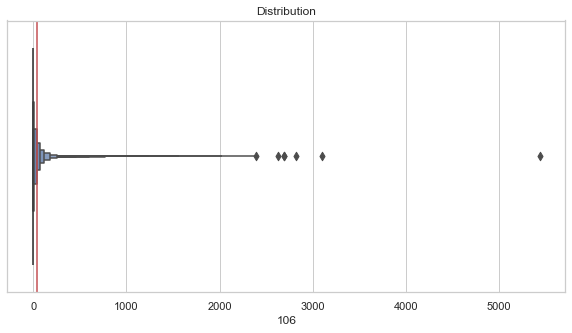

 67%|██████▋   | 167/248 [00:50<00:26,  3.02it/s]

--------------------------------------------------
                     55
--------------------------------------------------
99 quantile is 27.254749298095703


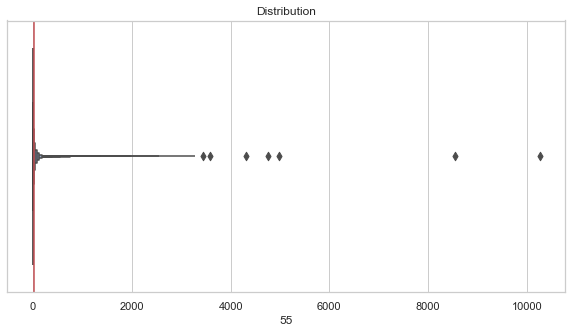

 68%|██████▊   | 168/248 [00:50<00:27,  2.95it/s]

--------------------------------------------------
                     34
--------------------------------------------------
99 quantile is 1.5806103944778442


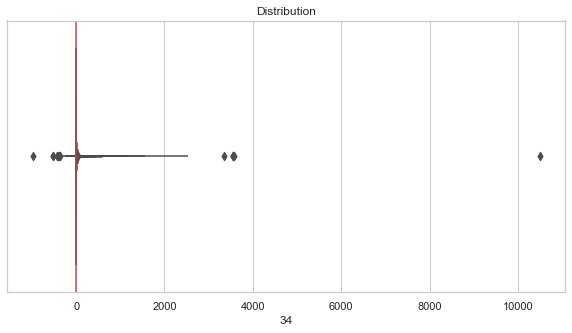

 68%|██████▊   | 169/248 [00:51<00:25,  3.08it/s]

--------------------------------------------------
                     166
--------------------------------------------------
99 quantile is 131.74024963378906


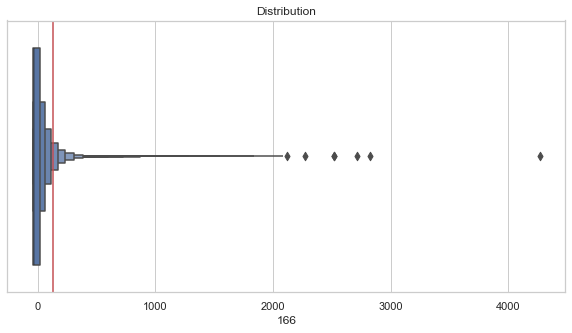

 69%|██████▊   | 170/248 [00:51<00:25,  3.00it/s]

--------------------------------------------------
                     207
--------------------------------------------------
99 quantile is 34649.34999999998


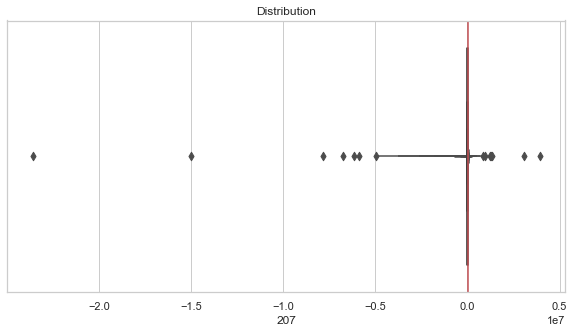

 69%|██████▉   | 171/248 [00:51<00:27,  2.80it/s]

--------------------------------------------------
                     215
--------------------------------------------------
99 quantile is -2.1080496311187744


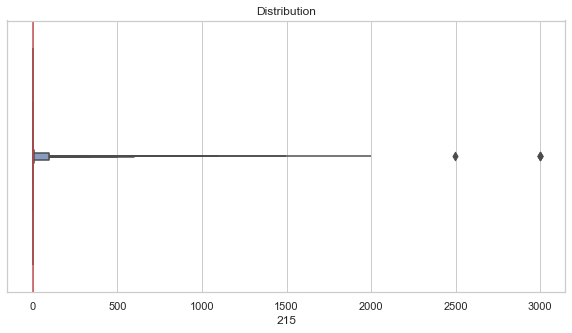

 69%|██████▉   | 172/248 [00:52<00:24,  3.14it/s]

--------------------------------------------------
                     41
--------------------------------------------------
99 quantile is -68.41424865722684


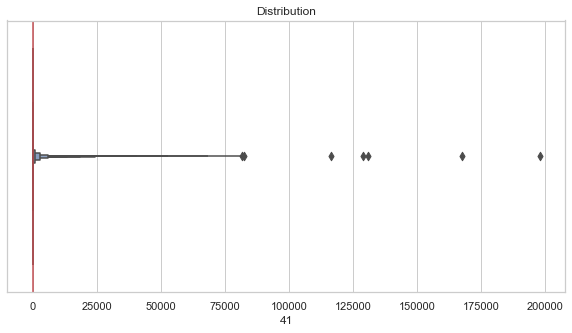

 70%|██████▉   | 173/248 [00:52<00:23,  3.24it/s]

--------------------------------------------------
                     226
--------------------------------------------------
99 quantile is 18.89933204650879


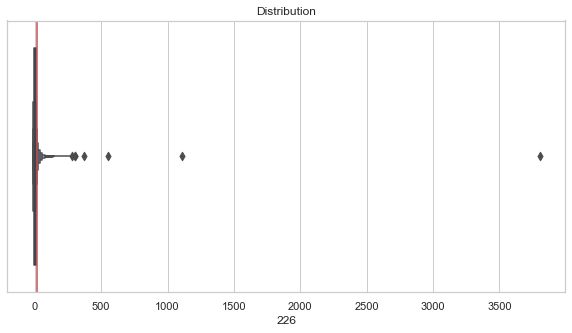

 70%|███████   | 174/248 [00:52<00:23,  3.19it/s]

--------------------------------------------------
                     162
--------------------------------------------------
99 quantile is 14.321785926818848


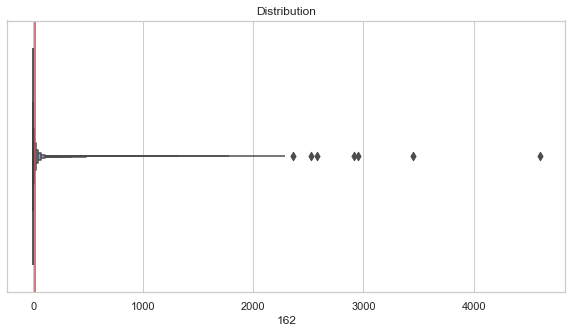

 71%|███████   | 175/248 [00:53<00:22,  3.28it/s]

--------------------------------------------------
                     111
--------------------------------------------------
99 quantile is 13.379159927368164


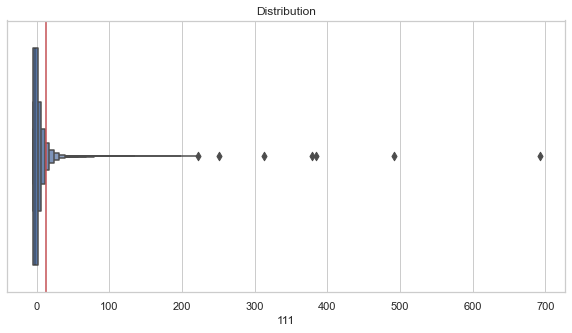

 71%|███████   | 176/248 [00:53<00:24,  2.96it/s]

--------------------------------------------------
                     183
--------------------------------------------------
99 quantile is 5.06724214553833


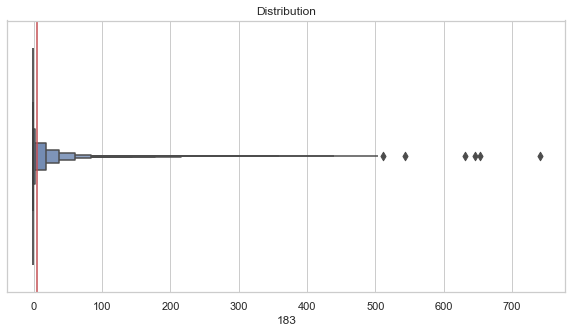

 71%|███████▏  | 177/248 [00:53<00:22,  3.16it/s]

--------------------------------------------------
                     78
--------------------------------------------------
99 quantile is -1.2015000581741333


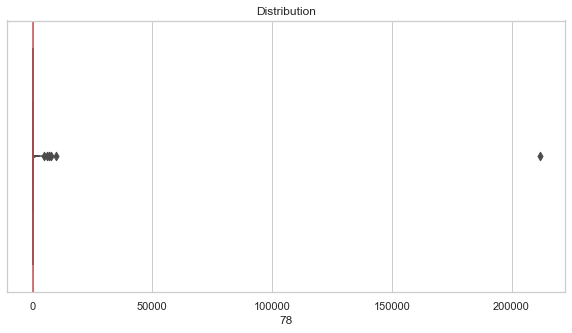

 72%|███████▏  | 178/248 [00:54<00:23,  2.99it/s]

--------------------------------------------------
                     36
--------------------------------------------------
99 quantile is 3.5392353534698486


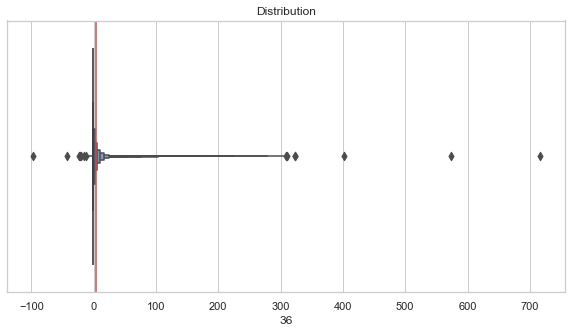

 72%|███████▏  | 179/248 [00:54<00:21,  3.20it/s]

--------------------------------------------------
                     97
--------------------------------------------------
99 quantile is -0.3489134907722473


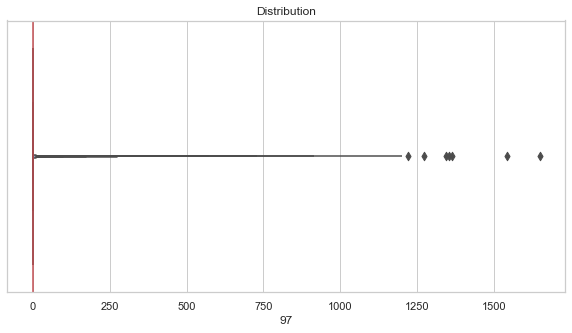

 73%|███████▎  | 180/248 [00:54<00:19,  3.47it/s]

--------------------------------------------------
                     107
--------------------------------------------------
99 quantile is -0.21213726699352264


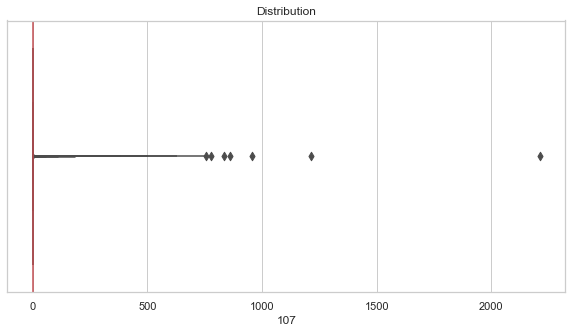

 73%|███████▎  | 181/248 [00:54<00:18,  3.69it/s]

--------------------------------------------------
                     102
--------------------------------------------------
99 quantile is -0.3181478679180145


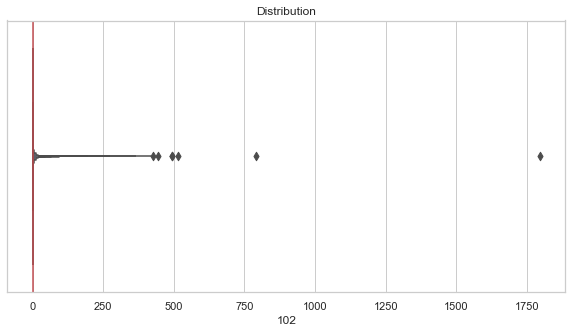

 73%|███████▎  | 182/248 [00:55<00:17,  3.72it/s]

--------------------------------------------------
                     129
--------------------------------------------------
99 quantile is 11.3818359375


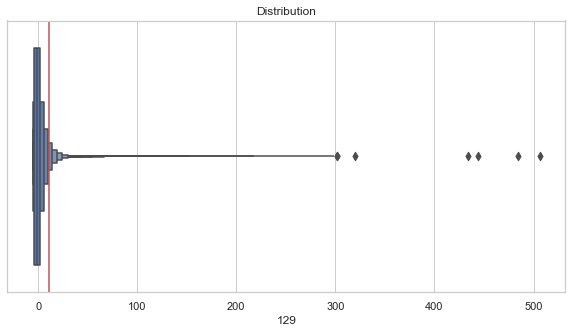

 74%|███████▍  | 183/248 [00:55<00:19,  3.32it/s]

--------------------------------------------------
                     25
--------------------------------------------------
99 quantile is 7.06779146194458


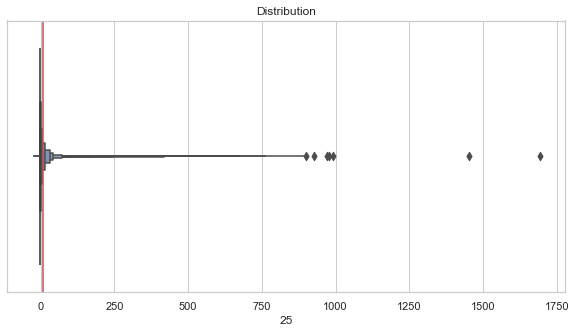

 74%|███████▍  | 184/248 [00:55<00:18,  3.39it/s]

--------------------------------------------------
                     23
--------------------------------------------------
99 quantile is -0.0017331349663436413


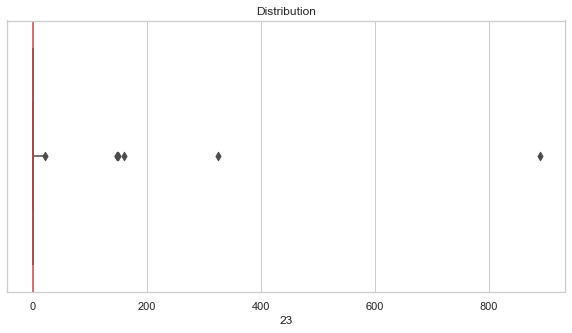

 75%|███████▍  | 185/248 [00:55<00:16,  3.77it/s]

--------------------------------------------------
                     123
--------------------------------------------------
99 quantile is -71.9572570800783


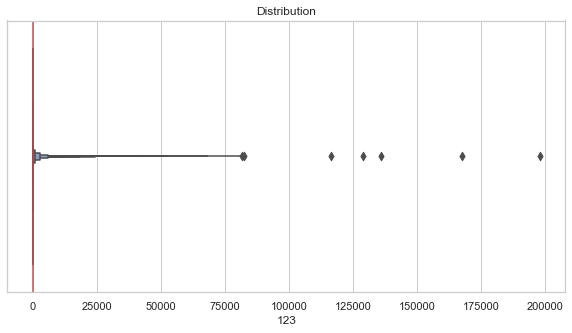

 75%|███████▌  | 186/248 [00:56<00:16,  3.67it/s]

--------------------------------------------------
                     122
--------------------------------------------------
99 quantile is -0.024048326537013054


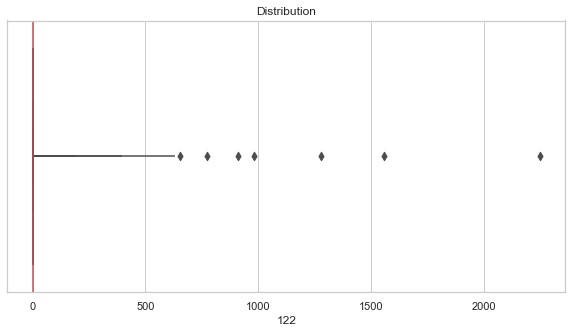

 75%|███████▌  | 187/248 [00:56<00:15,  3.87it/s]

--------------------------------------------------
                     68
--------------------------------------------------
99 quantile is 0.44532284140586853


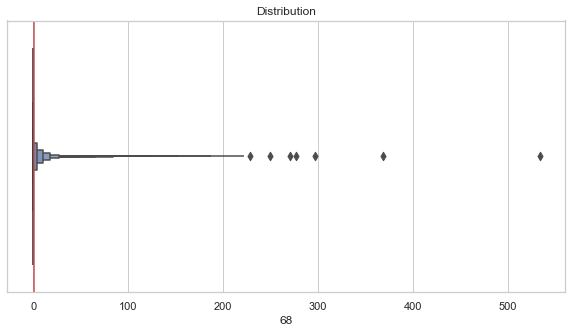

 76%|███████▌  | 188/248 [00:56<00:15,  3.91it/s]

--------------------------------------------------
                     10
--------------------------------------------------
99 quantile is -2.736081123352051


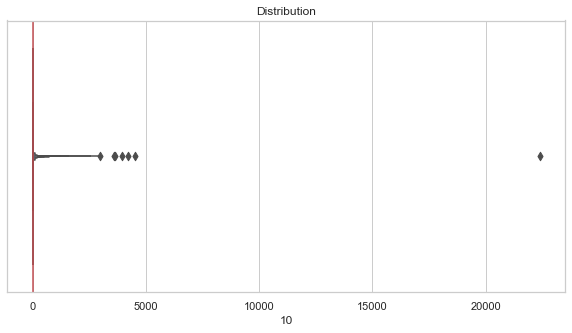

 76%|███████▌  | 189/248 [00:56<00:15,  3.86it/s]

--------------------------------------------------
                     114
--------------------------------------------------
99 quantile is 0.5820104479789734


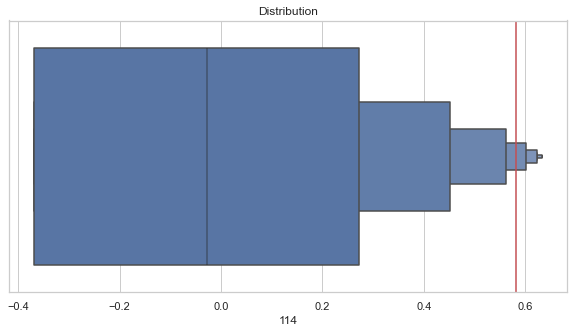

 77%|███████▋  | 190/248 [00:57<00:16,  3.54it/s]

--------------------------------------------------
                     181
--------------------------------------------------
99 quantile is 3.7426366806030273


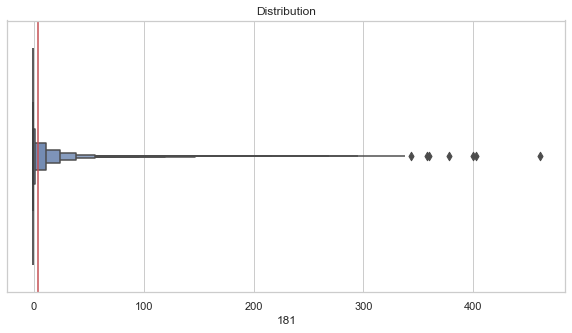

 77%|███████▋  | 191/248 [00:57<00:15,  3.72it/s]

--------------------------------------------------
                     217
--------------------------------------------------
99 quantile is 1.3771036863327026


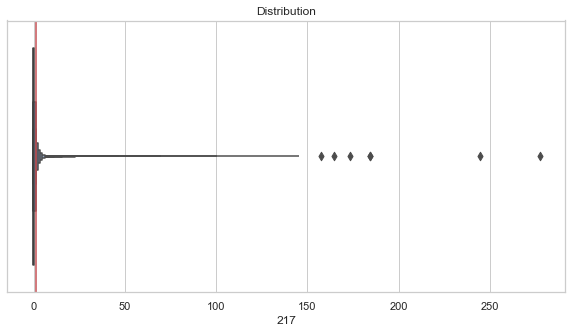

 77%|███████▋  | 192/248 [00:57<00:15,  3.53it/s]

--------------------------------------------------
                     33
--------------------------------------------------
Unique values is  [-3.0359923e-05  9.9996966e-01]
99 quantile is -3.0359922675415874e-05


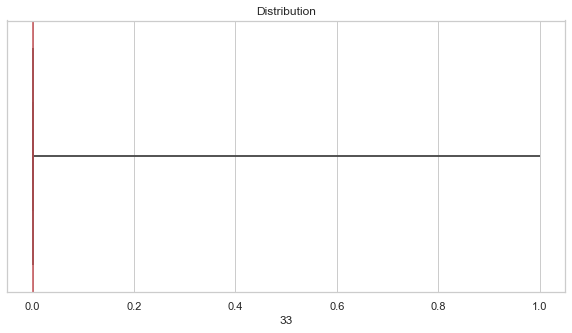

 78%|███████▊  | 193/248 [00:58<00:14,  3.81it/s]

--------------------------------------------------
                     20
--------------------------------------------------
99 quantile is 62.329185485839844


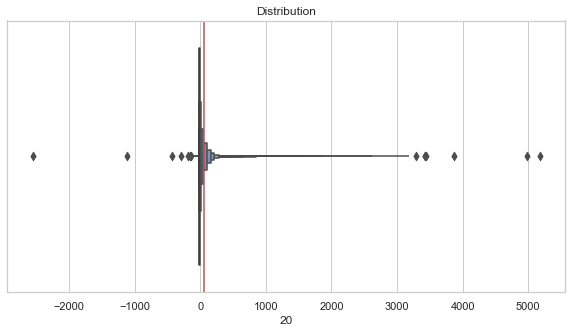

 78%|███████▊  | 194/248 [00:58<00:14,  3.77it/s]

--------------------------------------------------
                     205
--------------------------------------------------
Unique values is  [-0.3343556  0.6656444]
99 quantile is 0.6656444072723389


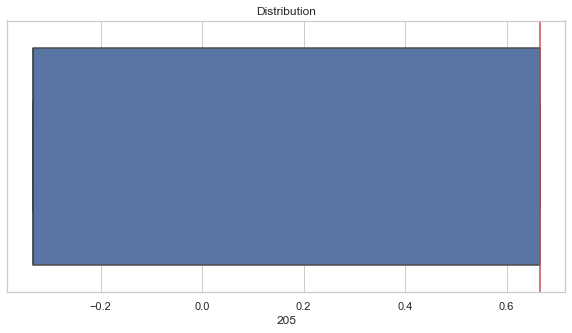

 79%|███████▊  | 195/248 [00:58<00:14,  3.55it/s]

--------------------------------------------------
                     149
--------------------------------------------------
99 quantile is -0.007024040445685387


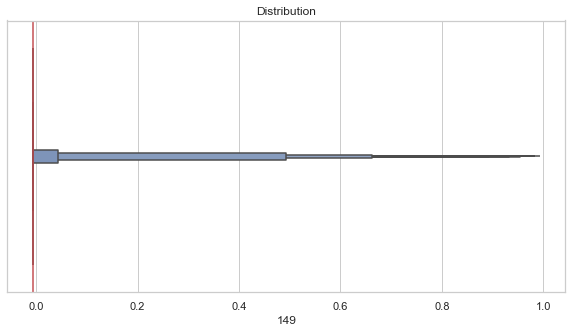

 79%|███████▉  | 196/248 [00:58<00:13,  3.85it/s]

--------------------------------------------------
                     206
--------------------------------------------------
Unique values is  [-0.0089985  0.9910015]
99 quantile is -0.008998503908514977


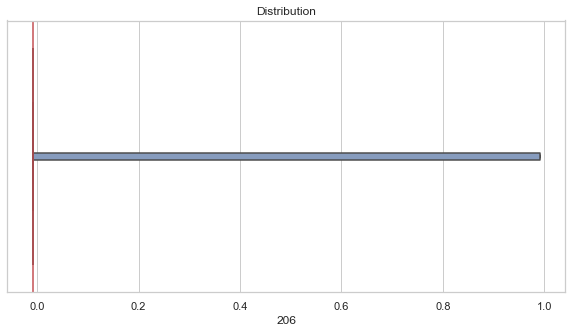

 79%|███████▉  | 197/248 [00:59<00:14,  3.44it/s]

--------------------------------------------------
                     172
--------------------------------------------------
99 quantile is 97.07827758789062


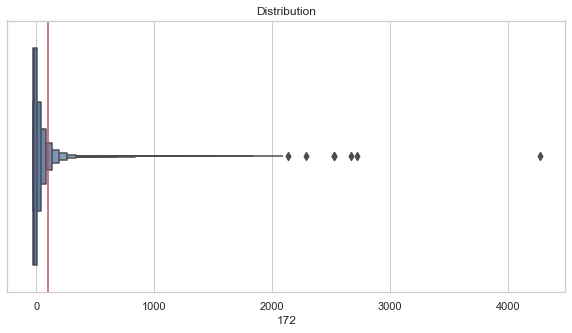

 80%|███████▉  | 198/248 [00:59<00:15,  3.16it/s]

--------------------------------------------------
                     240
--------------------------------------------------
99 quantile is 2188.562744140625


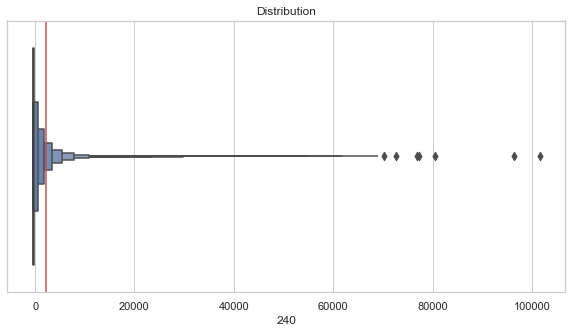

 80%|████████  | 199/248 [00:59<00:15,  3.12it/s]

--------------------------------------------------
                     58
--------------------------------------------------
99 quantile is 65.31835174560547


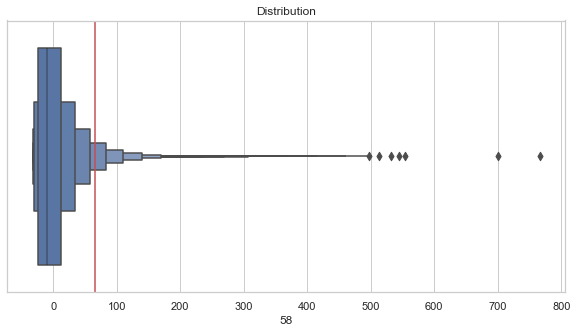

 81%|████████  | 200/248 [01:00<00:16,  2.88it/s]

--------------------------------------------------
                     204
--------------------------------------------------
Unique values is  [ 0.03920751 -0.9607925 ]
99 quantile is 0.03920751437544823


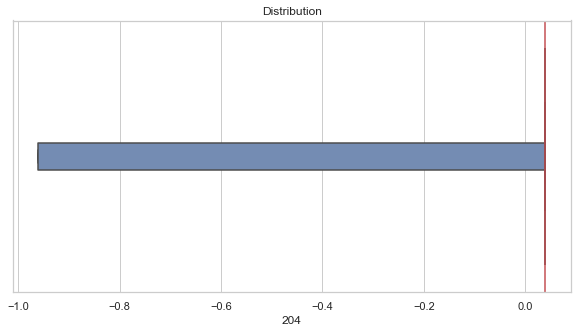

 81%|████████  | 201/248 [01:00<00:15,  3.10it/s]

--------------------------------------------------
                     88
--------------------------------------------------
99 quantile is -0.0969858393073082


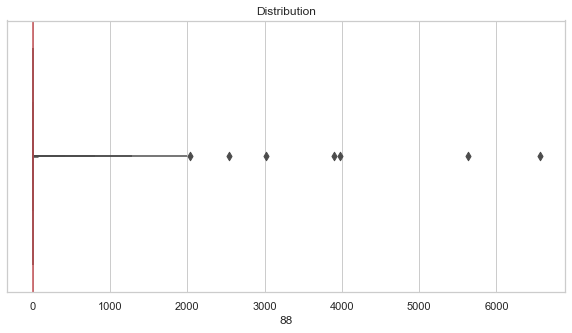

 81%|████████▏ | 202/248 [01:00<00:14,  3.20it/s]

--------------------------------------------------
                     87
--------------------------------------------------
99 quantile is -0.1258663535118103


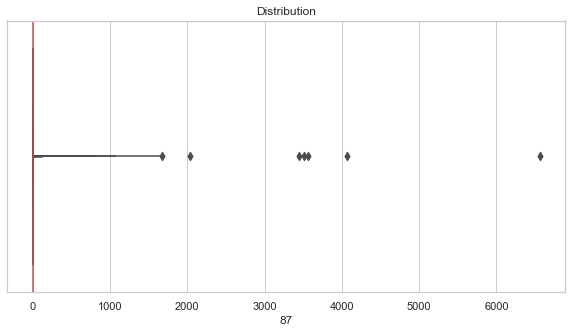

 82%|████████▏ | 203/248 [01:01<00:13,  3.43it/s]

--------------------------------------------------
                     146
--------------------------------------------------
99 quantile is 77.1116714477539


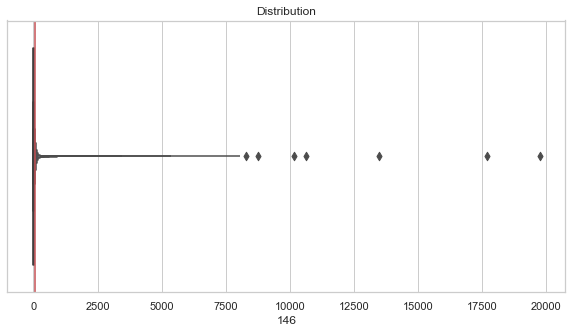

 82%|████████▏ | 204/248 [01:01<00:16,  2.73it/s]

--------------------------------------------------
                     28
--------------------------------------------------
99 quantile is 1.6481382846832275


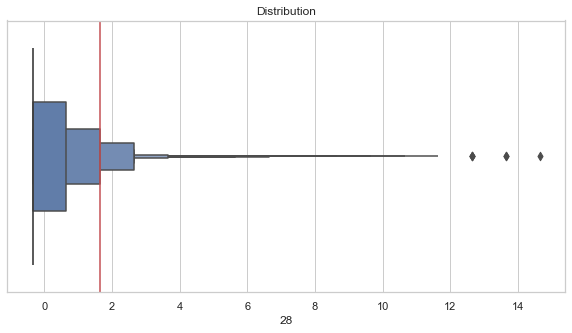

 83%|████████▎ | 205/248 [01:02<00:16,  2.61it/s]

--------------------------------------------------
                     7
--------------------------------------------------
99 quantile is 336.4638977050781


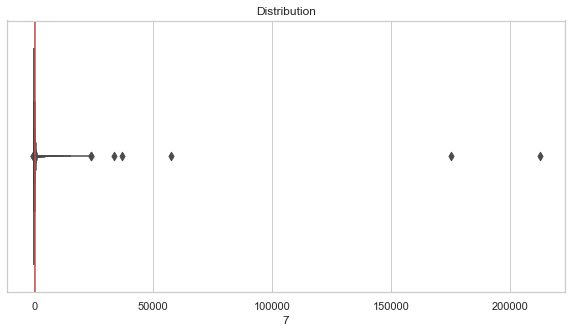

 83%|████████▎ | 206/248 [01:02<00:15,  2.71it/s]

--------------------------------------------------
                     52
--------------------------------------------------
99 quantile is 115.82828521728516


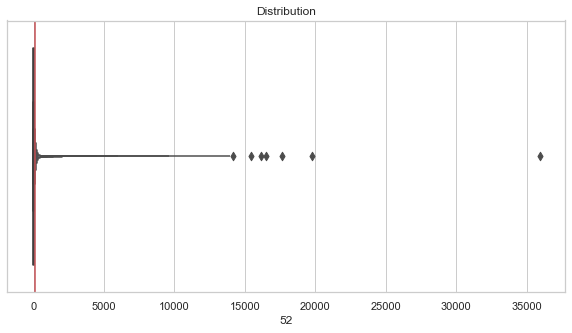

 83%|████████▎ | 207/248 [01:02<00:15,  2.62it/s]

--------------------------------------------------
                     54
--------------------------------------------------
99 quantile is 15.041297912597656


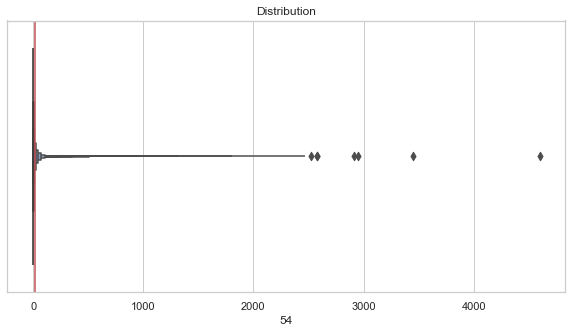

 84%|████████▍ | 208/248 [01:03<00:14,  2.78it/s]

--------------------------------------------------
                     219
--------------------------------------------------
99 quantile is 1.3792279958724976


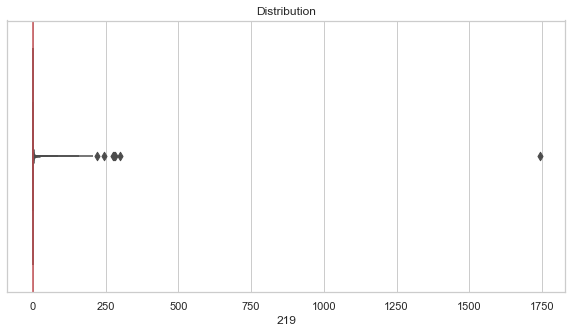

 84%|████████▍ | 209/248 [01:03<00:13,  2.86it/s]

--------------------------------------------------
                     220
--------------------------------------------------
99 quantile is -0.012256765738129616


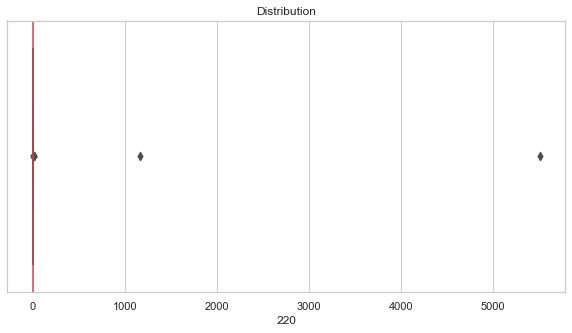

 85%|████████▍ | 210/248 [01:03<00:11,  3.19it/s]

--------------------------------------------------
                     82
--------------------------------------------------
99 quantile is -0.2487553060054779


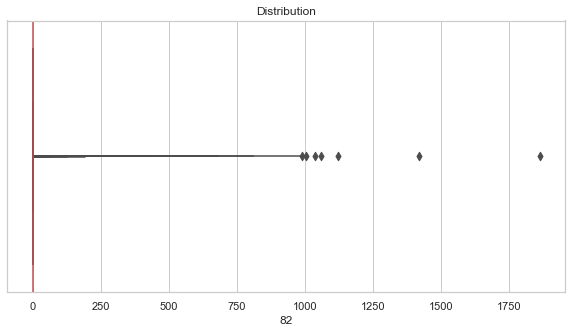

 85%|████████▌ | 211/248 [01:04<00:11,  3.24it/s]

--------------------------------------------------
                     152
--------------------------------------------------
99 quantile is -0.21264643967151642


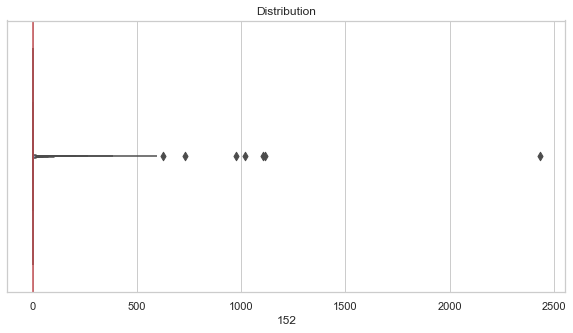

 85%|████████▌ | 212/248 [01:04<00:10,  3.55it/s]

--------------------------------------------------
                     231
--------------------------------------------------
99 quantile is -0.3646937906742096


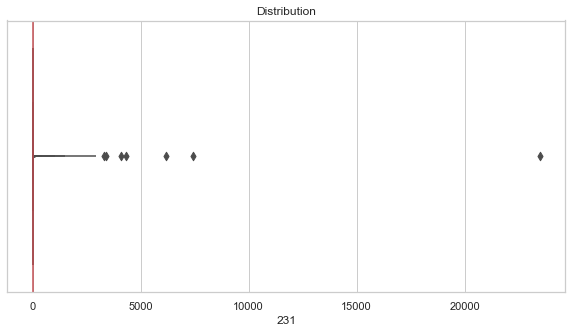

 86%|████████▌ | 213/248 [01:04<00:09,  3.79it/s]

--------------------------------------------------
                     96
--------------------------------------------------
99 quantile is -0.2501877248287201


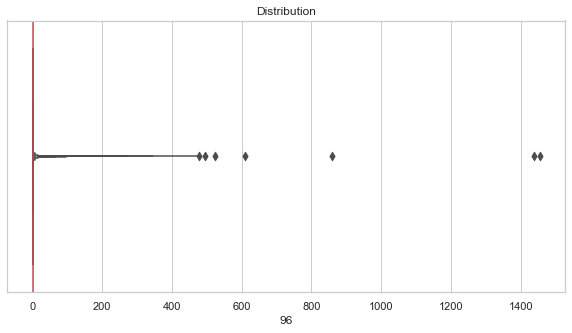

 86%|████████▋ | 214/248 [01:04<00:09,  3.71it/s]

--------------------------------------------------
                     218
--------------------------------------------------
99 quantile is -4.033216100651771e-05


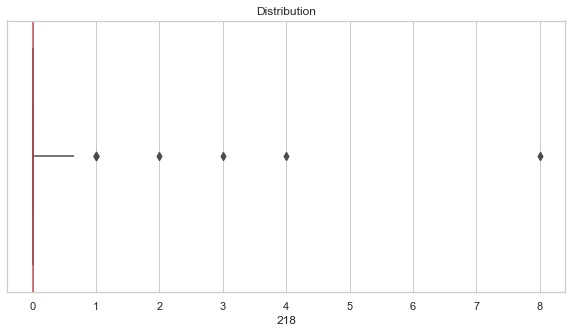

 87%|████████▋ | 215/248 [01:05<00:10,  3.20it/s]

--------------------------------------------------
                     235
--------------------------------------------------
99 quantile is -109.88456726074219


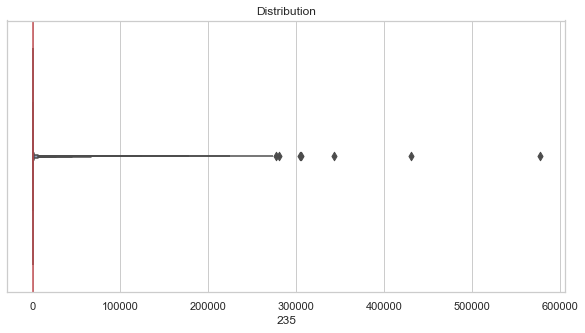

 87%|████████▋ | 216/248 [01:05<00:10,  3.15it/s]

--------------------------------------------------
                     223
--------------------------------------------------
99 quantile is 348.2359313964844


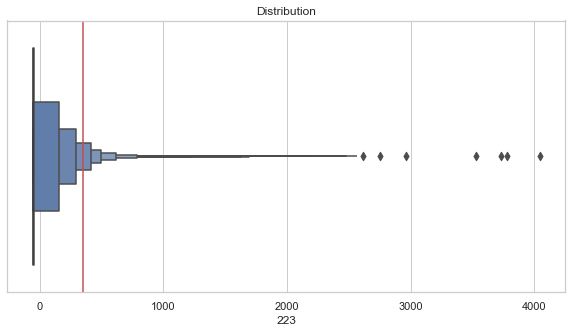

 88%|████████▊ | 217/248 [01:05<00:09,  3.34it/s]

--------------------------------------------------
                     0
--------------------------------------------------
99 quantile is 367.6100158691406


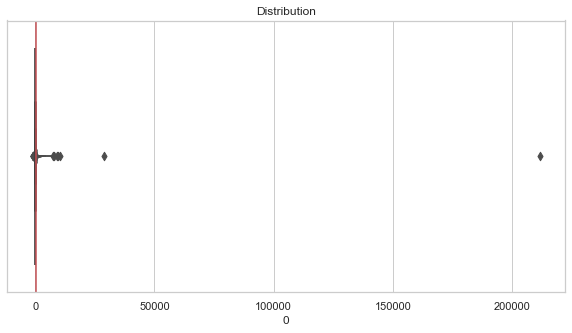

 88%|████████▊ | 218/248 [01:06<00:09,  3.11it/s]

--------------------------------------------------
                     116
--------------------------------------------------
99 quantile is 10032.982812499986


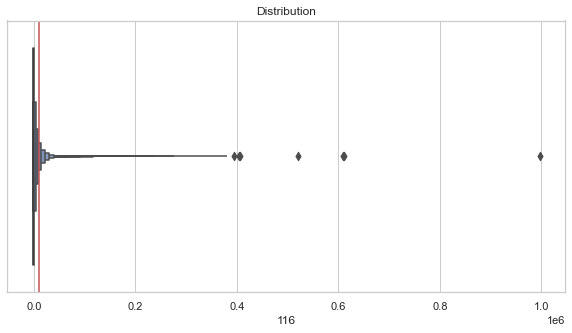

 88%|████████▊ | 219/248 [01:06<00:09,  2.94it/s]

--------------------------------------------------
                     248
--------------------------------------------------
99 quantile is 64.1671142578125


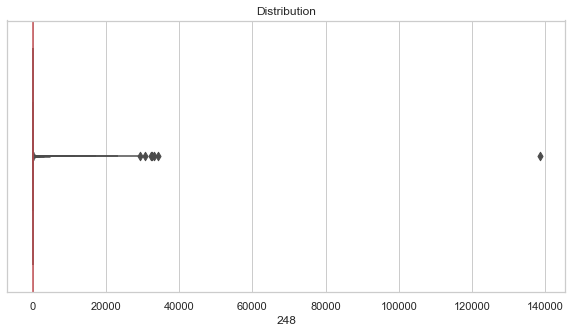

 89%|████████▊ | 220/248 [01:07<00:10,  2.60it/s]

--------------------------------------------------
                     135
--------------------------------------------------
99 quantile is 6.856777191162109


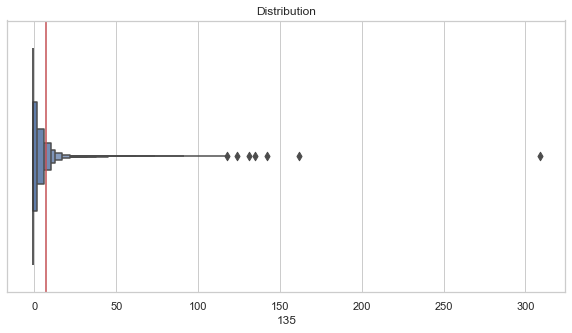

 89%|████████▉ | 221/248 [01:07<00:09,  2.71it/s]

--------------------------------------------------
                     18
--------------------------------------------------
99 quantile is -3.7274603843688965


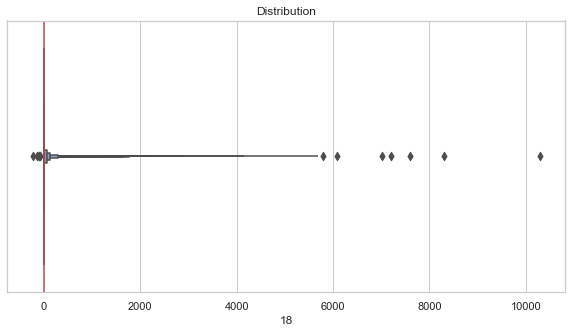

 90%|████████▉ | 222/248 [01:07<00:09,  2.81it/s]

--------------------------------------------------
                     13
--------------------------------------------------
99 quantile is 329.34088134765625


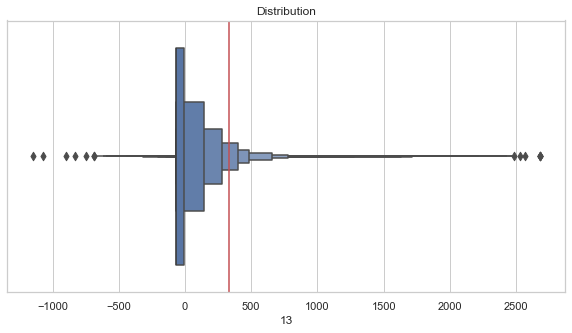

 90%|████████▉ | 223/248 [01:08<00:08,  2.82it/s]

--------------------------------------------------
                     11
--------------------------------------------------
99 quantile is 0.7829589962958308


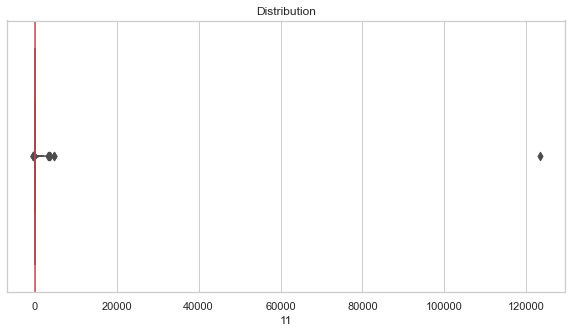

 90%|█████████ | 224/248 [01:08<00:08,  2.89it/s]

--------------------------------------------------
                     141
--------------------------------------------------
99 quantile is -0.020136605948209763


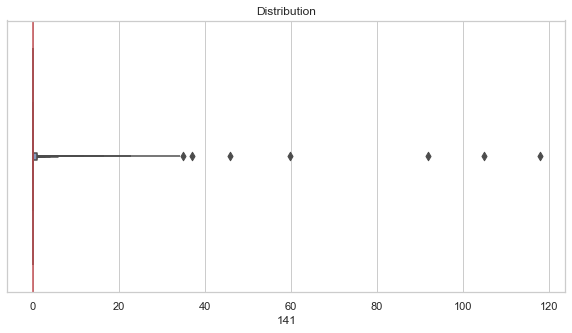

 91%|█████████ | 225/248 [01:08<00:07,  3.00it/s]

--------------------------------------------------
                     3
--------------------------------------------------
99 quantile is 700.5612060546856


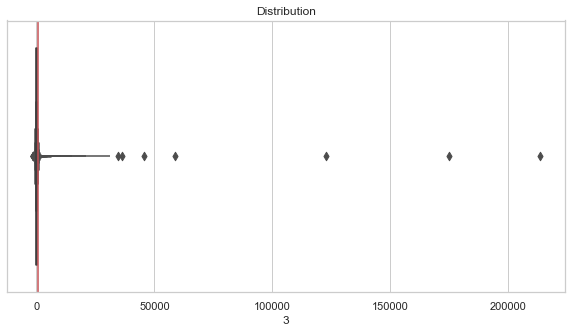

 91%|█████████ | 226/248 [01:09<00:07,  2.88it/s]

--------------------------------------------------
                     17
--------------------------------------------------
99 quantile is -0.10704103857278824


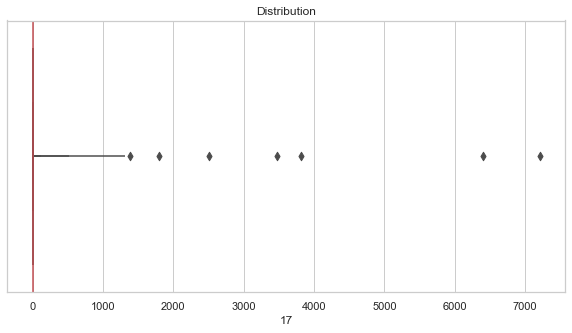

 92%|█████████▏| 227/248 [01:09<00:07,  2.84it/s]

--------------------------------------------------
                     145
--------------------------------------------------
99 quantile is 35.03636932373047


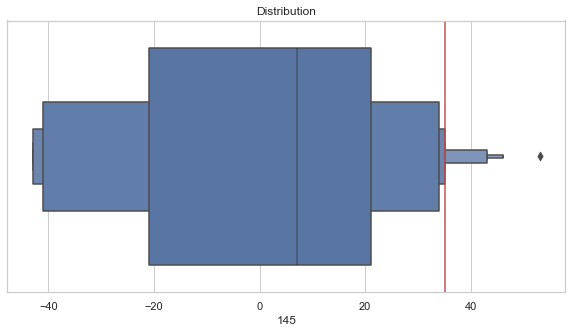

 92%|█████████▏| 228/248 [01:09<00:07,  2.79it/s]

--------------------------------------------------
                     5
--------------------------------------------------
99 quantile is 740.9982299804688


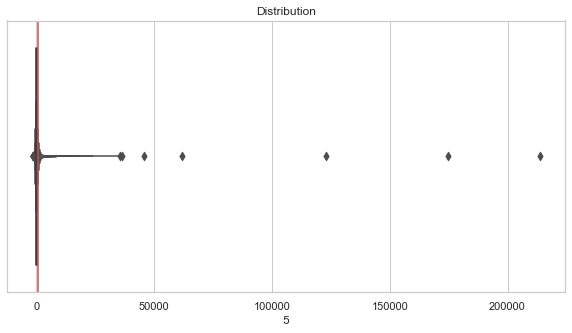

 92%|█████████▏| 229/248 [01:10<00:07,  2.45it/s]

--------------------------------------------------
                     44
--------------------------------------------------
99 quantile is 139.71414184570312


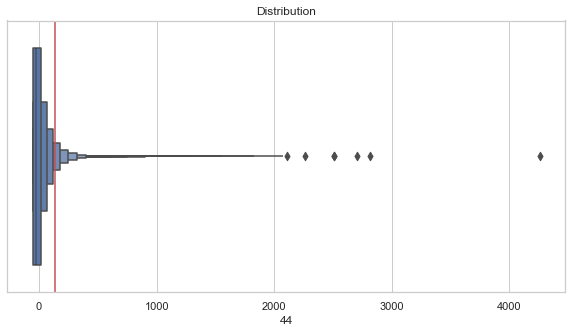

 93%|█████████▎| 230/248 [01:10<00:07,  2.40it/s]

--------------------------------------------------
                     164
--------------------------------------------------
99 quantile is 0.27049246430397034


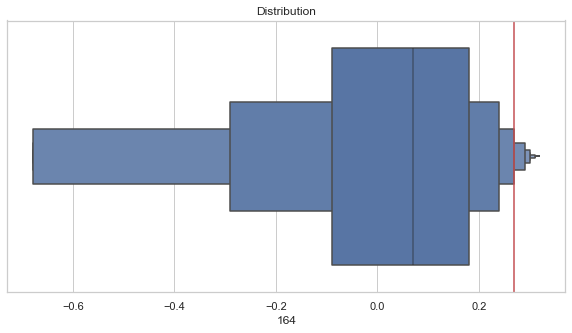

 93%|█████████▎| 231/248 [01:11<00:07,  2.33it/s]

--------------------------------------------------
                     247
--------------------------------------------------
99 quantile is 817.2522583007812


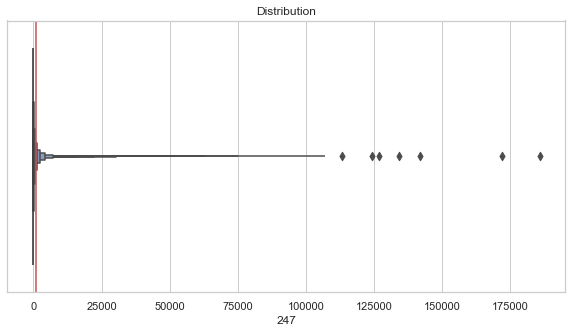

 94%|█████████▎| 232/248 [01:11<00:06,  2.42it/s]

--------------------------------------------------
                     128
--------------------------------------------------
99 quantile is 0.41487130522727966


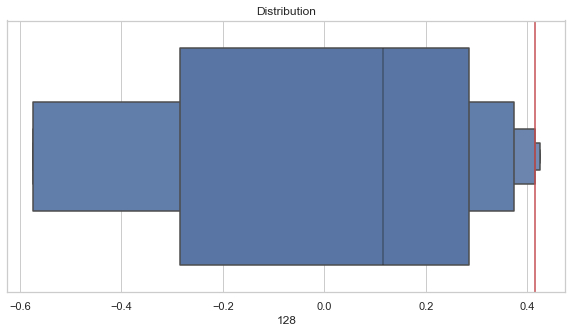

 94%|█████████▍| 233/248 [01:11<00:06,  2.41it/s]

--------------------------------------------------
                     165
--------------------------------------------------
99 quantile is 55.81683349609375


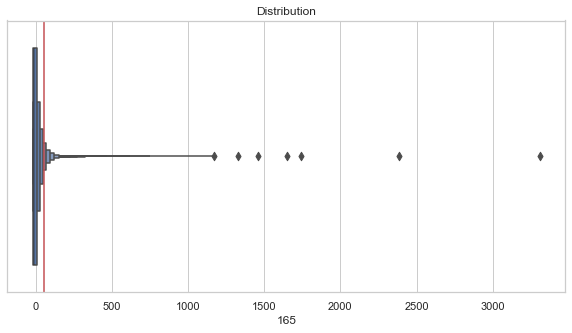

 94%|█████████▍| 234/248 [01:12<00:06,  2.26it/s]

--------------------------------------------------
                     213
--------------------------------------------------
99 quantile is -39301.16796875


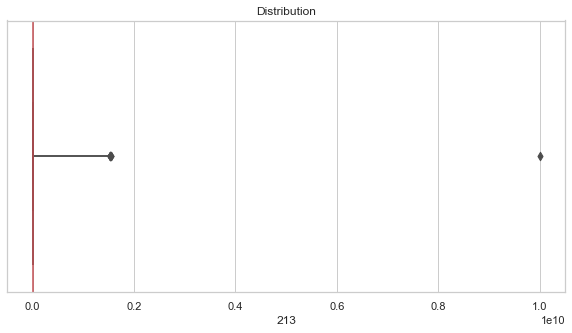

 95%|█████████▍| 235/248 [01:12<00:05,  2.33it/s]

--------------------------------------------------
                     224
--------------------------------------------------
99 quantile is 1089968256.0


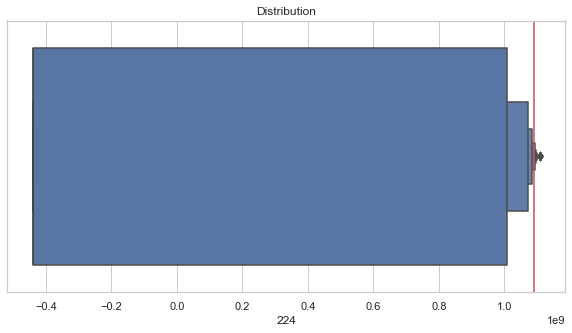

 95%|█████████▌| 236/248 [01:13<00:04,  2.48it/s]

--------------------------------------------------
                     238
--------------------------------------------------
99 quantile is 1254.8892822265625


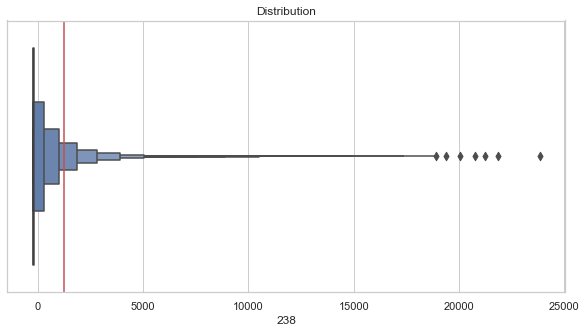

 96%|█████████▌| 237/248 [01:13<00:04,  2.52it/s]

--------------------------------------------------
                     8
--------------------------------------------------
99 quantile is 3.3763396739959717


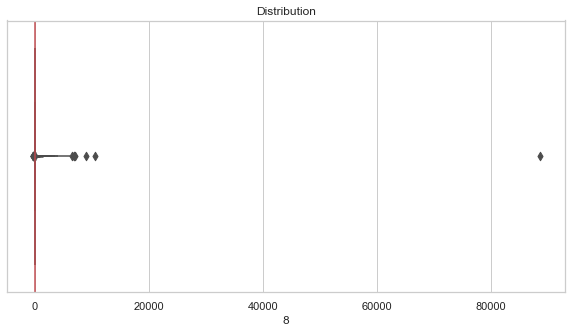

 96%|█████████▌| 238/248 [01:13<00:03,  2.82it/s]

--------------------------------------------------
                     60
--------------------------------------------------
99 quantile is 0.6347658634185791


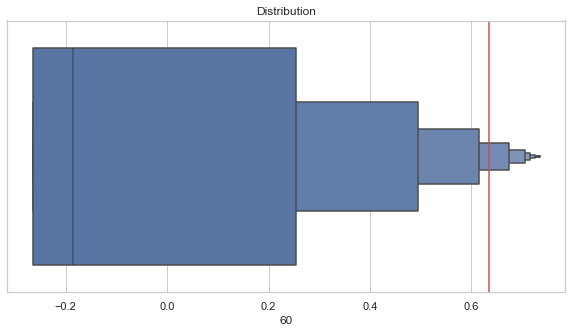

 96%|█████████▋| 239/248 [01:14<00:03,  2.78it/s]

--------------------------------------------------
                     121
--------------------------------------------------
99 quantile is -0.43313518166542053


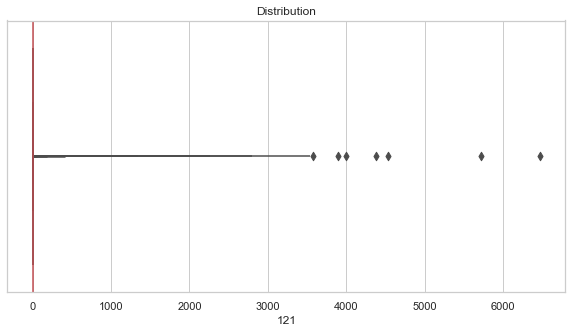

 97%|█████████▋| 240/248 [01:14<00:02,  2.91it/s]

--------------------------------------------------
                     84
--------------------------------------------------
99 quantile is -0.13408759236335754


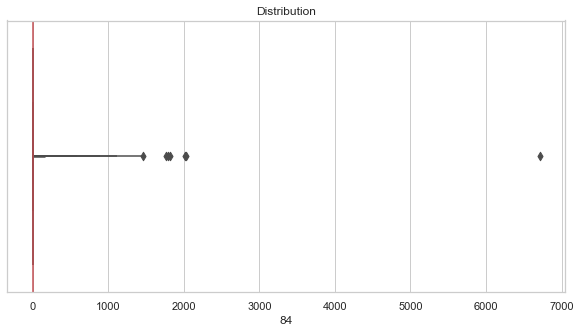

 97%|█████████▋| 241/248 [01:14<00:02,  3.18it/s]

--------------------------------------------------
                     99
--------------------------------------------------
99 quantile is -42.27591323852539


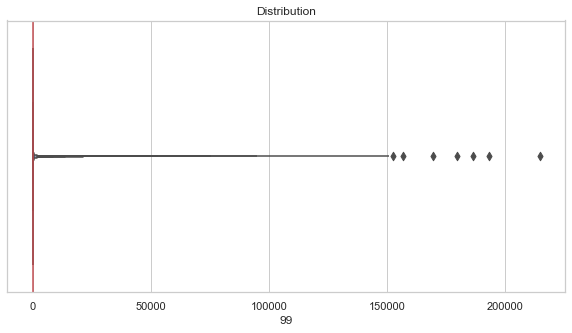

 98%|█████████▊| 242/248 [01:15<00:01,  3.20it/s]

--------------------------------------------------
                     4
--------------------------------------------------
99 quantile is 392.311767578125


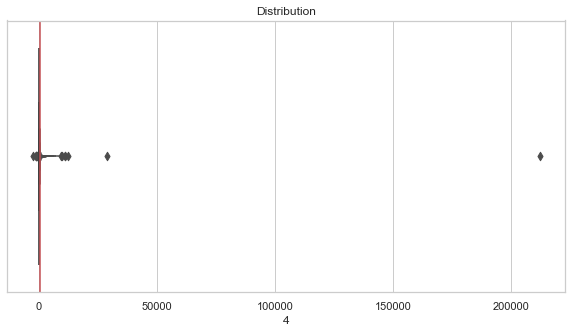

 98%|█████████▊| 243/248 [01:15<00:01,  2.98it/s]

--------------------------------------------------
                     158
--------------------------------------------------
99 quantile is 1.463685154914856


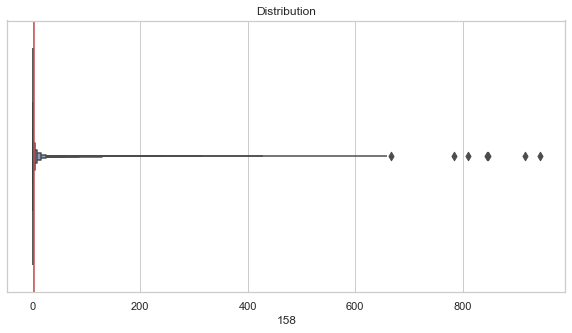

 98%|█████████▊| 244/248 [01:15<00:01,  3.07it/s]

--------------------------------------------------
                     216
--------------------------------------------------
99 quantile is -8.332358265761286e-05


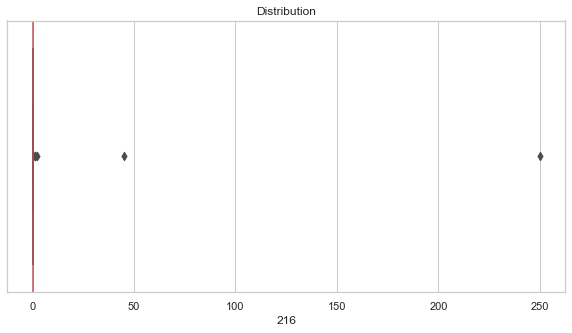

 99%|█████████▉| 245/248 [01:16<00:00,  3.25it/s]

--------------------------------------------------
                     66
--------------------------------------------------
99 quantile is -0.044464629143476486


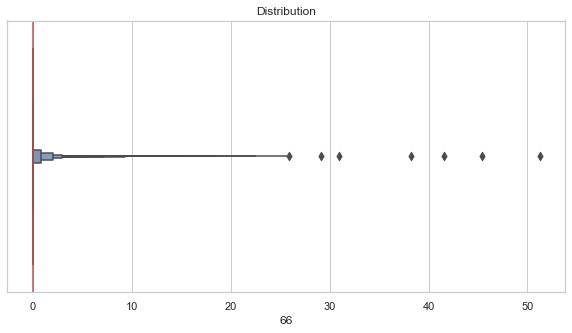

 99%|█████████▉| 246/248 [01:16<00:00,  3.46it/s]

--------------------------------------------------
                     179
--------------------------------------------------
99 quantile is -0.001430683652870357


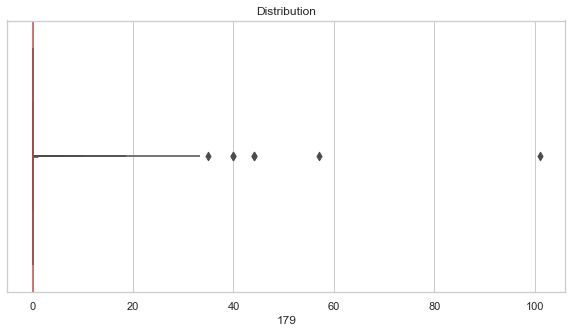

100%|█████████▉| 247/248 [01:16<00:00,  3.50it/s]

--------------------------------------------------
                     150
--------------------------------------------------
99 quantile is 0.6067312359809875


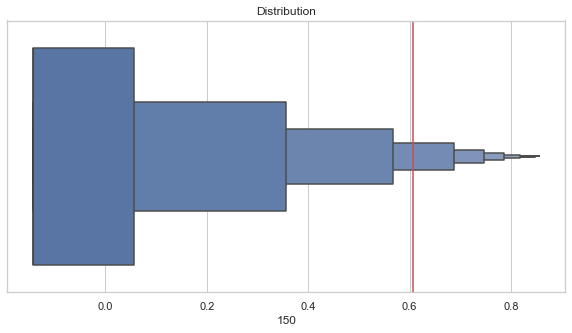

100%|██████████| 248/248 [01:16<00:00,  3.22it/s]


In [26]:
def print_report(df: pd.DataFrame or dd.DataFrame, 
                 columns_list: list,  
                 quantile: int = .95):
    """
    Report is printed for numeric data
    
    Input
    -----
        df: input dataframe witch can be pandas.DataFrame or dask.DataFrame
        columns_list: lins of numerc columns
        quantile: quntile for select columns with outliners
        
    Return
    ------
        is_cat_features and columns_with_outliners. is_cat_features dict with columns name and count
        of unique values. columns_with_outliners is list with columns name with values contains 
        outliners
        
    """
    
    is_cat_features = dict()
    columns_with_outliners = list()
    
    is_dask_datafram = False
    if isinstance(df, dd.DataFrame):
        is_dask_datafram = True
    
    for column in tqdm(columns_list):
        print('-' * 50)
        print(' ' * 20, column)
        print('-' * 50)
        
        nunique_values = df[column].nunique().compute() if is_dask_datafram else df[column].nunique()
        
        # calc category features
        if nunique_values < 5:
            print('Unique values is ', df[column].unique().compute if is_dask_datafram else df[column].unique()) 
            is_cat_features[column] = nunique_values
            
        column_values = df[column].compute() if is_dask_datafram else df[column]
        q = column_values.quantile(q=quantile)
        print('99 quantile is', q)
        
        # calc count of features with outliners 
        if column_values.max() > q * 1.5:
            columns_with_outliners.append(column)
        
        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # ax1.set_title('Box plots')
        plt.figure(figsize=(10, 5))
        plt.title('Distribution')
        
        sns.boxenplot(x=column_values)

        
        plt.axvline(x=q, c='r')
        plt.show()
        
    return is_cat_features, columns_with_outliners

is_cat_features, columns_with_outliners = print_report(df=data_train_merge, columns_list=list(NUMERIC_FEATURES))


**Выводы:** большое количество выбросов, их нужно обработать

## Категориальные признаки

In [23]:
def get_confidence_intervals(x: str, y: str, df_x_y: pd.DataFrame):
    """
    Функция для построение доверительных интервалов
    
    Parametrs
    ---------
        y: значение по оси y
        df_x_y: датафрейм с данными
        x: значение по оси x
    
    Return
    ------
        None
    
    How to use
    ----------
        get_confidence_intervals('column_1', 'tatget', df[['column_1', 'target']])
    """

    plt.figure(figsize=(8, 5))

    sns.pointplot(x=x, y=y, data=df_x_y, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {y}')
    plt.show()

Проверим, является ли предпологаемые значения категориальными фитчами используя весь dataset features

In [24]:
cat_features = dict()

for column in tqdm(is_cat_features):
    cat_features[column] = features_ddf[column].nunique().compute()
    

100%|██████████| 21/21 [25:58<00:00, 74.19s/it]


In [25]:
cat_features

{'33': 2,
 '192': 2,
 '199': 2,
 '27': 2,
 '196': 2,
 '95': 16,
 '202': 2,
 '26': 2,
 '200': 2,
 '57': 2,
 '206': 2,
 '201': 2,
 '32': 2,
 '132': 2,
 '197': 2,
 '195': 2,
 '205': 2,
 '204': 2,
 '31': 2,
 '194': 2,
 '198': 2}

In [22]:
cat_features = ['33', '192', '199', '27', '196', '202', '26', '200', '57', '206', '201', '32', '132', '197', '195', '205', '204', '31', '194', '198']

In [23]:
CATEGORIES_FEATURES = CATEGORIES_FEATURES | set(cat_features)
NUMERIC_FEATURES = NUMERIC_FEATURES - set(cat_features)

  0%|          | 0/21 [00:00<?, ?it/s]

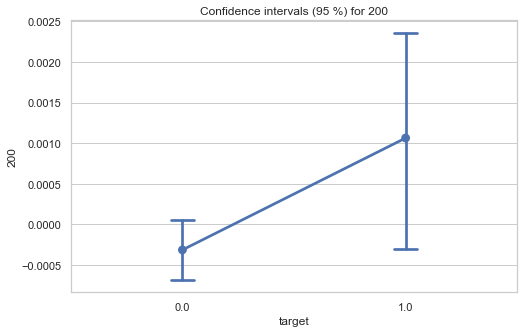

  5%|▍         | 1/21 [00:18<06:03, 18.18s/it]

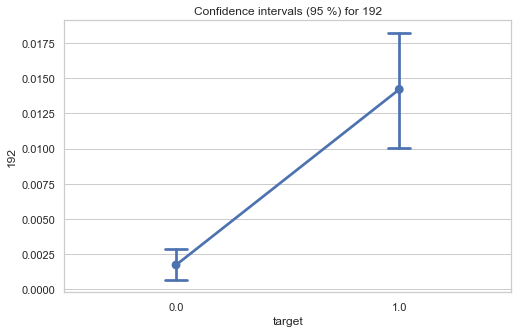

 10%|▉         | 2/21 [00:33<05:17, 16.69s/it]

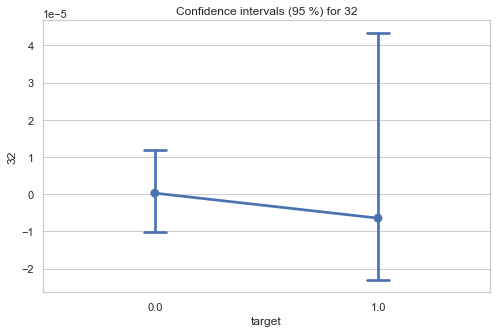

 14%|█▍        | 3/21 [00:48<04:40, 15.56s/it]

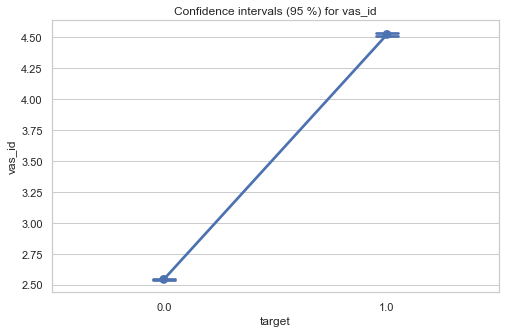

 19%|█▉        | 4/21 [01:02<04:15, 15.02s/it]

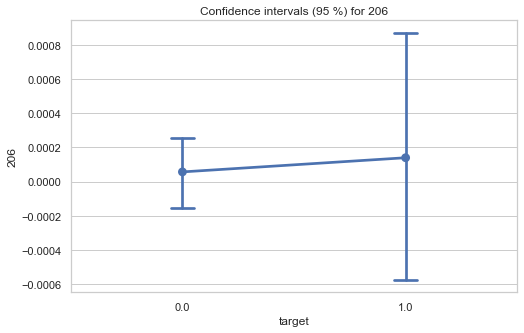

 24%|██▍       | 5/21 [01:16<03:56, 14.76s/it]

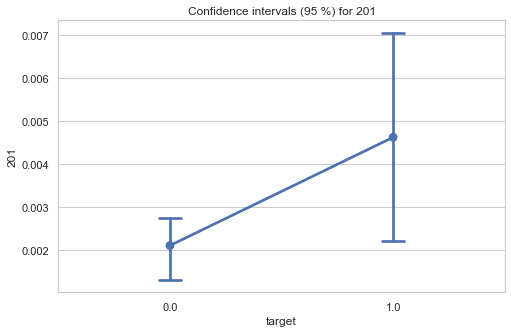

 29%|██▊       | 6/21 [01:30<03:38, 14.58s/it]

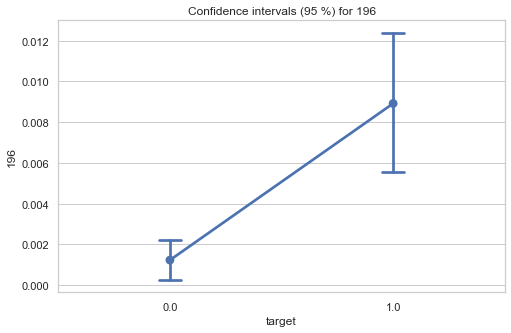

 33%|███▎      | 7/21 [01:45<03:23, 14.51s/it]

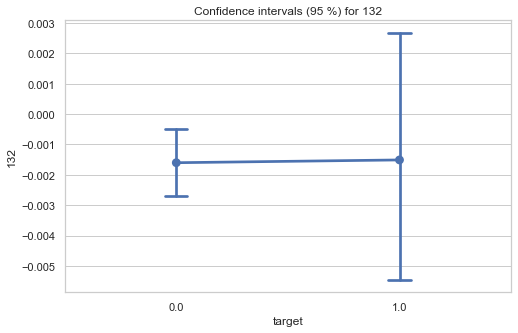

 38%|███▊      | 8/21 [01:59<03:07, 14.43s/it]

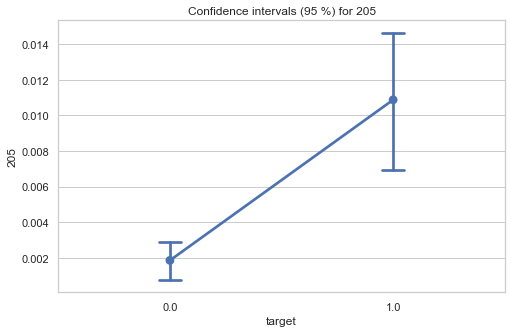

 43%|████▎     | 9/21 [02:13<02:52, 14.36s/it]

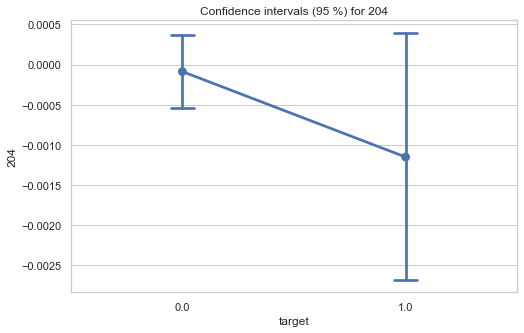

 48%|████▊     | 10/21 [02:27<02:37, 14.35s/it]

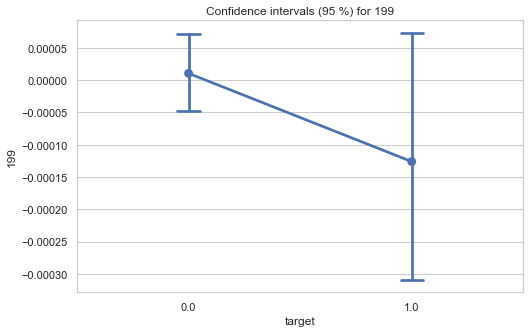

 52%|█████▏    | 11/21 [02:42<02:24, 14.40s/it]

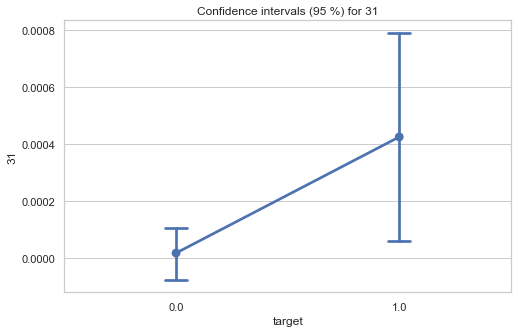

 57%|█████▋    | 12/21 [02:56<02:09, 14.39s/it]

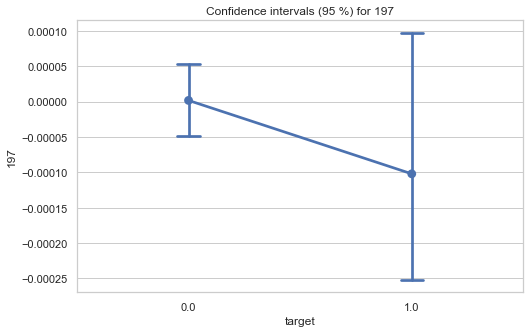

 62%|██████▏   | 13/21 [03:11<01:55, 14.49s/it]

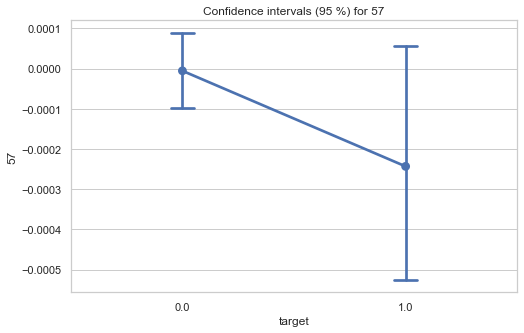

 67%|██████▋   | 14/21 [03:25<01:40, 14.40s/it]

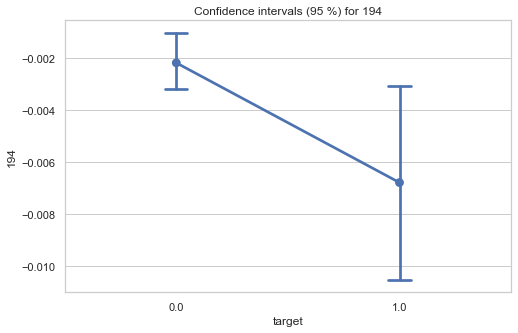

 71%|███████▏  | 15/21 [03:39<01:26, 14.35s/it]

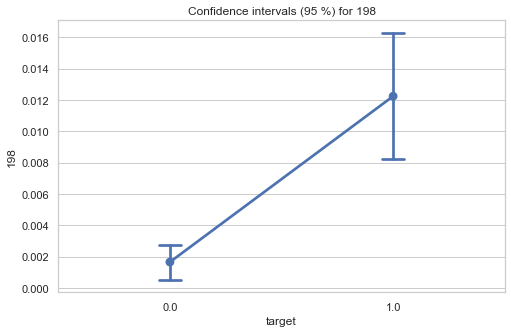

 76%|███████▌  | 16/21 [03:54<01:11, 14.37s/it]

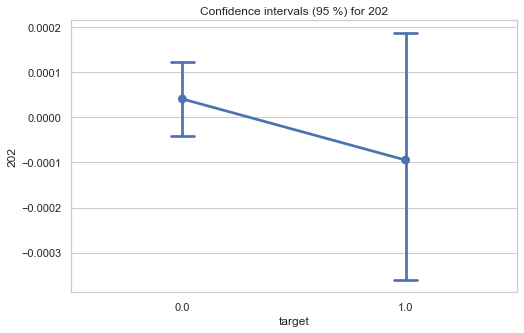

 81%|████████  | 17/21 [04:08<00:57, 14.30s/it]

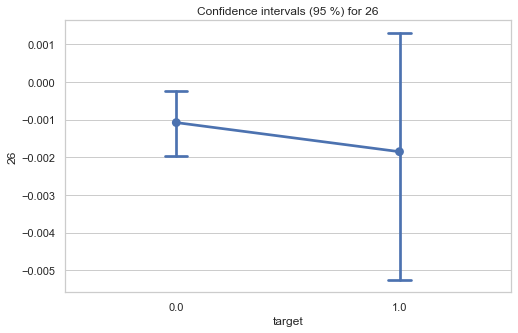

 86%|████████▌ | 18/21 [04:23<00:43, 14.62s/it]

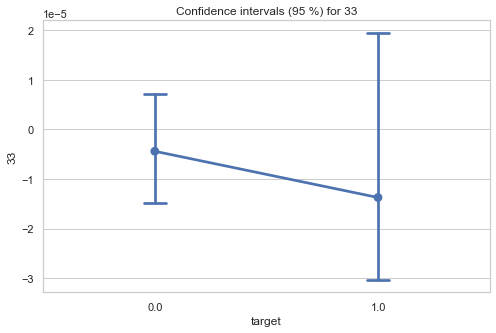

 90%|█████████ | 19/21 [04:41<00:31, 15.54s/it]

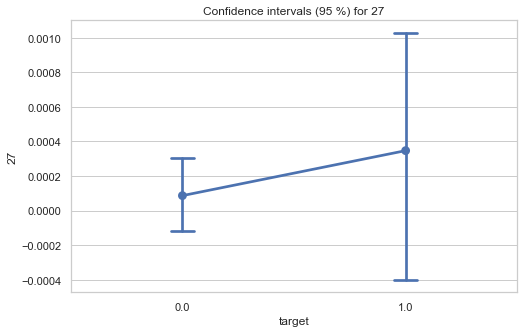

 95%|█████████▌| 20/21 [04:57<00:15, 15.71s/it]

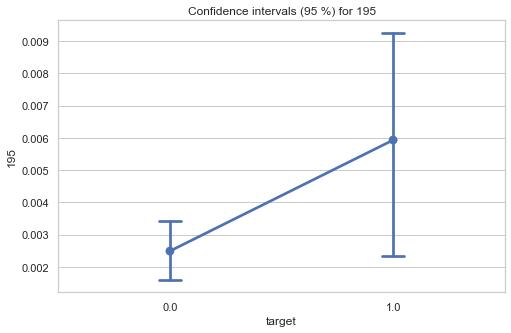

100%|██████████| 21/21 [05:12<00:00, 14.90s/it]


In [30]:
for column in tqdm(list(CATEGORIES_FEATURES)):
    get_confidence_intervals(y=column, x=TARGET_COLUMN_NAME, df_x_y=data_train_merge)

#### Вывод: признаки 197, 33, 27, 202, 32, 26, 132, 206 - претиденты на выброс, т.к. одинаково влияет на целевую переменную

# Сокращение размерности 

In [29]:
CONST_FEATURES

{'139', '203', '75', '81', '85'}

Проверим на всем ли датасете features эти колонки имеют одоно и тоже значение

In [ ]:
unique_dict = dict()

for column in tqdm(list(CONST_FEATURES)):
    unique_dict[column] = features_ddf[column].nunique().compute()

100%|██████████| 5/5 [07:26<00:00, 89.32s/it]


In [ ]:
unique_dict

{'85': 1, '75': 1, '139': 1, '81': 1, '203': 1}

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X.loc[:, self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [25]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
#         if not isinstance(X, pd.DataFrame):
#             raise TypeError('Input data must be pd.DataFrame')
        
        try:
            return X.drop(columns=self.columns, axis=1)
            
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame doesn't contain this coluumn name: %s" % cols_error)

In [ ]:
# TODO: Убрать остальные признаки которые мы хотим удали выявлены в процессе EDA

In [26]:
drop_cat_features = set(['197', '33', '27', '202', '32', '26', '132', '206'])
drop_num_features = set(['244', '136', '122', '232', '125', '135', '198', '26', '84', '49', '201', '123', '137', '41', '228', '217', '209', '219'])

NUMERIC_FEATURES = NUMERIC_FEATURES - drop_cat_features - drop_num_features
CATEGORIES_FEATURES = CATEGORIES_FEATURES - drop_cat_features - drop_num_features


In [27]:

drop_unusefull_features = Pipeline([
    ('drop_const_feat', DropColumns(
        columns=list(
            CONST_FEATURES.union(DOESNT_INTERESTING_FEATURES).union(drop_cat_features).union(drop_num_features)
        )
    ))
])

drop_unusefull_features.fit_transform(data_train_merge.drop(TARGET_COLUMN_NAME, axis=1)).head(2)

,vas_id,0,1,2,3,4,5,6,7,8,...,242,243,245,246,247,248,249,250,251,252
0,2.0,314.560028,9.290888,342.989227,7.523202,337.571747,-13.581790,-16.08618,-65.076096,-6.78366,...,305.704590,6488.625977,-24.996269,121.369553,142.252274,-16.832888,-0.694429,-11.175933,-0.45614,0.0
1,2.0,93.880028,-217.499115,79.939217,-270.106812,74.521751,-291.211792,-16.08618,-65.076096,-6.78366,...,-17.295406,-977.373840,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


# Обработка выбросов

## Для sklearn подобных моделей

In [28]:
class HandleOutliners(BaseEstimator, TransformerMixin):
    def __init__(self, quantile=.99) -> None:
        self.quantile = quantile
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns.to_list():
            X.loc[X[col] > X[col].quantile(q=self.quantile), col] = np.nan
        return X


In [29]:
class CustumSimpleImputer(SimpleImputer):
    def transform(self, X):
        column_list = X.columns.to_list()        
        return pd.DataFrame(data=super().transform(X), columns=column_list)

In [30]:
handler_outliners = Pipeline([
    ('handler_outliners', HandleOutliners()),
    ('simple_imputer', CustumSimpleImputer(strategy='mean'))
])

In [31]:
handler_outliners.fit_transform(data_train_merge[NUMERIC_FEATURES].copy()).shape

(831653, 213)

## Для CatBoost

In [31]:
class HandleOutlinersCatBoostWrapper(HandleOutliners):
    def __init__(self, columns_list, quantile=0.99) -> None:
        super().__init__(quantile)
        self.columns_list = columns_list
    
    def transform(self, X, y=None):
        X.loc[:, self.columns_list] = super().transform(X.loc[:, self.columns_list], y)
        return X

In [32]:
handler_outliners_catboost = Pipeline([
    ('handler_outliners', HandleOutlinersCatBoostWrapper(columns_list=list(NUMERIC_FEATURES))),
    ('simple_imputer', CustumSimpleImputer(strategy='mean'))
])

In [39]:
handler_outliners_catboost.fit_transform(data_train_merge.drop('buy_time', axis=1)).isna().sum().sum()

0

# Обработка пропусков

In [66]:
data_train_merge.isna().sum().sum()

0

# Обработка числовых признаков

In [33]:
handler_numeric_features = Pipeline([
    ('select_numeric_features', ColumnSelector(columns=list(NUMERIC_FEATURES))),
    ('handle_outliners', handler_outliners),
    ('standart_scaller', StandardScaler())
])

In [35]:
handler_numeric_features.fit_transform(data_train_merge).shape

(831653, 213)

# Построение новых признаков

In [ ]:
# BaseLine - без новых признков (stupid gen)

## Категориальные признаки

In [ ]:
# TODO: Попробовать увеличить количество категориальных признаков 

In [34]:
class SetCategoryType(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.type_name = 'category'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(self.type_name).categorize(columns=list(CATEGORIES_FEATURES))

In [35]:
handler_category_features = Pipeline([
    ('select_cat_features', ColumnSelector(columns=list(CATEGORIES_FEATURES))),
    ('one_hot_encode', OneHotEncoder())
])

In [ ]:
handler_category_features.fit_transform(X=data_train_merge).shape

# Pipeline обработки признаков

In [36]:
feature_preprocessing = Pipeline([
    ('drop_unusefull_features', drop_unusefull_features),
    ('feature_preprocessing', FeatureUnion(transformer_list=[
        ('handler_category_features', handler_category_features),
        ('handler_numeric_features', handler_numeric_features)
    ]))
])

In [39]:
feature_preprocessing.fit_transform(data_train_merge.drop(TARGET_COLUMN_NAME, axis=1)).shape

(831653, 241)

In [37]:
class ChangeDtypes(BaseEstimator, TransformerMixin):
    def __init__(self, dtype_name, columns_list) -> None:
        self.dtype_name = dtype_name
        self.columns_list = columns_list
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.columns_list] = X[self.columns_list].astype(self.dtype_name)
        return X

In [38]:
# feature_preprocessing for catboost
feature_preprocessing_catboost = Pipeline([
    ('drop_unusefull_features', drop_unusefull_features),
    ('heandle_outliners', handler_outliners_catboost),
    ('type_changer', ChangeDtypes(dtype_name='str', columns_list=list(CATEGORIES_FEATURES))),
])

In [66]:
feature_preprocessing_catboost.fit_transform(data_train_merge.copy()).shape

(831653, 225)

# Разбиение на train и test

In [39]:
X = data_train_merge.drop(TARGET_COLUMN_NAME, axis=1)
y = data_train_merge[TARGET_COLUMN_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    shuffle=True,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

# Создание KFold

In [40]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Построение модели

In [41]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Функция для отображения отчета результата работы модели классификации
    
    Params
    ------
        y_train_true: реальные значения целевой переменной на тренировочной выборке
        y_train_pred: предсказанные значения целевой переменной на тренировочной выборке
        y_test_true: реальные значения целевой переменной на тестовой выборке
        y_test_pred: предсказанные значения целевой переменной на тестовой выборке
    
    Return:
    ------
        classification reports
    """
    
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [42]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    """
    Получение предсказания модели и вывод отчета предсказания
    
    Params
    ------
        model: обученная модель
        X_train: DataFrame обучающех признаков
        X_test: DataFrame тестовой выборки
        y_train: реальные значения меток для обущающей выборки
        y_test: реальное значение меток для тестовой выборки
    
    Return
    ------
        classification reports
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [84]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1_macro'):
    
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

## Logistic regression

<table border="1">
   <caption>Result of research</caption>
   <tr>
    <th>Score</th>
    <th>Base Line</th>
    <th>Without outliners</th>
    <th>Clean unusefull columns</th>
   </tr>
   <tr>
      <th>f1 {0}</th>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
   </tr>
   <tr>
      <th>f1 {1}</th>
      <td>0.45</td>
      <td>0.45</td>
      <td>0.45</td>
   </tr>
   <tr>
      <th>marco avg</th>
      <td>0.69</td>
      <td>0.69</td>
      <td>0.69</td>
   </tr>
  </table>
 </body>

In [101]:
y[y == 0].shape[0] / y[y == 1].shape[0]

12.818047386435383

In [78]:
from sklearn.linear_model import Lasso

lasso_preprocessing = make_pipeline(
    feature_preprocessing,
    SelectFromModel(Lasso(alpha=1e-1, random_state=RANDOM_STATE), threshold=1e-5)
)

In [74]:
lasso_preprocessing = make_pipeline(
    feature_preprocessing,
    SelectFromModel(Lasso(alpha=1e-1, random_state=RANDOM_STATE)),
)

In [79]:
lasso_preprocessing.fit(X_train, y_train)
lasso_preprocessing.transform(X_test).shape

C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\feature_selection\_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"


(249496, 0)

In [58]:
feature_preprocessing.fit(X_train)
feature_preprocessing.transform(X_test).shape

(249496, 241)

In [93]:
logistic_classification_pipeline = make_pipeline(
    feature_preprocessing,
    # SelectFromModel(Lasso(alpha=1e-2, random_state=RANDOM_STATE), threshold=1e-5),
    # SelectFromModel(lgbm.LGBMClassifier(random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
)

In [99]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1],
    'logisticregression__class_weight':[
        {0:1, 1:12.8},
        {0:1, 1:11},
        {0:1, 1:10},
    ] 
}

In [100]:
run_grid_search(logistic_classification_pipeline, 
                data_train_merge.drop(TARGET_COLUMN_NAME, axis=1), 
                data_train_merge[TARGET_COLUMN_NAME], 
                params_grid=param_grid,
                cv=kfold_cv)

Best f1_macro score: 0.69

Best parameters set found on development set:

{'logisticregression__C': 0.01, 'logisticregression__class_weight': {0: 1, 1: 11}}

Grid scores on development set:

0.687 (+/-0.003) for {'logisticregression__C': 0.01, 'logisticregression__class_weight': {0: 1, 1: 12.8}}
0.687 (+/-0.003) for {'logisticregression__C': 0.01, 'logisticregression__class_weight': {0: 1, 1: 11}}
0.687 (+/-0.003) for {'logisticregression__C': 0.01, 'logisticregression__class_weight': {0: 1, 1: 10}}
0.687 (+/-0.003) for {'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 1, 1: 12.8}}
0.687 (+/-0.003) for {'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 1, 1: 11}}
0.687 (+/-0.003) for {'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 1, 1: 10}}
0.687 (+/-0.003) for {'logisticregression__C': 1, 'logisticregression__class_weight': {0: 1, 1: 12.8}}
0.687 (+/-0.003) for {'logisticregression__C': 1, 'logisticregression__class_weig

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('drop_unusefull_features',
                                                         Pipeline(steps=[('drop_const_feat',
                                                                          DropColumns(columns=['32',
                                                                                               'id',
                                                                                               '201',
                                                                                               '197',
                                                                                               '228',
                                                                                               '125',
                                                                                               

In [94]:
logistic_classification_pipeline.fit(X_train, y_train)
evaluate_preds(logistic_classification_pipeline, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    540027
         1.0       0.32      0.79      0.45     42130

    accuracy                           0.86    582157
   macro avg       0.65      0.83      0.69    582157
weighted avg       0.93      0.86      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231440
         1.0       0.32      0.78      0.45     18056

    accuracy                           0.86    249496
   macro avg       0.65      0.83      0.69    249496
weighted avg       0.93      0.86      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     200887  30553
1.0       3900  14156


## XGBoost

<table border="1">
   <caption>Result of research</caption>
   <tr>
    <th>Score</th>
    <th>Base Line</th>
    <th>Without outliners</th>
    <th>Clean unusefull columns</th>
   </tr>
   <tr>
      <th>f1 {0}</th>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.96</td>
      <td></td>
   </tr>
   <tr>
      <th>f1 {1}</th>
      <td>0.00</td>
      <td>0.00</td>
      <td>0.00</td>
      <td></td>
   </tr>
   <tr>
      <th>marco avg</th>
      <td>0.48</td>
      <td>0.48</td>
      <td>0.48</td>
      <td></td>
   </tr>
  </table>
 </body>

In [89]:
xg_model_pipeline = make_pipeline(
    feature_preprocessing,
    # SelectFromModel(Lasso(alpha=1e-2, random_state=RANDOM_STATE), threshold=1e-5),
    xgb.XGBClassifier(random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
)

xg_model_pipeline.fit(X_train, y_train)
evaluate_preds(xg_model_pipeline, X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    540027
         1.0       0.00      0.00      0.00     42130

    accuracy                           0.93    582157
   macro avg       0.46      0.50      0.48    582157
weighted avg       0.86      0.93      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    231440
         1.0       0.00      0.00      0.00     18056

    accuracy                           0.93    249496
   macro avg       0.46      0.50      0.48    249496
weighted avg       0.86      0.93      0.89    249496

CONFUSION MATRIX

col_0      0.0
target        
0.0     231440
1.0      18056


C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Lighgbm

<table border="1">
   <caption>Result of research</caption>
   <tr>
    <th>Score</th>
    <th>Base Line</th>
    <th>Without outliners</th>
    <th>Clean unusefull columns</th>
   </tr>
   <tr>
      <th>f1 {0}</th>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td></td>
   </tr>
   <tr>
      <th>f1 {1}</th>
      <td>0.45</td>
      <td>0.45</td>
      <td>0.45</td>
      <td></td>
   </tr>
   <tr>
      <th>marco avg</th>
      <td>0.69</td>
      <td>0.69</td>
      <td>0.69</td>
      <td></td>
   </tr>
  </table>
 </body>

In [90]:
lighgbm_pipeline = make_pipeline(
    feature_preprocessing,
    SelectFromModel(Lasso(alpha=1e-2, random_state=RANDOM_STATE), threshold=1e-5),
    lgbm.LGBMClassifier(random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
)

lighgbm_pipeline.fit(X_train, y_train)
evaluate_preds(lighgbm_pipeline, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    540027
         1.0       0.32      0.77      0.46     42130

    accuracy                           0.87    582157
   macro avg       0.65      0.82      0.69    582157
weighted avg       0.93      0.87      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231440
         1.0       0.32      0.77      0.45     18056

    accuracy                           0.87    249496
   macro avg       0.65      0.82      0.69    249496
weighted avg       0.93      0.87      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     202267  29173
1.0       4200  13856


## Catboost

<table border="1">
   <caption>Result of research</caption>
   <tr>
    <th>Score</th>
    <th>Base Line</th>
    <th>Without outliners</th>
    <th>Clean unusefull columns</th>
   </tr>
   <tr>
      <th>f1 {0}</th>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td></td>
   </tr>
   <tr>
      <th>f1 {1}</th>
      <td>0.45</td>
      <td>0.45</td>
      <td>0.45</td>
      <td></td>
   </tr>
   <tr>
      <th>marco avg</th>
      <td>0.69</td>
      <td>0.69</td>
      <td>0.69</td>
      <td></td>
   </tr>
  </table>
 </body>

In [100]:
cat_boost_model = catb.CatBoostClassifier(silent=True, 
                            random_state=RANDOM_STATE, 
                            class_weights=[1, 12.8],
                            eval_metric='F1',
                            # eval_metric='BalancedAccuracy',
                            cat_features=list(CATEGORIES_FEATURES),
                            early_stopping_rounds=20,
                            use_best_model=True,
                            custom_metric=['Precision', 'Recall']
    
)


cat_boost_model.fit(feature_preprocessing_catboost.fit_transform(X_train), y_train, 
                      plot=True, 
                      eval_set=(feature_preprocessing_catboost.transform(X_test), y_test)
                      )

evaluate_preds(cat_boost_model, feature_preprocessing_catboost.fit_transform(X_train), feature_preprocessing_catboost.transform(X_test), y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    540027
         1.0       0.32      0.79      0.45     42130

    accuracy                           0.86    582157
   macro avg       0.65      0.83      0.69    582157
weighted avg       0.93      0.86      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231440
         1.0       0.32      0.78      0.45     18056

    accuracy                           0.86    249496
   macro avg       0.65      0.83      0.69    249496
weighted avg       0.93      0.86      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     200886  30554
1.0       3899  14157


In [ ]:
# TODO: Можно посмотреть предлагали ли мы эту услугу раньше или нет 
# TODO: vas_id - это тоже признак, его можно OneHotEncoding или TargetEncoding
# TODO: можно создать шесть моделей научиных предсказывать каждый свою фитчу

# Финальная модель

In [59]:
logistic_classification_pipeline = make_pipeline(
    feature_preprocessing,
    LogisticRegression(random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
)

In [ ]:
logistic_classification_pipeline.fit(X_train, y_train)
evaluate_preds(logistic_classification_pipeline, X_train, X_test, y_train, y_test)

## Улучшение финальной модели

In [62]:
from sklearn.metrics import f1_score

In [66]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

space = {
    'C': hp.choice('C', [0.01, 0.1, 1, 2]),
    'max_iter': hp.choice('max_iter', [100, 200, 300, 400])
}

In [67]:
def hyperparametr_tuning(params):
    model = make_pipeline(
        feature_preprocessing,
        LogisticRegression(**params, random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
    )

    model.fit(X_train, y_train)

    return {'loss': -f1_score(y_true=y_test, y_pred=model.predict(X_test), average='macro'), 'status': STATUS_OK}

In [68]:
trial = Trials()

best = fmin(
    fn=hyperparametr_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trial
)

print(f'Best {best}')


100%|██████████| 20/20 [37:16<00:00, 111.83s/trial, best loss: -0.6860209718128182]
Best {'C': 0, 'max_iter': 2}


# Сохранение модели

In [81]:
import pickle

pickle.dump(
    make_pipeline(
        feature_preprocessing,
        LogisticRegression(C=0.01, max_iter=300, random_state=RANDOM_STATE, class_weight={0:1, 1:12.8}, n_jobs=-1)
    ),
    open(PATH_TO_SAVE_MODEL, 'wb')
)

# Обучение на полном наборе данных и предсказание на тестовых данных

In [125]:
class TaskPrediction(luigi.Task):
    
    path_to_train_data = luigi.Parameter()
    path_to_test_data = luigi.Parameter()
    path_to_save_merge_train_data = luigi.Parameter()
    path_to_save_merge_test_data = luigi.Parameter()
    
    path_to_features_file = luigi.Parameter()
    
    path_to_save_prediction = luigi.Parameter()
    
    path_to_model = luigi.Parameter()
    target_name = luigi.Parameter()
    
    def output(self):
        return luigi.LocalTarget(self.path_to_save_prediction)

    def requires(self):
        return [
            TaskMergeData(path_to_file=str(self.path_to_train_data), 
                        path_to_save_file=str(self.path_to_save_merge_train_data),
                        path_to_features_file=str(self.path_to_features_file)),
            TaskMergeData(path_to_file=str(self.path_to_test_data), 
                        path_to_save_file=str(self.path_to_save_merge_test_data ),
                        path_to_features_file=str(self.path_to_features_file)),
        ]

    def run(self):
        model = pickle.load(open(self.path_to_model, 'rb'))
        
        with self.input()[0].open('r') as train_file:
            data_train = pd.read_csv(train_file)
        
        with self.input()[1].open('r') as test_file:
            data_test = pd.read_csv(test_file)
            
        
        model.fit(data_train.drop(self.target_name, axis=1), data_train[self.target_name])
        
        with self.output().open('w') as f:
            print(
                pd.concat([
                    pd.DataFrame(
                        data=model.predict(data_test),
                        columns=[TARGET_COLUMN_NAME]
                    ),
                    data_test[['buy_time', 'id', 'vas_id']],
                ], axis=1).to_csv(),
                file=f
            )

In [126]:
luigi.build([
    TaskPrediction(
        path_to_train_data=str(TRAIN_PATH),
        path_to_test_data=str(TEST_PATH),
        path_to_save_merge_train_data=str(MERGE_TRAIN_PATH),
        path_to_save_merge_test_data=str(MERGE_TEST_PATH),
        
        path_to_features_file=str(FEATURES_PATH),
        
        path_to_save_prediction=str(PATH_TO_SAVE_PREDICTION),
        
        path_to_model=str(PATH_TO_SAVE_MODEL),
        target_name=str(TARGET_COLUMN_NAME)
    )
])

DEBUG: Checking if TaskPrediction(path_to_train_data=E:\2. УЧЕБА ЭНИ\data_train.csv, path_to_test_data=E:\2. УЧЕБА ЭНИ\data_test.csv, path_to_save_merge_train_data=C:\Users\Евгений\Desktop\train_merge.csv, path_to_save_merge_test_data=C:\Users\Евгений\Desktop\test_merge.csv, path_to_features_file=E:\2. УЧЕБА ЭНИ\features.csv, path_to_save_prediction=prediction.csv, path_to_model=model.pkl, target_name=target) is complete
INFO: Informed scheduler that task   TaskPrediction_E__2_____________model_pkl_C__Users_________9a5b3b4309   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=831903181, workers=1, host=DESKTOP-19IL5O2, username=Евгений, pid=11192) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 TaskPrediction(...)

Did

True